# Alan Saul Bonilla Vizcarra
UNIVERSIDAD AUTÓNOMA DE NAYARIT

UNIDAD ACADÉMICA DE CIENCIAS BÁSICAS E INGENIERÍAS

PROGRAMA DE MAESTRÍA EN CIENCIAS E INGENIERÍA


Aplicación de técnicas de Machine Learning para la detección de ataques en comunicaciones de VoIP  



# Importar librerias

In [ ]:
# pip install --upgrade pip pandas matplotlib seaborn scikit-learn statsmodels xgboost tensorflow optuna IPython pydotplus graphviz keras shap

In [2]:
#Librerias basicas
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import collections
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from time import perf_counter
import os
import math

#Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE #Para Regresion Logistica
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFECV


#Metricas de desempeño
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, recall_score, average_precision_score, log_loss, matthews_corrcoef 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

#Dividir conjutno
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
#Estandarizacion
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

#Modelos ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.naive_bayes import GaussianNB

#Optimizacion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna
from optuna.samplers import TPESampler

#Visualizacion de desempeño
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
from xgboost import plot_importance
import shap




# Importar Dataset

Comenzamos leyendo el dataset con el metodo `pd.read_csv()`

In [ ]:
dfataque=pd.read_csv('prueba-2-0405.csv')
dfvalidacion=pd.read_csv('prueba-10-0905-2.csv')
dfsaneado=pd.read_csv('Saneado.csv')

print('dfataque',dfataque.shape,'dfvalidacion',dfvalidacion.shape,'dfsaneado',dfsaneado.shape)

df = pd.concat([dfataque, dfvalidacion, dfsaneado], ignore_index=True)
df.shape

dfataque (911, 52) dfvalidacion (1887, 52) dfsaneado (735, 52)


(3533, 52)

## Acerca del dataset

Para el presente trabajo, se utliza el dataset proveido del paper *"Dataset of attacks on a live enterprise VoIP network for machine learning based intrusion detection and prevention systems"* del Rochester Institute of Technology, Dubai, United Arab Emirates.
Este dataset proporciona acceso a datos en bruto de una red VoIP empresarial gestionada por medio de Asterisk 17.0, programa de software libre que proporciona funcionalidades de una central telefónica.
Contiene registros de varios tipos de ataques que proporcionan a los investigadores una variedad de escenarios de ataque para investigar y/o entrenar modelos.


Para trabajar el dataset, es necesario utilizar una herramienta de conversion dado que los archivos vienen en formato PCAP el cual es un método para la captura, almacenamiento y análisis del tráfico de red.
Se utilizo la herramienta **3FEx: Fast Flow Feature Extractor** la cual agrupa los paquetes en flujos y los almacena en un archivo csv, extrayendo las siguientes caracteristicas

## Descripcion de las features
En la literatura de la herramienta utilizada para obtener los datos tenemos una descripcion detallada de lo que significa cada feature
| No. | Feature Name | Description |
| --- | --- | --- |
|0|proto| Protocol type|
|1|ts|Session time stamp|
|2|srcIP|IPv4 source address|
|3|srcPort| Source port|
|4|dstIP|IPv4 destination address|
|5|dstPort|Destination port|
|6|flowduration|Session duration|
|7|total_fpackets|Number of packets in the forward direction|
|8|total_bpackets|Number of packets in the backward direction|
|9|total_fpktl|Transmited bytes in forward direction|
|10|total_bpktl|Transmited bytes in backward direction|
|11|min_fpktl|Minimum packet size in forward direction|
|12|min_bpktl|Minimum packet size in backward direction|
|13|max_fpktl|Maximum packet size in forward direction|
|14| max_bpktl|Maximum packet size in backward direction|
|15|mean_fpktl|Mean packet size in forward direction|
|16| mean_bpktl|Mean packet size in backward direction|
|17|std_fpktl|Standard deviation packet size in forward direction|
|18|std_bpktl|Standard deviation packet size in backward direction|
|19|total_ﬁpt|Sum of interarrival times in forward direction|
|20|total_bipt|Sum of interarrival times in backward direction|
|21| min_ﬁpt|Minimum interarrival time in forward direction|
|22|min_bipt|Minimum interarrival time in backward direction|
|23| max_ﬁpt|Maximum interarrival time in forward direction|
|24| max_bipt|Maximum interarrival time in backward direction|
|25| mean_ﬁpt|Mean interarrival time in forward direction|
|26| mean_bipt|Mean interarrival time in backward direction|
|27|std_ﬁpt|Standard deviation packet size in forward direction|
|28|std_bipt|Standard deviation packet size in backward direction|
|29|fpsh_cnt|Number PSH ﬂags in forward direction|
|30|bpsh_cnt|Number PSH ﬂags in backward direction|
|31|furg_cnt|Number URG ﬂags in forward direction|
|32| burg_cnt|Number URG ﬂags in backward direction|
|33|total_fhlen|Sum of headers length in forward direction|
|34|total_bhlen|Sum of headers length in backward direction|
|35|fPktsPerSecond|Packets per second in forward direction|
|36|bPktsPerSecond|Packets per second in backward direction|
|37| ﬂowBytesPerSecond|Total Bytes per second in session|
|38| mean_ﬂowpktl|Average package length|
|39|std_ﬂowpktl|Standard deviation of package length|
|40| mean_ﬂowipt|Average of interarrival times|
|41|std_ﬂowipt|Standard deviation of interarrival times|
|42| ﬂow_ﬁn|Number of packets with FIN ﬂag set. Is set to signal the graceful termination of a connection.|
|43| ﬂow_syn|Number of packets with SYN ﬂag set. It is used to request the establishment of a connection|
|44| ﬂow_rst|Number of packets with RST ﬂag set. The reset flag is used to terminate a connection abruptly.|
|45| ﬂow_ack|Number of packets with ACK ﬂag set. It is set in response to a received packet with the SYN flag.|
|46| ﬂow_urg|Number of packets with URG ﬂag set. Is used to indicate that the data in the packet is urgent and should be processed immediately.|
|47| ﬂow_cwr|Number of packets with CWR ﬂag set. This flag is used to indicate that the TCP sender is reducing its congestion window.|
|48| ﬂow_ece|Number of packets with ECE ﬂag set. Is used in conjunction with the CWR flag to indicate that congestion has been encountered in the network|
|49| downUpRatio|Download and upload ratio|

## Tipos de ataques
Los ataques que el dataset recolecto y se utlizaron para el presente trabajo son los siguientes:
- **BYE attack:** "El BYE es un ataque de suplantación que envía mensajes BYE (indicando la finalización de una sesión) a un servidor SIP para terminar llamadas activas legítimas en la red VoIP.
- **INVITE flood attack:** En este tipo de ataque, se envían una gran cantidad de mensajes INVITE a un servidor con el objetivo de agotar los recursos del servidor, como la CPU y la memoria
- **REGISTER hijacking attack:** implica que un atacante se haga pasar por un usuario legítimo al reemplazar la dirección de registro de un agente de usuario (UA) con su propia dirección.
- **RTP flood attack:** En un ataque de inundación RTP, los atacantes generan y envían una gran cantidad de paquetes RTP falsificados o innecesarios a un dispositivo o servidor VoIP con el objetivo de abrumar el sistema y agotar sus recursos. Este tipo de ataque puede causar **interrupciones en la calidad del servicio, retrasos en la comunicación y**, en casos extremos, la **interrupción total del servicio de VoIP**.  
- **REGISTER flood (SIPsak):** En este tipo de ataque, los atacantes envían una gran cantidad de paquetes de registro SIP (REGISTER) al servidor SIP con el objetivo de agotar sus recursos y provocar una denegación de servicio. Esto puede causar puede causar retrasos en la entrega de paquetes, pérdida de llamadas y una degradación general en la calidad del servicio.


# EDA: Analisis Exploratorio de Datos

Con el metodo `head()` hacemos que nos muestre los 5 primeros rasgos del Dataset

In [6]:
##Configuramos para que muestre todas las columnas
pd.set_option('display.max_columns', None)

In [7]:
df.head(50)

proto          ts           srcIP srcPrt           dstIP  dstPrt  \
0    TCP  1746385601  123.58.207.151  36723  216.238.92.208    5060   
1    TCP  1746386696  123.58.207.151  55362  216.238.92.208    5060   
2    TCP  1746386714  123.58.207.151  38586  216.238.92.208    5060   
3    TCP  1746386728  123.58.207.151  53194  216.238.92.208    5060   
4    TCP  1746386746  123.58.207.151  40474  216.238.92.208    5060   
5    TCP  1746392300  106.75.141.132  58914  216.238.92.208    5060   
6    TCP  1746392301   106.75.10.190  48984  216.238.92.208    5060   
7    TCP  1746394748    185.44.77.91  52241  216.238.92.208    5060   
8    TCP  1746400485   167.94.145.21  47856  216.238.92.208    5060   
9    TCP  1746400492  167.94.145.102  37570  216.238.92.208    5060   
10   TCP  1746400492   167.94.145.64   5189  216.238.92.208    5060   
11   UDP  1746381722  189.182.78.122  40195  216.238.92.208    5060   
12   UDP  1746381723  189.182.78.122  65125  216.238.92.208    5060   
13   UDP  1746381729     5.39.20.184  60781  216.238.92.208    5060   
14   UDP  1746381753     5.39.20.184  57595  216.238.92.208    5060   
15   UDP  1746381777     5.39.20.184  60003  216.238.92.208    5060   
16   UDP  1746381800     5.39.20.184  56703  216.238.92.208    5060   
17   UDP  1746381823    91.121.63.97  63317  216.238.92.208    5060   
18   UDP  1746381824     5.39.20.184  53663  216.238.92.208    5060   
19   UDP  1746381849     5.39.20.184  51219  216.238.92.208    5060   
20   UDP  1746381873     5.39.20.184  64535  216.238.92.208    5060   
21   UDP  1746381897     5.39.20.184  61137  216.238.92.208    5060   
22   UDP  1746381921     5.39.20.184  58170  216.238.92.208    5060   
23   UDP  1746381945     5.39.20.184  54920  216.238.92.208    5060   
24   UDP  1746381970     5.39.20.184  52012  216.238.92.208    5060   
25   UDP  1746381993     5.39.20.184  65172  216.238.92.208    5060   
26   UDP  1746382017     5.39.20.184  62448  216.238.92.208    5060   
27   UDP  1746382042     5.39.20.184  59625  216.238.92.208    5060   
28   UDP  1746382065     5.39.20.184  56318  216.238.92.208    5060   
29   UDP  1746382090     5.39.20.184  53480  216.238.92.208    5060   
30   UDP  1746382113     5.39.20.184  50606  216.238.92.208    5060   
31   UDP  1746382137     5.39.20.184  63724  216.238.92.208    5060   
32   UDP  1746382162     5.39.20.184  61208  216.238.92.208    5060   
33   UDP  1746382186     5.39.20.184  57970  216.238.92.208    5060   
34   UDP  1746382209     5.39.20.184  54723  216.238.92.208    5060   
35   UDP  1746382234     5.39.20.184  51572  216.238.92.208    5060   
36   UDP  1746382257     5.39.20.184  64405  216.238.92.208    5060   
37   UDP  1746382282     5.39.20.184  61793  216.238.92.208    5060   
38   UDP  1746382307     5.39.20.184  58360  216.238.92.208    5060   
39   UDP  1746382332     5.39.20.184  55117  216.238.92.208    5060   
40   UDP  1746382357     5.39.20.184  52046  216.238.92.208    5060   
41   UDP  1746382382     5.39.20.184  49205  216.238.92.208    5060   
42   UDP  1746382407     5.39.20.184  62915  216.238.92.208    5060   
43   UDP  1746382431     5.39.20.184  59543  216.238.92.208    5060   
44   UDP  1746382454     5.39.20.184  56249  216.238.92.208    5060   
45   UDP  1746382479     5.39.20.184  53222  216.238.92.208    5060   
46   UDP  1746382503     5.39.20.184  50137  216.238.92.208    5060   
47   UDP  1746382527     5.39.20.184  63520  216.238.92.208    5060   
48   UDP  1746382551     5.39.20.184  60104  216.238.92.208    5060   
49   UDP  1746382574     5.39.20.184  56653  216.238.92.208    5060   

    flowduration  total_fpackets  total_bpackets  total_fpktl  total_bpktl  \
0       0.127706               2               1          112           58   
1      18.251415               6               4          688          272   
2      14.110807               4               4          272          276   
3      18.152322               5               5          593        

Con la variable `target_names` definimos los nombres de las clases

In [8]:
target_names = ['class 0', 'class 1']

Aplicamos el metodo `describe()` para conocer las estadisiticas del Dataset

In [9]:
df.describe().T

count           mean            std  min          25%  \
dstPrt              3533.0    7109.847155    5570.181669  0.0  5060.000000   
flowduration        3533.0      71.555210     686.291300  0.0     0.779631   
total_fpackets      3533.0     376.138975    1784.795003  0.0     3.000000   
total_bpackets      3533.0     362.982451    1676.434474  0.0     6.000000   
total_fpktl         3533.0   99103.129918  487911.635182  0.0  2191.000000   
total_bpktl         3533.0   94808.701953  450542.619256  0.0  3122.000000   
min_fpktl           3533.0     326.628927     159.170936  0.0   380.000000   
min_bpktl           3533.0     389.243136     171.540667  0.0   360.000000   
max_fpktl           3533.0     700.429663     323.380518  0.0   647.000000   
max_bpktl           3533.0     556.666006     251.388783  0.0   522.000000   
mean_fpktl          3533.0     545.972621     218.411931  0.0   576.272705   
mean_bpktl          3533.0     458.128605     168.701448  0.0   519.000000   
std_fpktl           3533.0     159.052624     122.863194  0.0   104.923624   
std_bpktl           3533.0      37.945084      56.674782  0.0     1.032796   
total_fipt          3533.0      57.809481     680.999500  0.0     0.172530   
total_bipt          3533.0      68.944292     683.714027  0.0     0.778976   
min_fipt            3533.0       0.116043       0.868215  0.0     0.000057   
min_bipt            3533.0       0.105806       1.214319  0.0     0.000090   
max_fipt            3533.0       1.688898       6.606950  0.0     0.157350   
max_bipt            3533.0       5.012648      11.853865  0.0     0.157316   
mean_fipt           3533.0       0.647428       1.999607  0.0     0.085315   
mean_bipt           3533.0       1.682524       3.699126  0.0     0.155247   
std_fipt            3533.0       0.558659       2.196631  0.0     0.001540   
std_bipt            3533.0       1.553387       3.931501  0.0     0.001485   
fpsh_cnt            3533.0       0.131616       1.981783  0.0     0.000000   
bpsh_cnt            3533.0       0.110388       1.750016  0.0     0.000000   
furg_cnt            3533.0       0.000000       0.000000  0.0     0.000000   
burg_cnt            3533.0       0.030003       1.260833  0.0     0.000000   
total_fhlen         3533.0   86302.454854  433633.281925  0.0  2089.000000   
total_bhlen         3533.0   82446.455137  398795.155053  0.0  2918.000000   
fPktsPerSecond      3533.0     166.751823    1934.428734  0.0     0.094694   
bPktsPerSecond      3533.0     166.526695    1934.440734  0.0     0.340371   
flowBytesPerSecond  3533.0  149445.842923  673269.512459  0.0   243.807037   
mean_flowpktl       3533.0     484.549993     179.159427  0.0   484.750000   
std_flowpktl        3533.0     110.889931      68.633624  0.0    83.107224   
mean_flowipt        3533.0       1.069403       1.511075  0.0     0.070677   
std_flowipt         3533.0       1.152569       1.781709  0.0     0.080931   
flow_fin            3533.0       0.026889       0.255431  0.0     0.000000   
flow_syn            3533.0       0.034532       0.294238  0.0     0.000000   
flow_rst            3533.0       0.005095       0.085646  0.0     0.000000   
flow_ack            3533.0       0.452873       6.054710  0.0     0.000000   
flow_urg            3533.0       0.000000       0.000000  0.0     0.000000   
flow_cwr            3533.0       0.000566       0.023789  0.0     0.000000   
flow_ece            3533.0       0.000566       0.023789  0.0     0.000000   
downUpRatio         3531.0       1.649397       2.844841  0.0     0.859575   
label               3533.0       0.790263       0.407178  0.0     1.000000   
Ataque              3533.0       5.598358       4.725748  0.0     1.000000   

                            50%          75%           max  
dstPrt              5060.000000  5060.000000  3.098700e+04  
flowduration           1.184666    41.137784  2.291956e+04  
total_fpackets         6.000000     6.000000  2.162000e+04  
total_bpackets         6.000000 

El método `info()` muestra el resumen del dataframe, incluyendo información sobre el tipo de los índices de filas y columnas, los valores no nulos y la memoria usada

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3533 entries, 0 to 3532
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   proto               3533 non-null   object 
 1   ts                  3533 non-null   object 
 2   srcIP               3533 non-null   object 
 3   srcPrt              3533 non-null   object 
 4   dstIP               3533 non-null   object 
 5   dstPrt              3533 non-null   int64  
 6   flowduration        3533 non-null   float64
 7   total_fpackets      3533 non-null   int64  
 8   total_bpackets      3533 non-null   int64  
 9   total_fpktl         3533 non-null   int64  
 10  total_bpktl         3533 non-null   int64  
 11  min_fpktl           3533 non-null   int64  
 12  min_bpktl           3533 non-null   int64  
 13  max_fpktl           3533 non-null   int64  
 14  max_bpktl           3533 non-null   int64  
 15  mean_fpktl          3533 non-null   float64
 16  mean_b

Observamos que en el Dataset no existen objetos nulos/NaN, y en su mayoria esta compuesto por variables int y float.
Para este caso, se eliminan las columnas referentes al Protocolo, direcciones IP y numeros de Puerto para que los modelos puedan aprender de la demas informacion.

In [11]:
df.drop(['proto','ts','srcIP','srcPrt','dstIP','dstPrt'],axis=1,inplace=True)

Aplicamos la funcion `shape` para conocer las dimensiones del dataset

In [12]:
df.shape

(3533, 46)

Con `Counter` obtenemos la cantidad de observaciones de clase positiva y clase negativa. Inicialmente, observamos que el dataset esta muy desbalanceado con una proporcion de aprox 72:1

In [13]:
collections.Counter(df.label.values)

Counter({np.int64(1): 2792, np.int64(0): 741})

In [14]:
collections.Counter(df.Ataque.values)

Counter({np.int64(10): 1887, np.int64(1): 909, np.int64(0): 737})

Revisamos por medio de `duplicated().sum()` la cantidad de observaciones duplicadas

Eliminamos dichas observaciones duplicadas para no exponernos a **Data Leak**

In [15]:
# Eliminar duplicados
df = df.drop_duplicates()
# Eliminar duplicados en todas las columnas excepto 'label' y 'Ataque'
df_cleaned = df.drop(['label', 'Ataque'], axis=1).duplicated(keep='first')

# Filtrar el DataFrame original solo por las filas no duplicadas
df_cleaned = df[~df_cleaned]
df=df_cleaned.copy()


Validamos por medio de `isnull().values.sum()` que no existan valores nulos y, en caso de existir, eliminamos la observacion con `dropna(inplace=True)`.

In [16]:
print("Valores nulos antes: ", df.isnull().values.sum())
df.dropna(inplace=True)
print("Valores nulos despues: ", df.isnull().values.sum())


Valores nulos antes:  1
Valores nulos despues:  0


Validamos nuevamente con `shape` y `Counter` la dimension resultante de nuestro dataset.

In [17]:
print("Total de datos; ",df.shape, "de los cuales ",collections.Counter(df.label.values))

Total de datos;  (3518, 46) de los cuales  Counter({np.int64(1): 2790, np.int64(0): 728})


In [18]:
df.describe(include='all').T

count           mean            std   min          25%  \
flowduration        3518.0      71.859707     687.737377   0.0     0.779681   
total_fpackets      3518.0     377.739056    1788.428397   1.0     3.000000   
total_bpackets      3518.0     364.466174    1679.849643   0.0     6.000000   
total_fpktl         3518.0   99525.247868  488908.068660  49.0  2191.000000   
total_bpktl         3518.0   95212.493462  451459.836450   0.0  3124.000000   
min_fpktl           3518.0     327.584991     158.618427  44.0   381.000000   
min_bpktl           3518.0     390.450256     170.641807   0.0   360.000000   
max_fpktl           3518.0     702.979534     321.591126  46.0   647.000000   
max_bpktl           3518.0     558.586981     250.013357   0.0   522.000000   
mean_fpktl          3518.0     547.863920     216.786067  46.0   577.454529   
mean_bpktl          3518.0     459.690268     167.067860   0.0   519.000000   
std_fpktl           3518.0     159.730791     122.684112   0.0   105.004127   
std_bpktl           3518.0      38.106874      56.741195   0.0     1.032796   
total_fipt          3518.0      58.055968     682.439698   0.0     0.172603   
total_bipt          3518.0      69.238256     685.155638   0.0     0.779105   
min_fipt            3518.0       0.116537       0.870032   0.0     0.000057   
min_bipt            3518.0       0.106257       1.216886   0.0     0.000131   
max_fipt            3518.0       1.696099       6.620102   0.0     0.157394   
max_bipt            3518.0       5.034021      11.874586   0.0     0.157355   
mean_fipt           3518.0       0.650189       2.003419   0.0     0.085345   
mean_bipt           3518.0       1.689698       3.705370   0.0     0.155318   
std_fipt            3518.0       0.561041       2.201007   0.0     0.001578   
std_bipt            3518.0       1.560010       3.938564   0.0     0.001513   
fpsh_cnt            3518.0       0.132177       1.985986   0.0     0.000000   
bpsh_cnt            3518.0       0.110858       1.753729   0.0     0.000000   
furg_cnt            3518.0       0.000000       0.000000   0.0     0.000000   
burg_cnt            3518.0       0.000000       0.000000   0.0     0.000000   
total_fhlen         3518.0   86670.119102  434520.375167  15.0  2089.000000   
total_bhlen         3518.0   82797.703809  399608.312355   0.0  2918.000000   
fPktsPerSecond      3518.0     166.530361    1938.192162   0.0     0.094694   
bPktsPerSecond      3518.0     166.304273    1938.204165   0.0     0.340371   
flowBytesPerSecond  3518.0  149305.920242  673373.356357   0.0   243.809913   
mean_flowpktl       3518.0     486.139461     177.634881  46.0   485.939583   
std_flowpktl        3518.0     111.306262      68.459379   0.0    83.108322   
mean_flowipt        3518.0       1.073933       1.512697   0.0     0.070734   
std_flowipt         3518.0       1.157484       1.783910   0.0     0.080954   
flow_fin            3518.0       0.027004       0.255969   0.0     0.000000   
flow_syn            3518.0       0.034679       0.294856   0.0     0.000000   
flow_rst            3518.0       0.005117       0.085828   0.0     0.000000   
flow_ack            3518.0       0.454804       6.067536   0.0     0.000000   
flow_urg            3518.0       0.000000       0.000000   0.0     0.000000   
flow_cwr            3518.0       0.000569       0.023840   0.0     0.000000   
flow_ece            3518.0       0.000569       0.023840   0.0     0.000000   
downUpRatio         3518.0       1.651719       2.849713   0.0     0.859572   
label               3518.0       0.793064       0.405167   0.0     1.000000   
Ataque              3518.0       5.616543       4.722366   0.0     1.000000   

                            50%          75%           max  
flowduration           1.194341    41.137947  2.291956e+04  
total_fpackets         6.000000     6.000000  2.162000e+04  
total_bpackets         6.000000    14.000000  2.039500e+04  
total_fpktl         3622.000000  3647.000000  4.849340e+06  
to

# Preprocesamiento de los datos

## Feature selection

`Feature selection` es un paso importante en el preprocesamiento de datos y en la ingeniería de características.
 - Hace referencia a la identificación y selección de las características más importantes para el problema que se está abordando.
 - Mejoramos el coste de cálculo necesario, reducimos la complejidad del modelo y mejoramos la precisión del modelo.

### VarianceThreshold

- `VarianceThreshold` selecciona solo las features cuya varianza supera un cierto umbral., en este caso *0.05*, lo que equivale a decir que el 95% de los valores en la columna son similares.
    - La idea detrás de este enfoque es que, si la varianza de una variable es pequeña, las probabilidades de que el valor contenido en ella sea el mismo -o muy parecido- son elevadas, por lo que aportará poco al algoritmo.

Para trabajarlo, creamos una copia del dataset, sin tomar encuenta la columna de la clase

In [19]:
X=df.copy()
X.drop(['label','Ataque'],axis=1,inplace=True)

In [20]:
#Generamos el objeto de clase VarianceThreshold
var_thr = VarianceThreshold(threshold = 0.05)
# Lo entrenamos con el dataset
var_thr.fit(X)
# Como resultado obtenemos el siguiente arreglo
var_thr.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False, False, False,  True])

In [21]:
# Imprimimos las features que no cumplen con el umbral
concol = [column for column in X.columns
          if column not in X.columns[var_thr.get_support()]]

for features in concol:
    print(features)

furg_cnt
burg_cnt
flow_rst
flow_urg
flow_cwr
flow_ece


In [22]:
# Eliminamos dichas features
df.drop(concol,axis=1,inplace=True)




Al aplicar el umbral de 5%, fueron seleccionadas y eliminadas 4 caracteristicas

In [23]:
# Imprimimos la dimension final del dataset
df.shape

(3518, 40)

### Correlacion de Pearson
Comenzamos observando la matriz del coeficiente de correlación de Pearson
Observamos inconsistencas en las features ademas de alta correlacion en varias de ellas.
Para reducirlo, se aplicaran tecnicas de Feature Engineering,

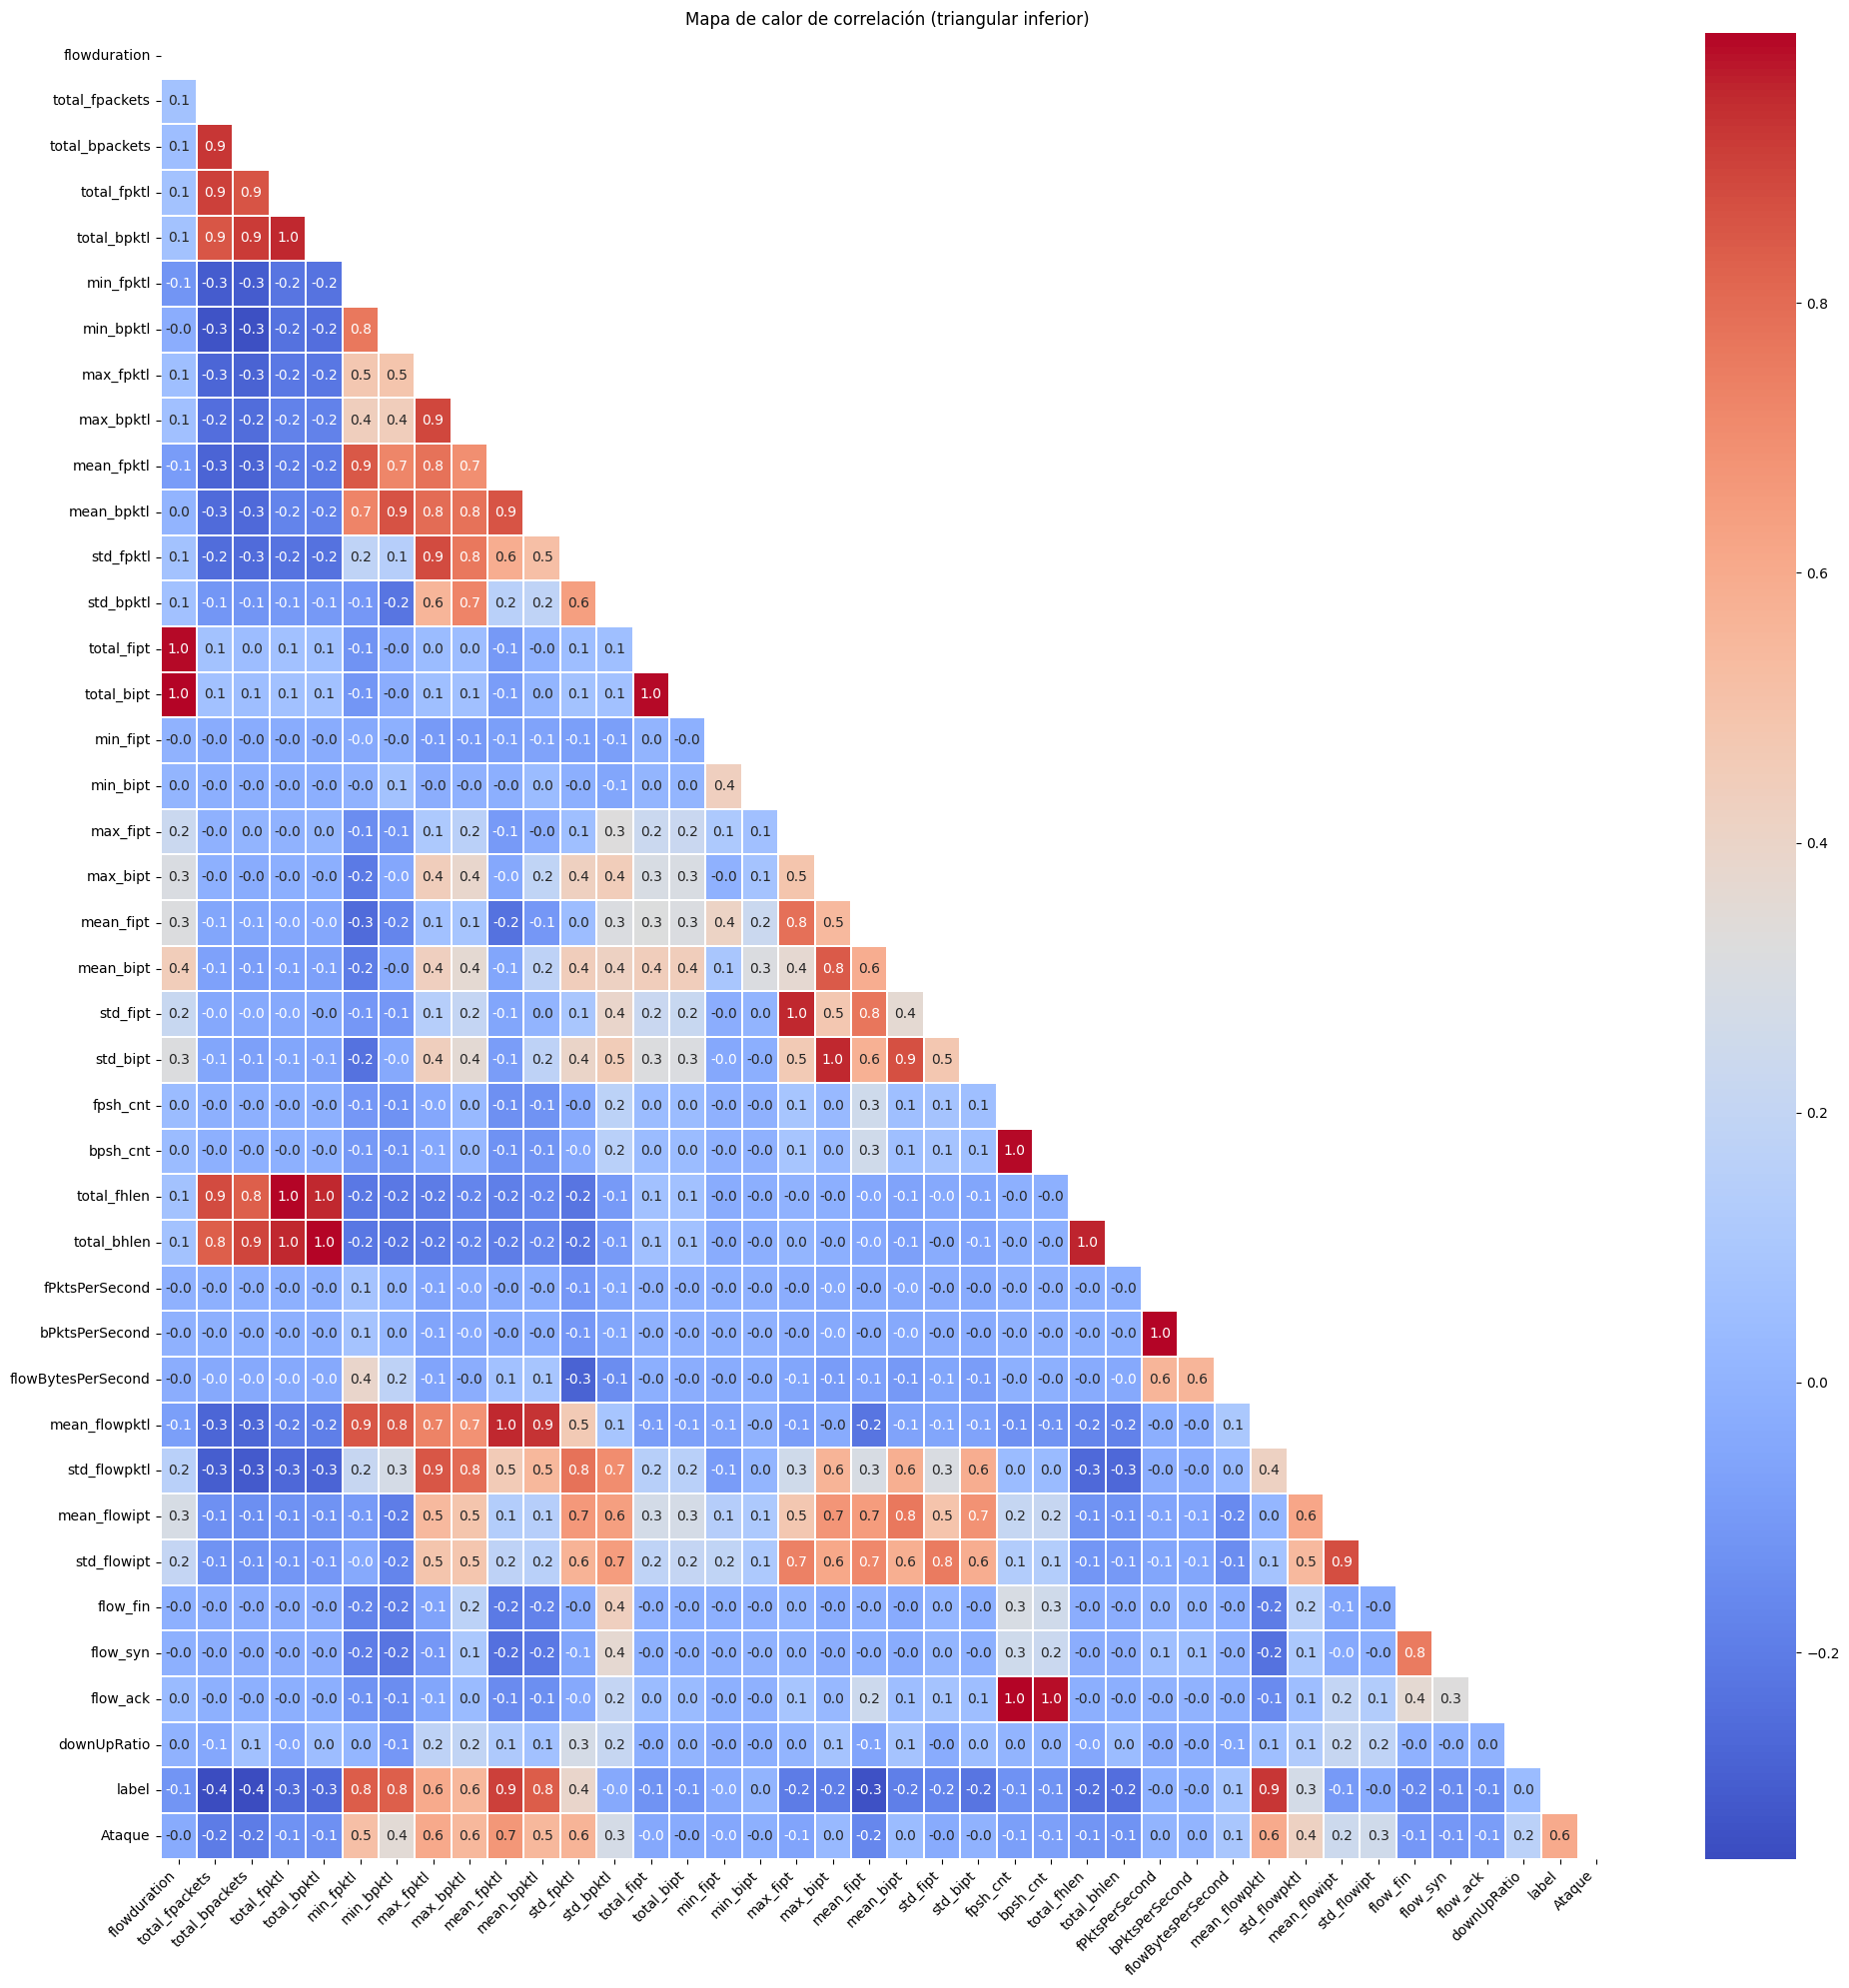

In [24]:
#Calcular la matriz de correlación
#correlation_matrix = df.drop('label', axis=1).corr()
# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Crear la máscara para ocultar la parte superior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Graficar heatmap con la máscara aplicada
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".1f",
            linewidths=.05, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)

# Rotar etiquetas en eje x
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('Mapa de calor de correlación (triangular inferior)')
plt.tight_layout()
plt.show()

### Observaciones analíticas (con anotaciones)

1. **Alta colinealidad en algunas características**  
   Se observa una alta correlación perfecta (`1.0`) entre algunas características, como `total_bpktl` con `total_fpktl` y `total_bBpktl`, lo que indica que estas variables están completamente redundadas. Asimismo, existen múltiples pares con correlaciones por encima de `0.85`, lo cual puede afectar negativamente modelos de aprendizaje automático debido a multicolinealidad. Se recomienda aplicar reducción de dimensionalidad o seleccionar un subconjunto de variables no redundantes mediante técnicas como VIF o PCA.

2. **Correlación con la etiqueta (`label`)**  
   La mayoría de las correlaciones entre las variables y la columna `label` se encuentran en rangos bajos, principalmente entre `-0.2` y `0.2`. No obstante, variables como `flow_syn`, `flow_ack` y `downUpRatio` muestran correlaciones negativas moderadas (hasta alrededor de `-0.3`), lo cual puede indicar una ligera asociación útil para propósitos de clasificación binaria. Aunque no se trata de correlaciones fuertes, sí podrían aportar valor como indicadores tempranos.

3. **Relaciones débiles y posible independencia lineal**  
   Una gran proporción de las celdas presenta valores cercanos a `0.0`, lo que sugiere que muchas variables no están linealmente relacionadas entre sí. Esto es útil en modelos de clasificación o regresión, ya que puede implicar que aportan información complementaria. Sin embargo, se debe tener precaución, ya que relaciones no lineales podrían no estar siendo capturadas por esta matriz. Se sugiere realizar análisis complementarios como mutual information o métodos de selección no paramétricos.




## Eliminacion de features altamente correlacionadas
Eliminar automáticamente características altamente correlacionadas entre sí, basado en un umbral (por ejemplo, 0.95):

In [25]:
# Calcular la matriz de correlación absoluta
corr_matrix = df.corr().abs()

# Crear una máscara para la parte superior del triángulo
upper = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

# Encontrar columnas con correlación mayor al umbral
umbral = 0.95
columnas_a_eliminar = [column for column in upper.columns if any(upper[column] > umbral)]

# Mostrar las columnas que serán eliminadas
print("Características altamente correlacionadas (r > {:.2f}):".format(umbral))
print(columnas_a_eliminar)

# Eliminar del DataFrame
df = df.drop(columns=columnas_a_eliminar)

Características altamente correlacionadas (r > 0.95):
['flowduration', 'total_fpktl', 'total_bpktl', 'mean_fpktl', 'total_fipt', 'max_fipt', 'max_bipt', 'fpsh_cnt', 'bpsh_cnt', 'total_fhlen', 'fPktsPerSecond']


In [26]:
df.shape

(3518, 29)

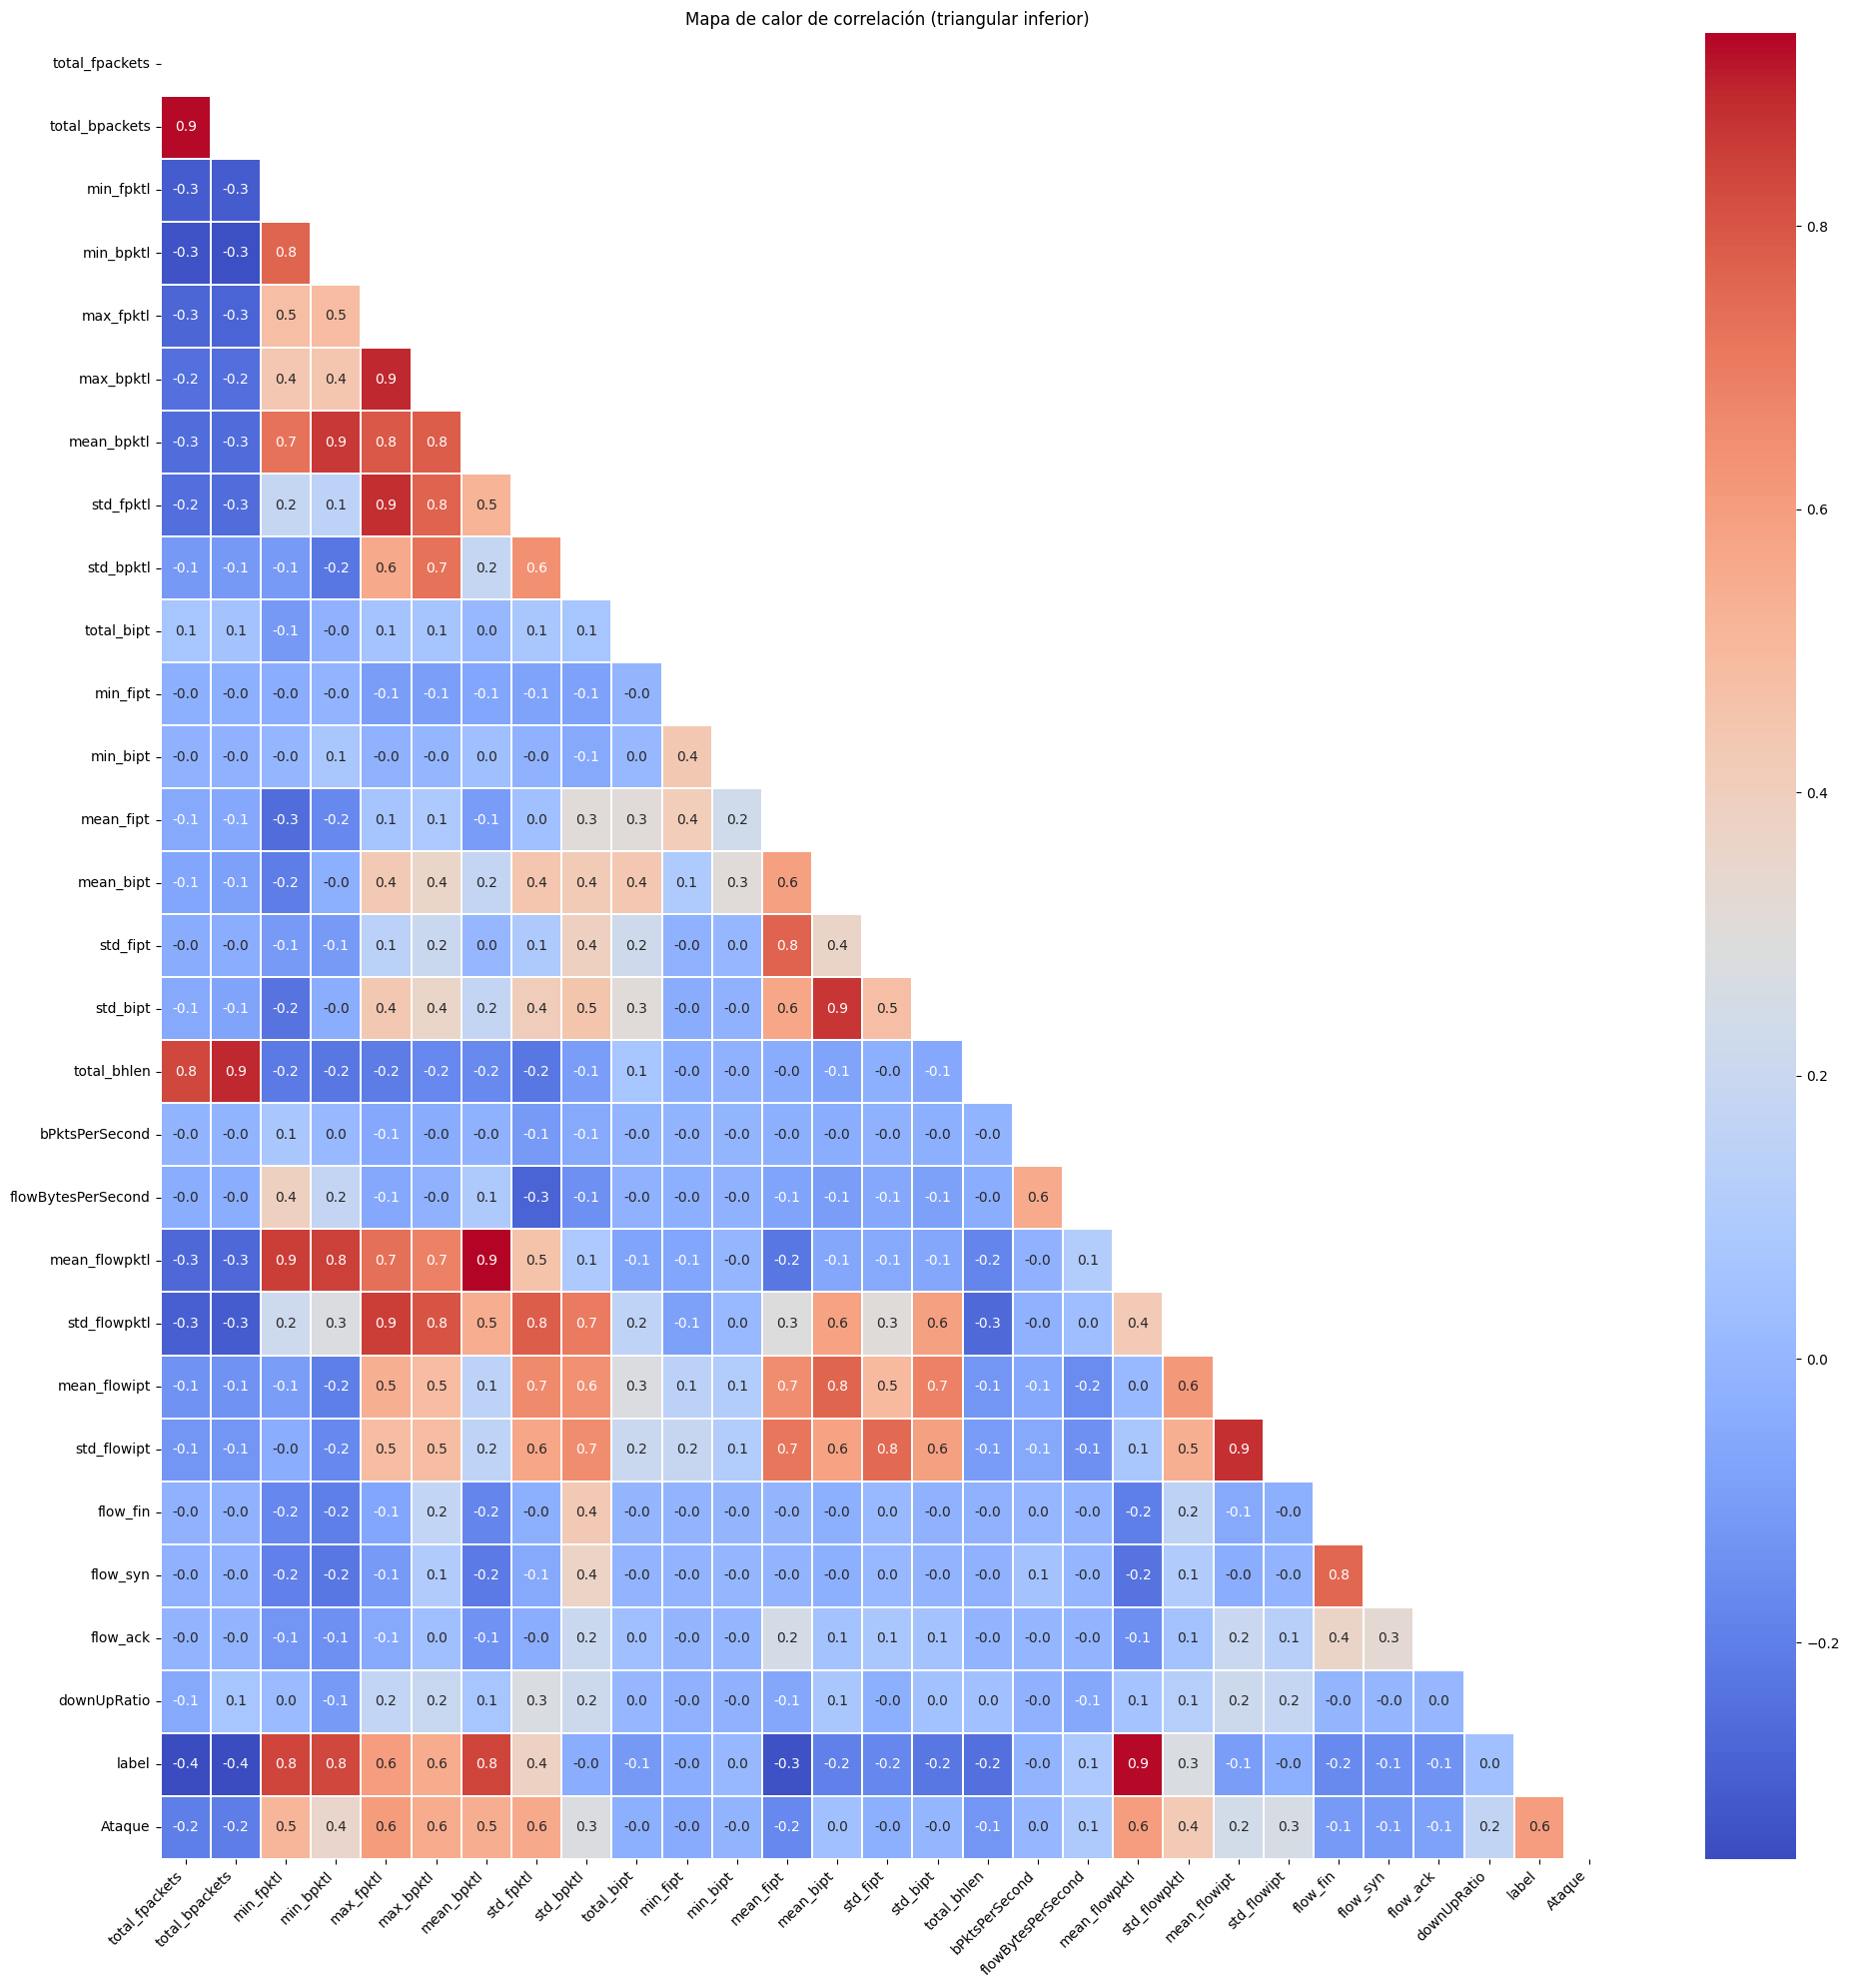

In [27]:
# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Crear la máscara para ocultar la parte superior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Graficar heatmap con la máscara aplicada
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".1f",
            linewidths=.05, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)

# Rotar etiquetas en eje x
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('Mapa de calor de correlación (triangular inferior)')
plt.tight_layout()
plt.show()

# VIF

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.drop('label', axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
display(vif_data.sort_values("VIF", ascending=False))

feature         VIF
6           mean_bpktl  783.321703
19       mean_flowpktl  437.108292
3            min_bpktl  325.600827
4            max_fpktl  295.883496
5            max_bpktl  236.246677
7            std_fpktl  151.019019
20        std_flowpktl   85.220593
2            min_fpktl   82.746515
22         std_flowipt   62.194829
21        mean_flowipt   51.451173
12           mean_fipt   34.598429
8            std_bpktl   33.980478
13           mean_bipt   26.122253
14            std_fipt   25.732274
1       total_bpackets   14.435913
15            std_bipt   14.077146
0       total_fpackets    8.437565
16         total_bhlen    6.197367
10            min_fipt    6.042199
18  flowBytesPerSecond    5.856712
27              Ataque    5.404660
23            flow_fin    3.708258
11            min_bipt    3.087432
24            flow_syn    2.684299
25            flow_ack    2.012782
17      bPktsPerSecond    1.927692
9           total_bipt    1.890951
26         downUpRatio    1.751143

### Análisis de multicolinealidad (VIF)

1. **VIF extremadamente altos**  
   Variables como `flow_ack`, `flow_cwr` y `bpsh_cnt` presentan valores de VIF **mayores a 100,000**, lo cual indica una colinealidad casi perfecta con otras variables. Esto puede causar:
   - Inestabilidad en los coeficientes de modelos lineales (como regresión logística).
   - Dificultad para interpretar la importancia individual de las variables.
   - Inflación del error estándar en los modelos.

2. **Umbral práctico de VIF**  
   Aunque el umbral de tolerancia puede variar según el dominio, las recomendaciones comunes son:
   - **VIF > 10**: indica multicolinealidad severa → considerar eliminar la variable.
   - **VIF entre 5 y 10**: colinealidad moderada → revisar su aporte predictivo.
   - **VIF < 5**: considerado aceptable.

3. **Recomendación inmediata**  
   Se recomienda **eliminar iterativamente** las variables con el VIF más alto hasta que todos los valores estén por debajo de un umbral aceptable (por ejemplo, 10). Esto se puede automatizar para mayor eficiencia (ver código sugerido abajo).




In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def eliminar_vif_alto(df, etiqueta='label', umbral=10.0):
    X = df.drop(columns=[etiqueta,'Ataque'])
    while True:
        vif = pd.Series(
            [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
            index=X.columns
        )
        max_vif = vif.max()
        if max_vif > umbral:
            col_a_eliminar = vif.idxmax()
            print(f"Eliminando '{col_a_eliminar}' con VIF = {max_vif:.2f}")
            X = X.drop(columns=[col_a_eliminar])
        else:
            break
    # reconstruir el dataframe con la etiqueta incluida
    return pd.concat([X, df[[etiqueta,'Ataque']]], axis=1)

# Ejecutar limpieza
df = eliminar_vif_alto(df)

Eliminando 'mean_bpktl' con VIF = 783.29
Eliminando 'max_fpktl' con VIF = 293.25
Eliminando 'mean_flowpktl' con VIF = 230.84
Eliminando 'max_bpktl' con VIF = 155.34
Eliminando 'std_fpktl' con VIF = 93.78
Eliminando 'std_flowipt' con VIF = 42.27
Eliminando 'min_bpktl' con VIF = 36.62
Eliminando 'mean_bipt' con VIF = 22.63
Eliminando 'std_flowpktl' con VIF = 14.30
Eliminando 'total_bpackets' con VIF = 12.96
Eliminando 'mean_fipt' con VIF = 11.58


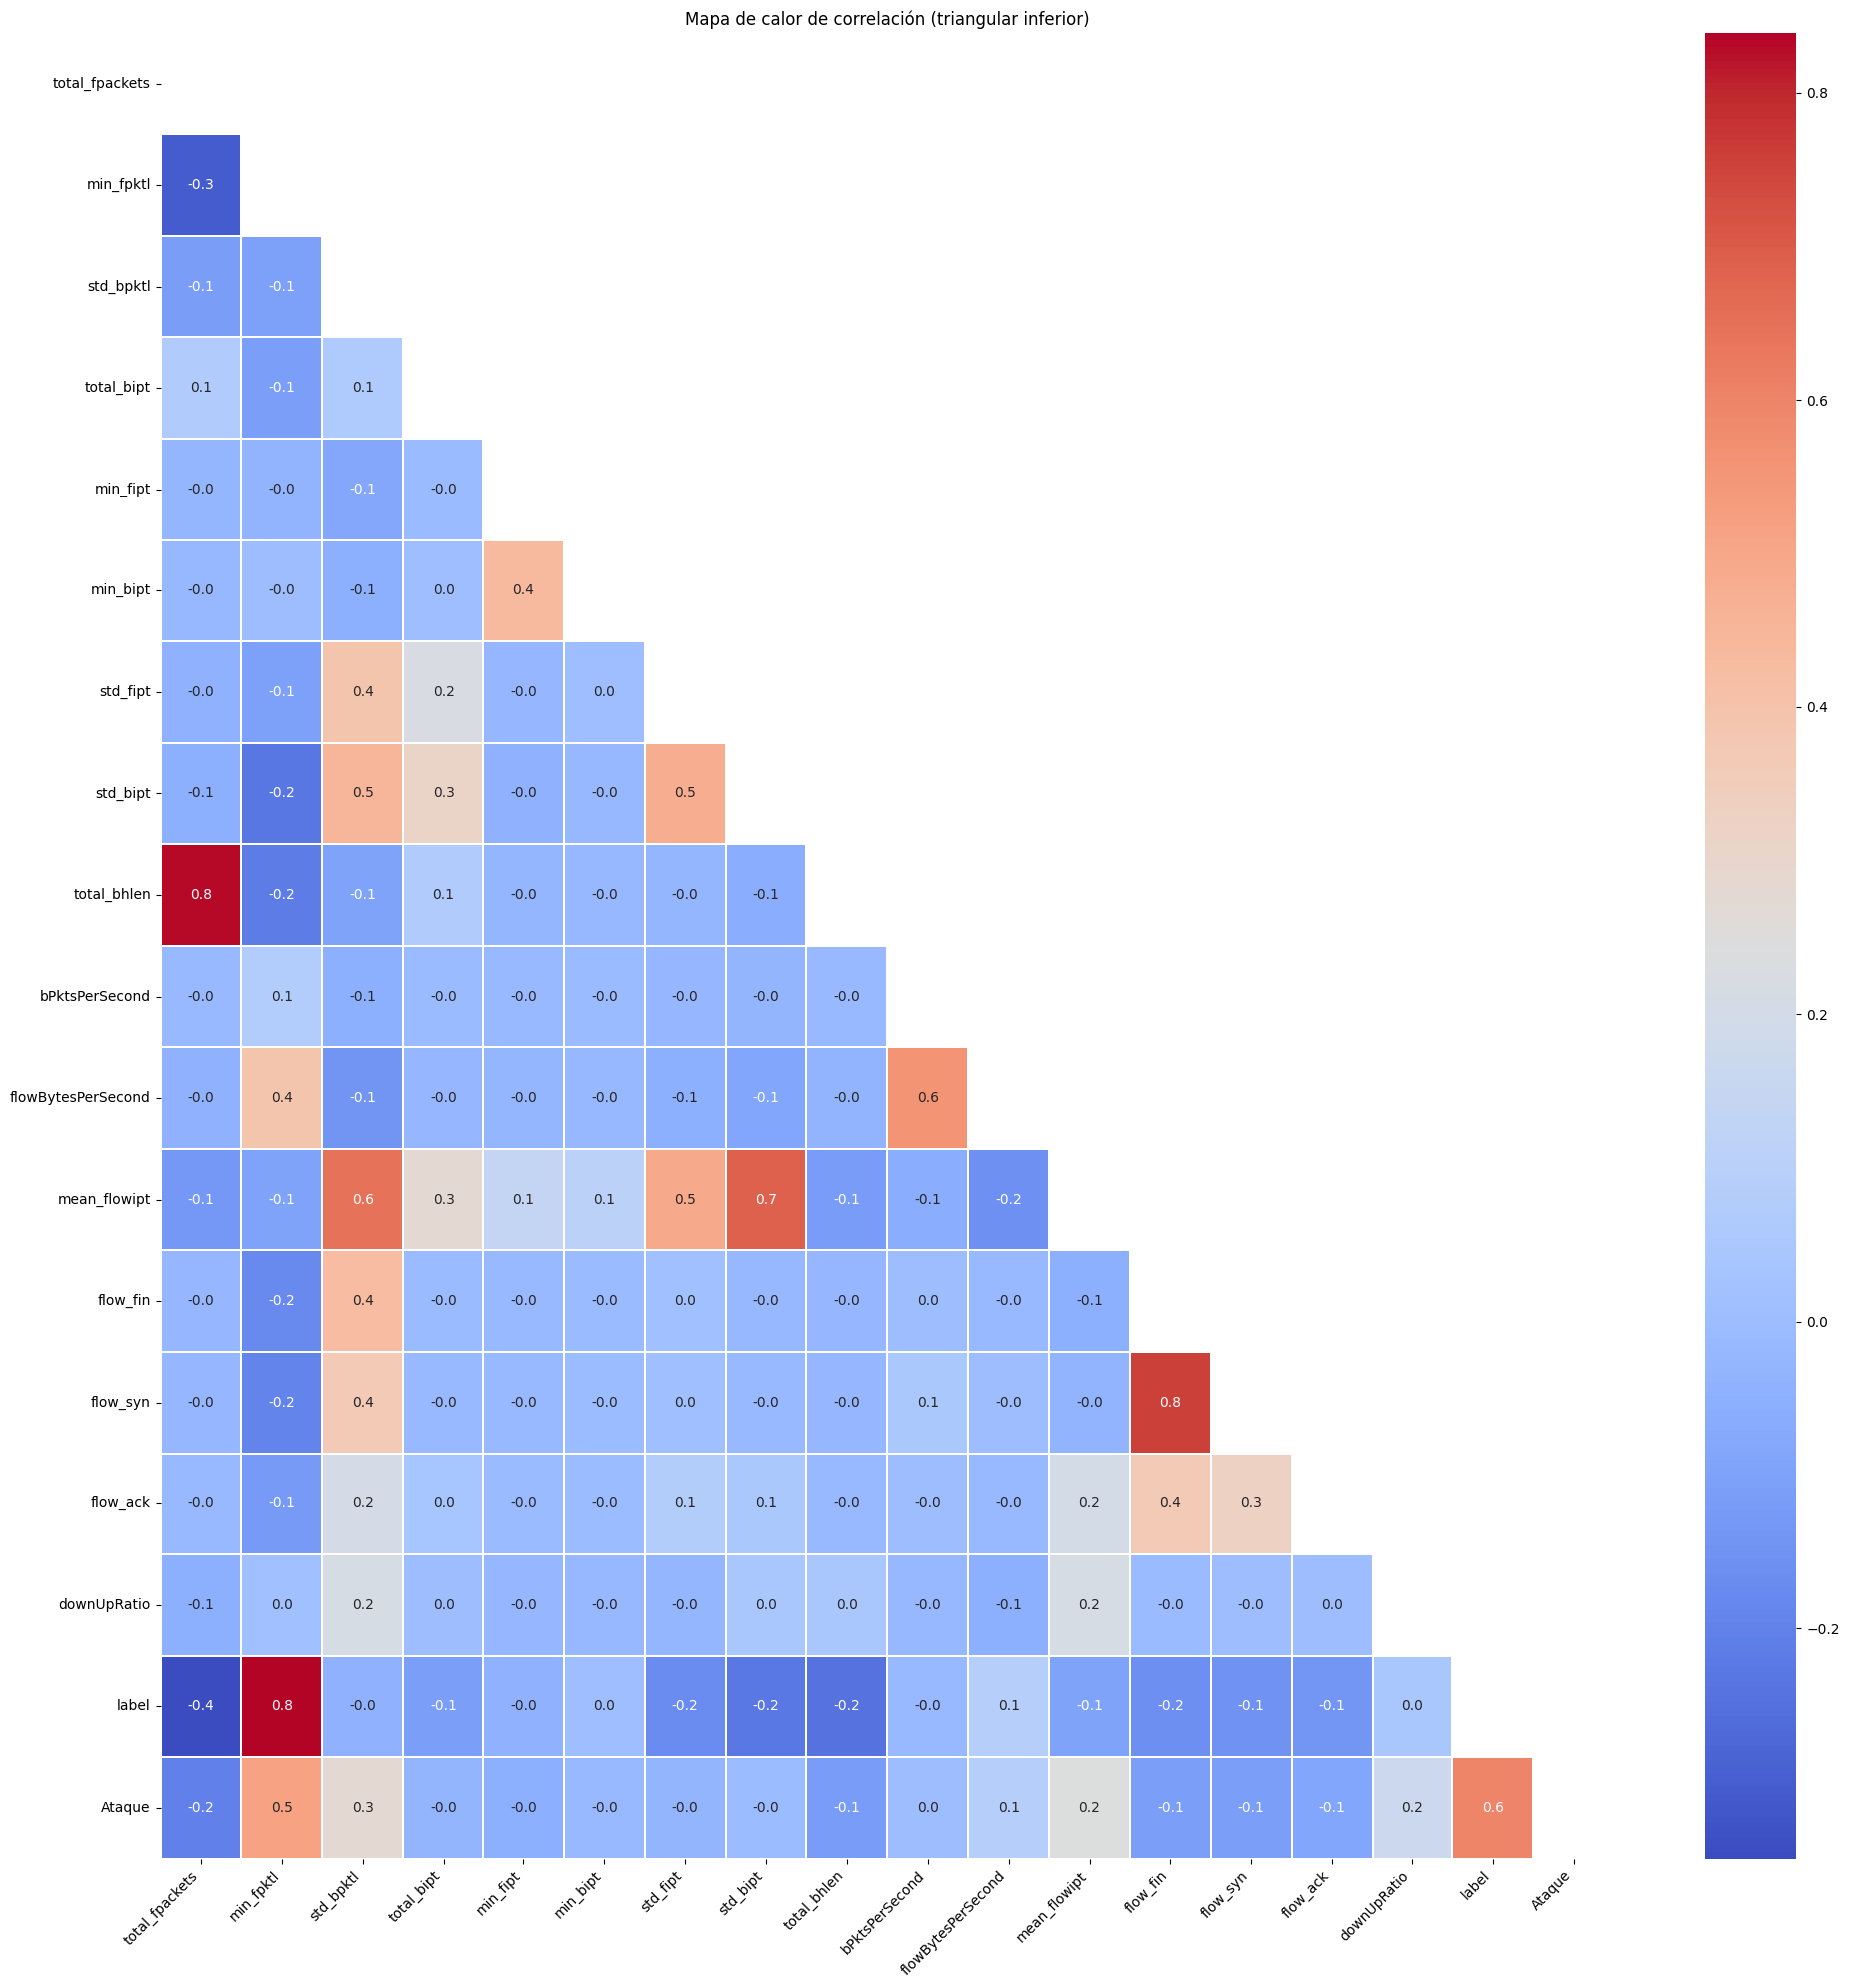

In [30]:
# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Crear la máscara para ocultar la parte superior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Graficar heatmap con la máscara aplicada
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".1f",
            linewidths=.05, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)

# Rotar etiquetas en eje x
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('Mapa de calor de correlación (triangular inferior)')
plt.tight_layout()
plt.show()

In [31]:
df.shape

(3518, 18)

### VIF

In [32]:
df.head()

total_fpackets  min_fpktl   std_bpktl  total_bipt  min_fipt  min_bipt  \
0               2         54    0.000000    0.000000  0.127706  0.000000   
1               6         66    4.000000   18.129866  0.007655  0.129189   
2               4         66    3.829708   14.110779  0.126505  0.126513   
3               5         66    3.577709   18.152292  0.000038  0.130426   
4               7         66  170.870714   18.260816  0.000033  0.000211   

   std_fipt  std_bipt  total_bhlen  bPktsPerSecond  flowBytesPerSecond  \
0  0.000000  0.000000           24        7.830482         1331.182007   
1  6.611206  8.120311          136        0.219161           52.598663   
2  7.648017  7.648030          136        0.283471           38.835484   
3  7.290877  7.275492          168        0.275447           51.288204   
4  5.961416  7.178378          168        0.271873           76.939949   

   mean_flowipt  flow_fin  flow_syn  flow_ack  downUpRatio  label  Ataque  
0      0.063874         0         2         1     0.517857      1       1  
1      2.027954         2         2         9     0.395349      1       1  
2      3.977446         2         2         7     1.014706      1       1  
3      2.303404         2         2         9     0.569983      1       1  
4      1.671939         2         2        11     1.041847      1       1

In [33]:
#Hacemos una copia de nuestro dataset
X=df.copy()
X.drop(['label','Ataque'],axis=1,inplace=True)

In [34]:
# Conjunto de variables predictora

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calcular VIF de cada característica
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
    for i in range(len(X.columns))]

print(vif_data)

               feature       VIF
0       total_fpackets  3.407987
1            min_fpktl  1.955925
2            std_bpktl  4.980321
3           total_bipt  1.212681
4             min_fipt  1.399860
5             min_bipt  1.265105
6             std_fipt  1.555919
7             std_bipt  2.623727
8          total_bhlen  3.483630
9       bPktsPerSecond  1.503775
10  flowBytesPerSecond  1.815939
11        mean_flowipt  6.999193
12            flow_fin  3.121731
13            flow_syn  2.450572
14            flow_ack  1.352145
15         downUpRatio  1.504452


In [35]:
df.drop(['label','Ataque'],axis=1,inplace=False).duplicated().sum()


np.int64(0)

In [36]:
# Eliminar duplicados
df = df.drop_duplicates()
# Eliminar duplicados en todas las columnas excepto 'label' y 'Ataque'
df_cleaned = df.drop(['label', 'Ataque'], axis=1).duplicated(keep='first')

# Filtrar el DataFrame original solo por las filas no duplicadas
df_cleaned = df[~df_cleaned]
df=df_cleaned.copy()

In [37]:
df.drop(['label','Ataque'],axis=1,inplace=False).duplicated().sum()

np.int64(0)

# Creando conjunto de entrenamiento

## Split
La funcion `train_test_split` nos permite dividir un dataset en dos bloques, típicamente bloques destinados al entrenamiento y validación del modelo

In [38]:
df.head()

total_fpackets  min_fpktl   std_bpktl  total_bipt  min_fipt  min_bipt  \
0               2         54    0.000000    0.000000  0.127706  0.000000   
1               6         66    4.000000   18.129866  0.007655  0.129189   
2               4         66    3.829708   14.110779  0.126505  0.126513   
3               5         66    3.577709   18.152292  0.000038  0.130426   
4               7         66  170.870714   18.260816  0.000033  0.000211   

   std_fipt  std_bipt  total_bhlen  bPktsPerSecond  flowBytesPerSecond  \
0  0.000000  0.000000           24        7.830482         1331.182007   
1  6.611206  8.120311          136        0.219161           52.598663   
2  7.648017  7.648030          136        0.283471           38.835484   
3  7.290877  7.275492          168        0.275447           51.288204   
4  5.961416  7.178378          168        0.271873           76.939949   

   mean_flowipt  flow_fin  flow_syn  flow_ack  downUpRatio  label  Ataque  
0      0.063874         0         2         1     0.517857      1       1  
1      2.027954         2         2         9     0.395349      1       1  
2      3.977446         2         2         7     1.014706      1       1  
3      2.303404         2         2         9     0.569983      1       1  
4      1.671939         2         2        11     1.041847      1       1

In [39]:
df.shape

(3518, 18)

In [40]:
df=df.dropna()

In [41]:
df.shape

(3518, 18)

In [42]:
# Positivos para entrenamiento
df_train = df[(df['Ataque'] != 10) & (df['Ataque'] != 0)].copy()
# Positivos para validación
df_val_pos = df[df['Ataque'] == 10].copy()
# Negativos
df_neg = df[df['Ataque'] == 0].copy()

print("df_train", len(df_train),", df_val_pos", len(df_val_pos),", df_neg", len(df_neg))


df_train 909 , df_val_pos 1885 , df_neg 724


In [43]:
df_train.head()

total_fpackets  min_fpktl   std_bpktl  total_bipt  min_fipt  min_bipt  \
0               2         54    0.000000    0.000000  0.127706  0.000000   
1               6         66    4.000000   18.129866  0.007655  0.129189   
2               4         66    3.829708   14.110779  0.126505  0.126513   
3               5         66    3.577709   18.152292  0.000038  0.130426   
4               7         66  170.870714   18.260816  0.000033  0.000211   

   std_fipt  std_bipt  total_bhlen  bPktsPerSecond  flowBytesPerSecond  \
0  0.000000  0.000000           24        7.830482         1331.182007   
1  6.611206  8.120311          136        0.219161           52.598663   
2  7.648017  7.648030          136        0.283471           38.835484   
3  7.290877  7.275492          168        0.275447           51.288204   
4  5.961416  7.178378          168        0.271873           76.939949   

   mean_flowipt  flow_fin  flow_syn  flow_ack  downUpRatio  label  Ataque  
0      0.063874         0         2         1     0.517857      1       1  
1      2.027954         2         2         9     0.395349      1       1  
2      3.977446         2         2         7     1.014706      1       1  
3      2.303404         2         2         9     0.569983      1       1  
4      1.671939         2         2        11     1.041847      1       1

In [44]:
df_neg_train,df_neg_val = train_test_split(df_neg.sample(frac=1,random_state=42),test_size=0.20,random_state=42)

print("df_neg_train:",len(df_neg_train),", df_neg_val:",len(df_neg_val))

df_train_f=pd.concat([df_train,df_neg_train],ignore_index=1)
df_val_f=pd.concat([df_val_pos,df_neg_val],ignore_index=1)

df_train_f=df_train_f.sample(frac=1, random_state=42)

df_val_f=df_val_f.sample(frac=1, random_state=42)

print("df_train_f:",len(df_train_f),", df_val_f:",len(df_val_f))



df_neg_train: 579 , df_neg_val: 145
df_train_f: 1488 , df_val_f: 2030


In [45]:
X_train,X_test,y_train,y_test = train_test_split(df_train_f.drop(columns=['label']), df_train_f['label'], test_size=0.25, random_state=42)

In [46]:
#Original dataset dimensions
X_train.shape, X_test.shape


((1116, 17), (372, 17))

In [47]:
X_train

total_fpackets  min_fpktl   std_bpktl  total_bipt  min_fipt  min_bipt  \
1218            4627         62    4.247505   93.304812  0.000011  0.000000   
127                6        390    1.032796    0.778269  0.154354  0.154185   
16                 6        387    1.032796    0.781104  0.155638  0.155436   
986              164         46  121.758003  960.406246  0.000349  0.000961   
1039               1         62    0.000000    0.000000  0.000000  0.000000   
...              ...        ...         ...         ...       ...       ...   
1165              28         62   34.999099   65.732107  0.099945  0.000000   
854                6        387    1.032796    0.778982  0.153147  0.153525   
1268            1410         62   11.093807   61.263572  0.000011  0.000000   
21                 6        388    1.505545    0.776465  0.152030  0.152189   
1077               1         62    0.000000    0.000000  0.000000  0.000000   

      std_fipt   std_bipt  total_bhlen  bPktsPerSecond  flowBytesPerSecond  \
1218  0.014632   0.015248       827064       49.273823        21146.271480   
127   0.000966   0.000993         2930        7.704427         8685.457031   
16    0.000599   0.000673         2912        7.676601         8606.749023   
986   4.031698  21.416023        36713        0.061866           81.588737   
1039  0.000000   0.000000           40       93.977371        12780.921880   
...        ...        ...          ...             ...                 ...   
1165  2.305217   2.286056         2268        0.559134          120.138222   
854   0.001684   0.001570         2914        7.698238         8641.271484   
1268  0.560684   0.019879       540648       49.262123        15402.689450   
21    0.001843   0.001783         2918        7.723150         8679.534180   
1077  0.000000   0.000000           40       97.002800        13192.380860   

      mean_flowipt  flow_fin  flow_syn  flow_ack  downUpRatio  Ataque  
1218      0.016788         0         0         0     0.993456       0  
127       0.070943         0         0         0     0.863361       1  
16        0.071274         0         0         0     0.862919       1  
986       4.996678         0         0         0     0.903991       0  
1039      0.010641         0         0         0     1.193548       0  
...            ...       ...       ...       ...          ...     ...  
1165      1.396292         0         0         0     0.797016       0  
854       0.071117         0         0         0     0.862040       1  
1268      0.025259         0         0         0     2.141545       0  
21        0.070856         0         0         0     0.862193       1  
1077      0.010309         0         0         0     1.193548       0  

[1116 rows x 17 columns]

In [48]:
print("",collections.Counter(y_train),"",collections.Counter(y_test))

 Counter({1: 687, 0: 429})  Counter({1: 222, 0: 150})


In [49]:
A_train=X_train.Ataque.copy()
collections.Counter(X_train.Ataque)

Counter({1: 687, 0: 429})

In [50]:
A_train

1218    0
127     1
16      1
986     0
1039    0
       ..
1165    0
854     1
1268    0
21      1
1077    0
Name: Ataque, Length: 1116, dtype: int64

In [51]:
A_test=X_test.Ataque.copy()


In [52]:
A_test

632     1
857     1
721     1
139     1
1169    0
       ..
619     1
151     1
609     1
499     1
800     1
Name: Ataque, Length: 372, dtype: int64

In [53]:
collections.Counter(y_test)

Counter({1: 222, 0: 150})

## Estandarizacion de variables numericas

**Estandarizar las variables** significa ajustar sus valores para que tengan una media de cero y una desviación estándar de uno

In [54]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_cols)], remainder='passthrough')

# fit on the trainning dataset
preprocessor.fit_transform(X_train)
X_train_stand = preprocessor.transform(X_train)
X_test_stand  = preprocessor.transform(X_test)
#The result returned by ColumnTransformer is a numpy array, so the column names are lost.

## Regenerando el dataset

In [55]:
labels=list(X_train.columns.values.tolist())
df_X_train_stand=pd.DataFrame(X_train_stand,columns=labels)
df_X_test_stand=pd.DataFrame(X_test_stand,columns=labels)
df_X_train_stand.drop(['Ataque'],axis=1,inplace=True)
df_X_test_stand.drop(['Ataque'],axis=1,inplace=True)

In [56]:
df_X_train_stand.columns

Index(['total_fpackets', 'min_fpktl', 'std_bpktl', 'total_bipt', 'min_fipt',
       'min_bipt', 'std_fipt', 'std_bipt', 'total_bhlen', 'bPktsPerSecond',
       'flowBytesPerSecond', 'mean_flowipt', 'flow_fin', 'flow_syn',
       'flow_ack', 'downUpRatio'],
      dtype='object')

In [57]:
df_X_test_stand

total_fpackets  min_fpktl  std_bpktl  total_bipt  min_fipt  min_bipt  \
0         -0.277517   0.716530  -0.306481   -0.276310  0.008461  0.510147   
1         -0.277517   0.716530  -0.302382   -0.276382  0.002874  0.478825   
2         -0.277517   0.728414  -0.301194   -0.276381  0.008173  0.510559   
3         -0.277517   0.710589  -0.302382   -0.276383  0.005755  0.494377   
4          1.612556  -1.214498  -0.236974    0.092384 -0.208714 -0.744089   
..              ...        ...        ...         ...       ...       ...   
367       -0.277517   0.734355  -0.277646   -0.276370  0.008409  0.510931   
368       -0.277517   0.728414  -0.301194   -0.276383  0.007606  0.507037   
369       -0.277517   0.728414  -0.301194   -0.276387 -0.003661  0.450493   
370       -0.277517   0.716530  -0.302382   -0.276382  0.007140  0.502941   
371       -0.277517   0.722472  -0.293423   -0.276381  0.007797  0.507215   

     std_fipt  std_bipt  total_bhlen  bPktsPerSecond  flowBytesPerSecond  \
0   -0.269989 -0.242732    -0.276063       -0.055610           -0.149858   
1   -0.271709 -0.243370    -0.276068       -0.055563           -0.149559   
2   -0.273532 -0.244045    -0.276044       -0.055563           -0.149509   
3   -0.272985 -0.243827    -0.276083       -0.055563           -0.149608   
4   -0.259044 -0.240561     1.527722       -0.043744           -0.128904   
..        ...       ...          ...             ...                 ...   
367 -0.273148 -0.243887    -0.276053       -0.055570           -0.149573   
368 -0.273436 -0.244005    -0.276058       -0.055562           -0.149535   
369 -0.270563 -0.243041    -0.276044       -0.055559           -0.149487   
370 -0.273151 -0.243892    -0.276063       -0.055563           -0.149570   
371 -0.273415 -0.243980    -0.276068       -0.055563           -0.149552   

     mean_flowipt  flow_fin  flow_syn  flow_ack  downUpRatio  
0       -0.316103 -0.157459 -0.172914 -0.105438    -0.063697  
1       -0.317101 -0.157459 -0.172914 -0.105438    -0.063935  
2       -0.317139 -0.157459 -0.172914 -0.105438    -0.063964  
3       -0.317098 -0.157459 -0.172914 -0.105438    -0.063141  
4       -0.353746 -0.157459 -0.172914 -0.105438    -0.038730  
..            ...       ...       ...       ...          ...  
367     -0.316958 -0.157459 -0.172914 -0.105438    -0.064080  
368     -0.317147 -0.157459 -0.172914 -0.105438    -0.063889  
369     -0.317124 -0.157459 -0.172914 -0.105438    -0.063892  
370     -0.317179 -0.157459 -0.172914 -0.105438    -0.063195  
371     -0.317130 -0.157459 -0.172914 -0.105438    -0.064220  

[372 rows x 16 columns]

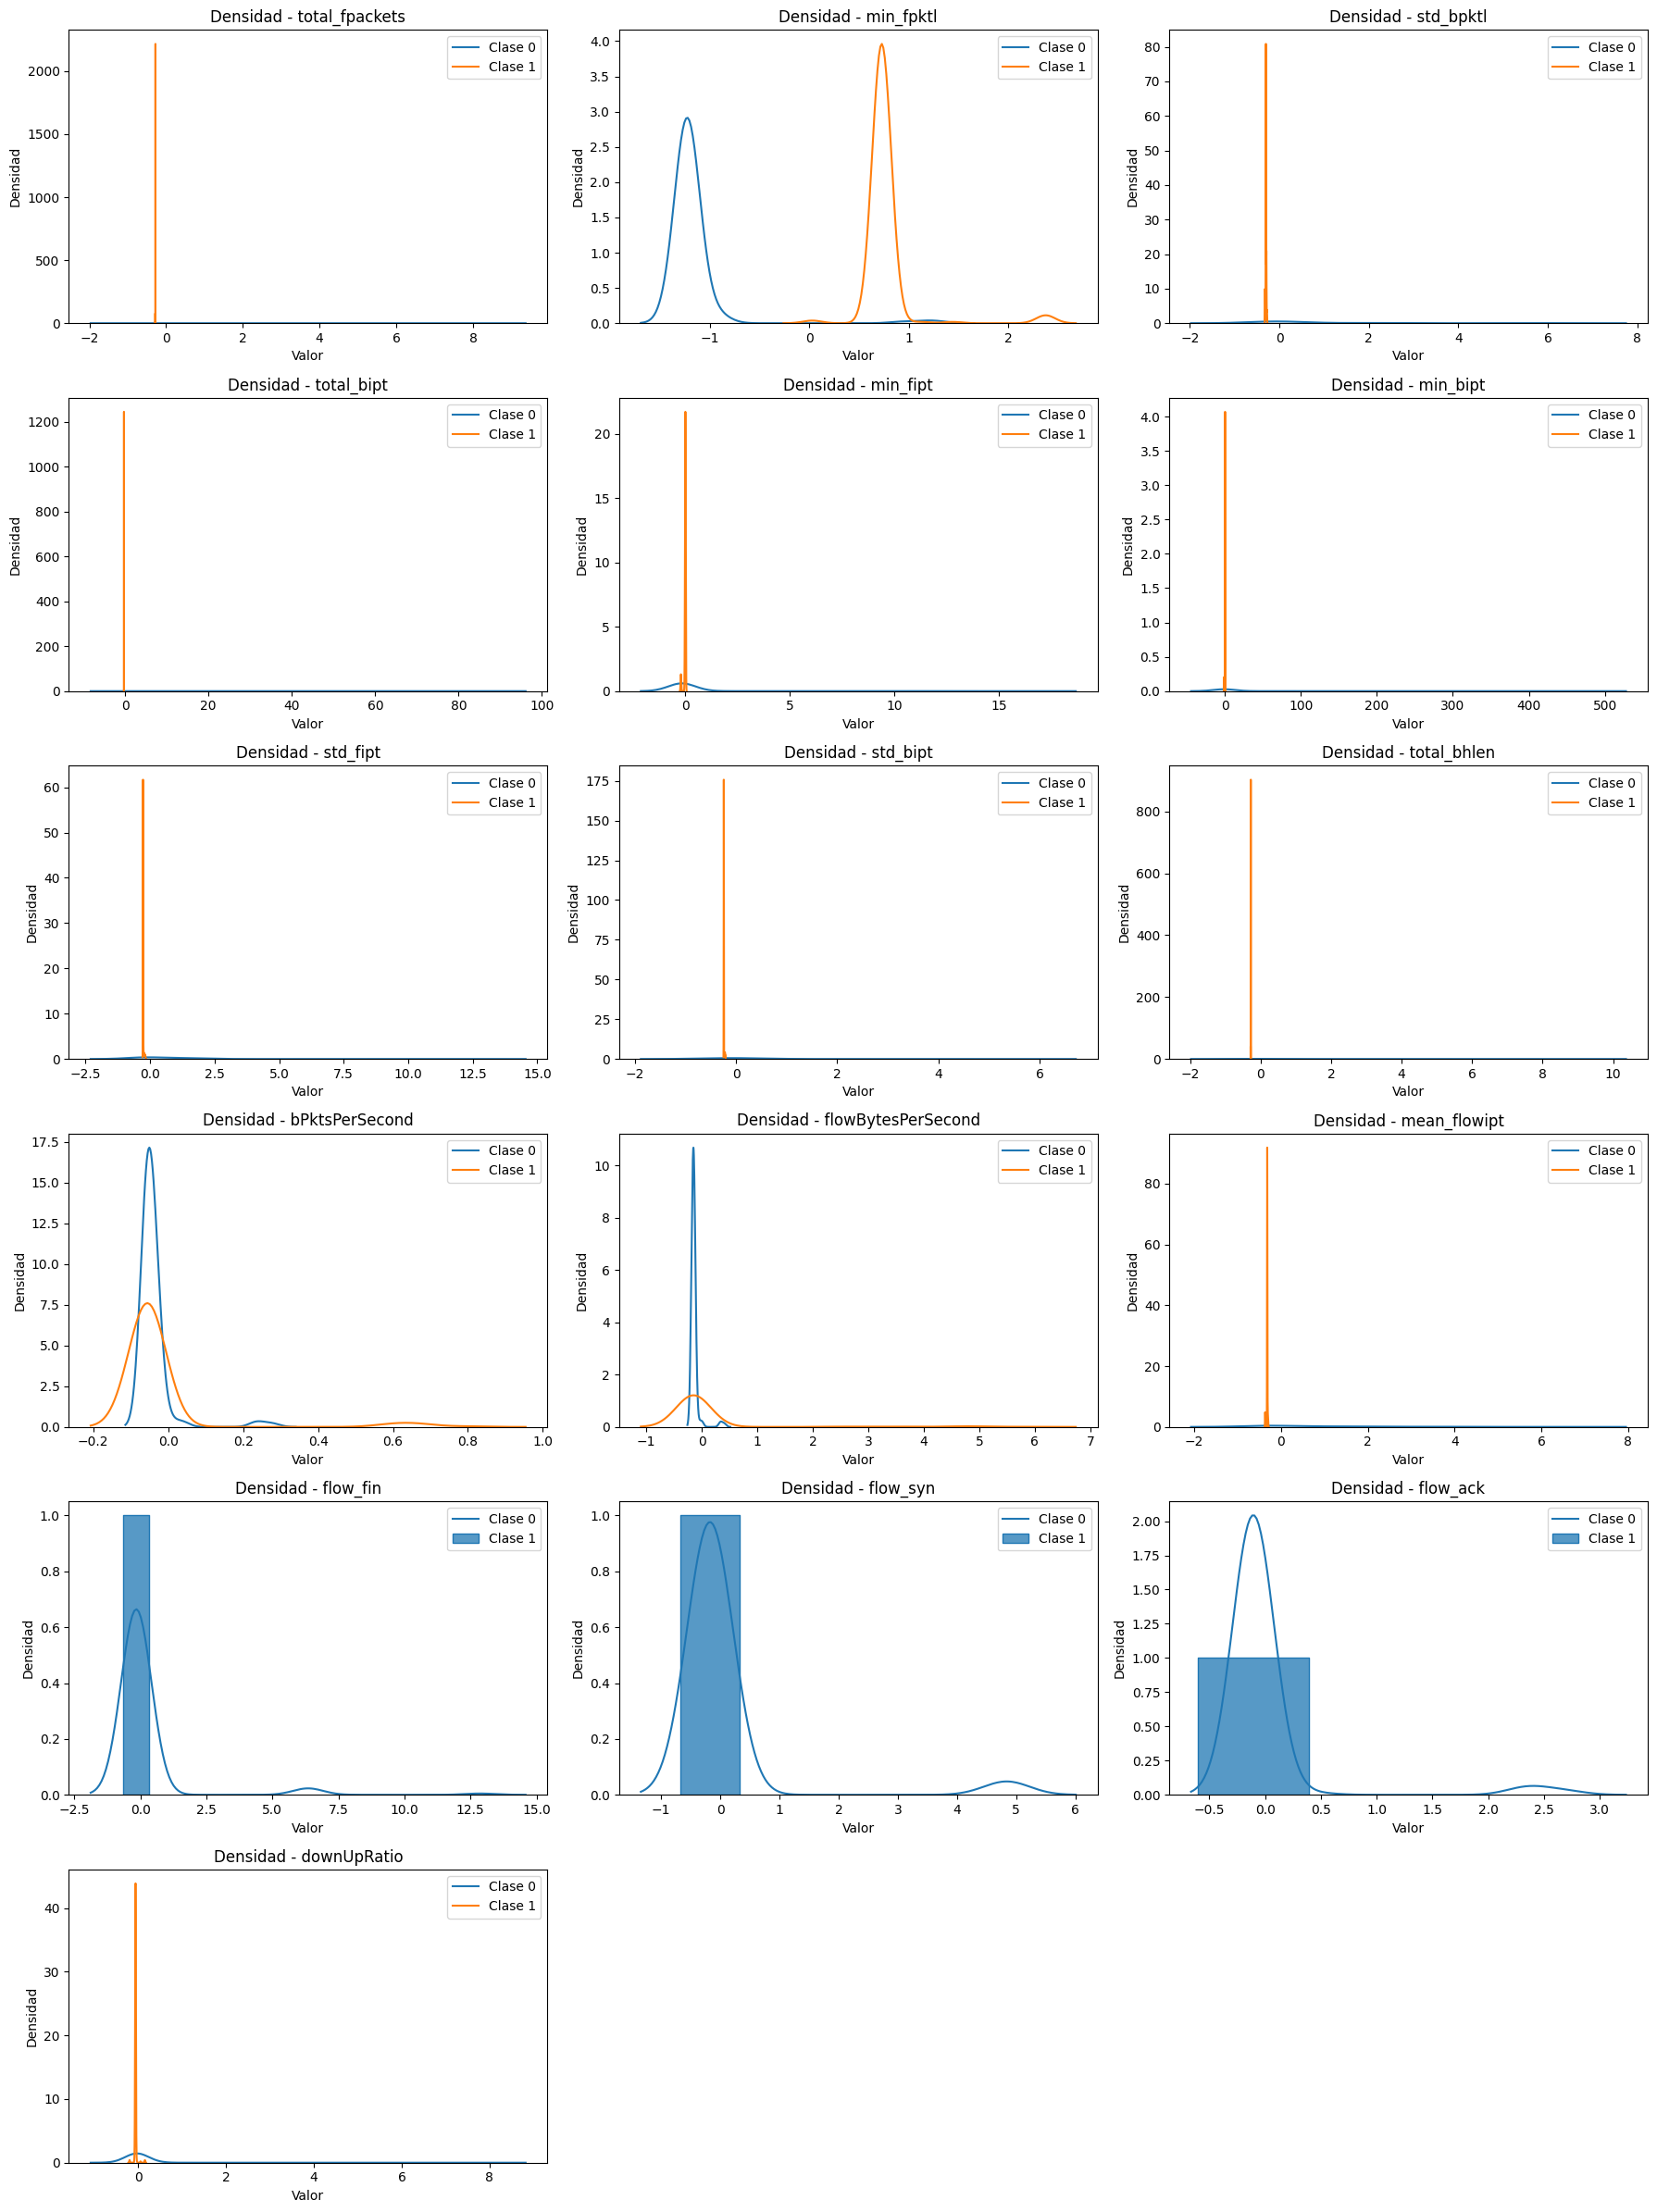

In [58]:
# Asegurar alineación por posición
y_test_series = pd.Series(y_test.values, index=df_X_test_stand.index)

# Obtener todas las features disponibles
features_to_plot = df_X_test_stand.columns
num_features = len(features_to_plot)

# Calcular dinámicamente el layout de subplots
cols = 3
rows = math.ceil(num_features / cols)

# Crear figura
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()

# Graficar densidades
for i, feature in enumerate(features_to_plot):
    ax = axs[i]
    data_ok = False
    for label in sorted(y_test_series.unique()):
        subset = df_X_test_stand.loc[y_test_series == label, feature]
        if subset.nunique() > 1 and subset.shape[0] > 1:
            sns.kdeplot(subset, label=f"Clase {label}", ax=ax)
            data_ok = True
        elif subset.shape[0] > 0:
            sns.histplot(subset, label=f"Clase {label}", ax=ax, kde=False, stat='density', element='step')
            data_ok = True
    if data_ok:
        ax.set_title(f"Densidad - {feature}")
        ax.set_xlabel("Valor")
        ax.set_ylabel("Densidad")
        ax.legend()
    else:
        ax.set_visible(False)

# Ocultar ejes vacíos
for j in range(num_features, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

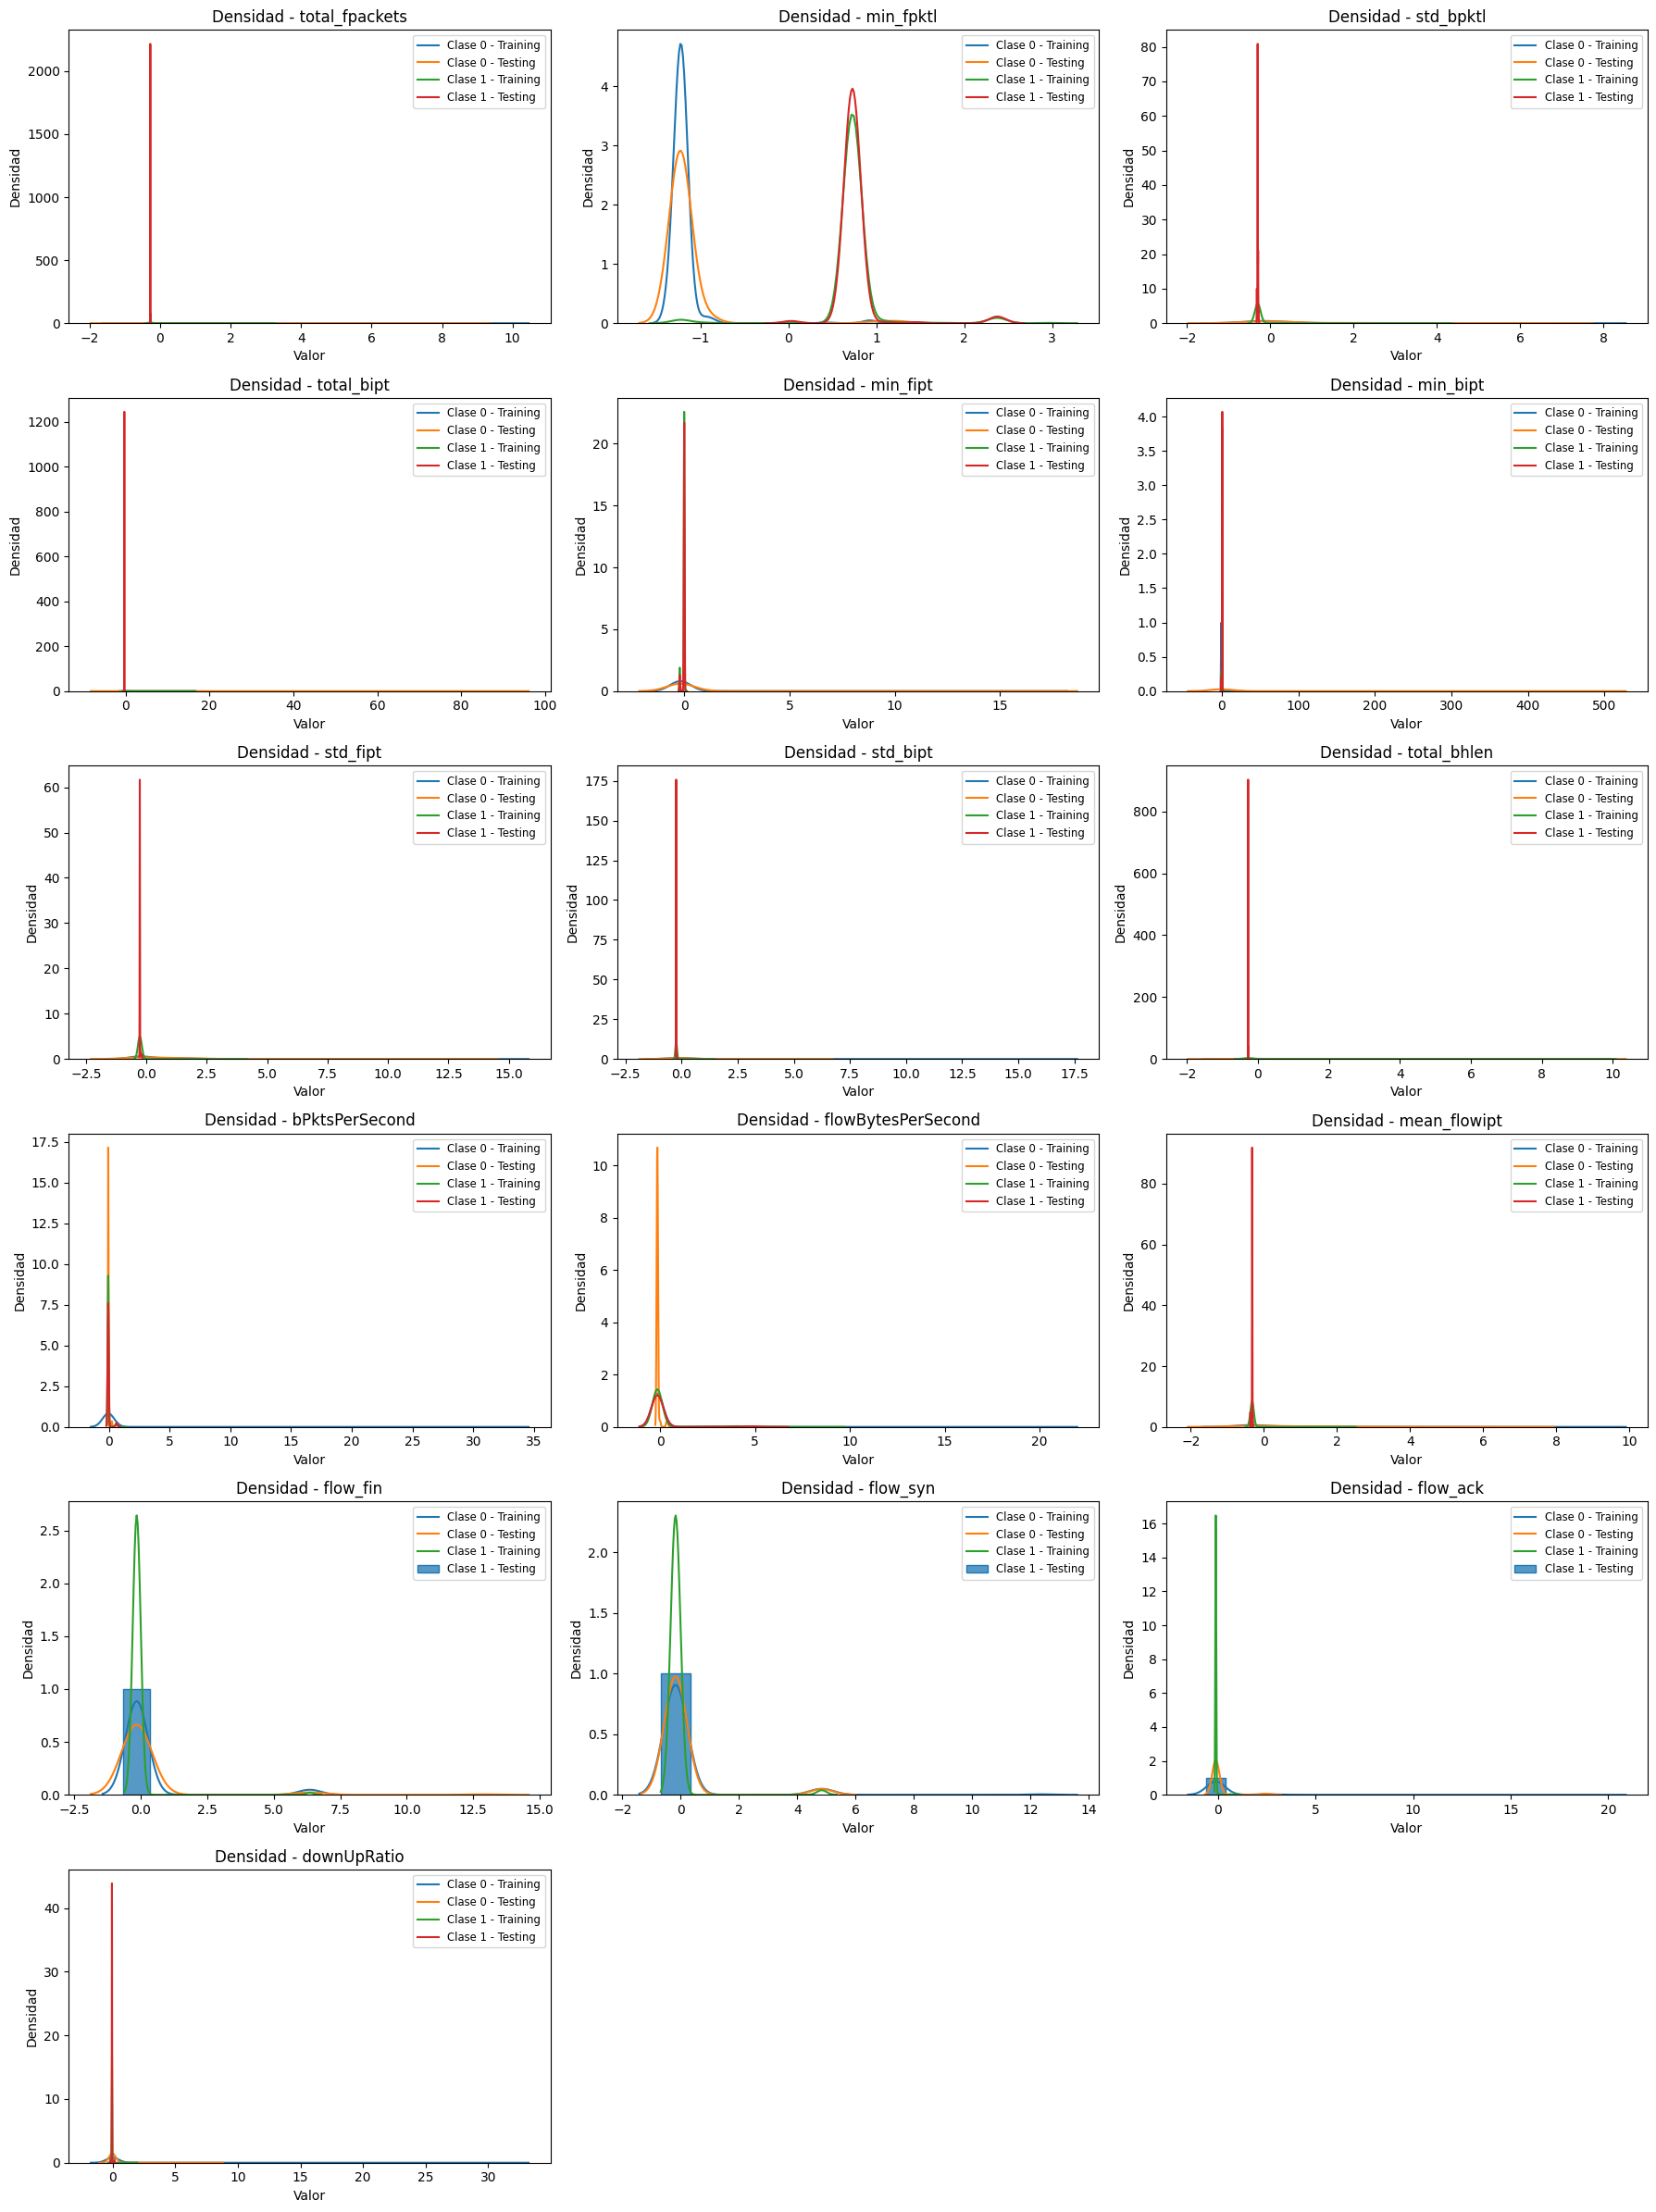

In [59]:
# Crear copias con etiquetas
X_train_dens = df_X_train_stand.copy()
X_train_dens["Set"] = "Training"
X_train_dens["Class"] = y_train.values  # Alineación por posición

X_test_dens = df_X_test_stand.copy()
X_test_dens["Set"] = "Testing"
X_test_dens["Class"] = y_test.values  # Alineación por posición

# Concatenar ambos
X_all_dens = pd.concat([X_train_dens, X_test_dens])
X_all_dens = X_all_dens.reset_index(drop=True)

# Seleccionar features
features_dens = df_X_train_stand.columns
num_features_dens = len(features_dens)

# Layout dinámico
cols = 3
rows = math.ceil(num_features_dens / cols)
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()

# Graficar densidades
for i, feature in enumerate(features_dens):
    ax = axs[i]
    data_ok = False
    for label_class in [0, 1]:
        for label_set in ["Training", "Testing"]:
            subset = X_all_dens[(X_all_dens["Class"] == label_class) & (X_all_dens["Set"] == label_set)][feature]
            if subset.nunique() > 1 and subset.shape[0] > 1:
                sns.kdeplot(subset, label=f"Clase {label_class} - {label_set}", ax=ax)
                data_ok = True
            elif subset.shape[0] > 0:
                sns.histplot(subset, label=f"Clase {label_class} - {label_set}", ax=ax, kde=False, stat='density', element='step')
                data_ok = True
    if data_ok:
        ax.set_title(f"Densidad - {feature}")
        ax.set_xlabel("Valor")
        ax.set_ylabel("Densidad")
        ax.legend(fontsize='small')
    else:
        ax.set_visible(False)

# Eliminar ejes vacíos
for j in range(num_features_dens, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# Modelos Machine Learning

## 1 a 4 Regresion logistica

### 1.- RL con RandomizedSearchCV

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Elapsed time: 0.04 min.
tuned hpyerparameters :(best parameters)  {'solver': 'liblinear', 'penalty': 'l1', 'C': np.float64(1.438449888287663)}
Score: 0.9886108757984085
              precision    recall  f1-score   support

     class 0       1.00      0.99      1.00       150
     class 1       1.00      1.00      1.00       222

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



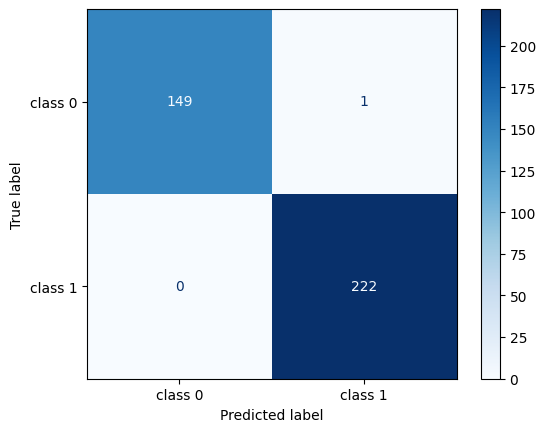

In [60]:
#Run grid search only on training set using cross-validation, n_jobs to -1, it will use all cores
start=perf_counter()
parameters={
    'C':np.logspace(-3,3,20),
    'penalty':["l1","l2","elasticnet"],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
rlrs=RandomizedSearchCV(
    LogisticRegression(),
    parameters,
    cv=5,
    n_jobs=-1,
    verbose=3,
    random_state=42,
    scoring='f1_macro'
)
# fit on the trainning dataset
rlrs.fit(df_X_train_stand,y_train)
tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)
print("tuned hpyerparameters :(best parameters) ",rlrs.best_params_)
print("Score:",rlrs.best_score_)
y_predrlrs = rlrs.predict(df_X_test_stand)
#performance results
print(classification_report(y_test, y_predrlrs, target_names=target_names))

cm = confusion_matrix(y_test, y_predrlrs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [61]:
df_resultados = pd.DataFrame({
    'Clase': A_test,
    'Real': y_test,
    'Predicción': y_predrlrs
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]


R_totales = pd.DataFrame()
R_aciertos =pd.DataFrame()
R_errores=  pd.DataFrame()

val='Primero'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")


Totales por clase: 
 1    222
0    150
Name: Primero, dtype: int64
Aciertos de Predicción:
 1    222
0    149
Name: Primero, dtype: int64
Errores de Predicción:
 0    1
Name: Primero, dtype: int64
Total Correctas: 371, Total Errores: 1


In [62]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_test, y_predrlrs))

El coeficiente de correlacion de Matthews es de  0.9944239155243684


#### Importancia de características con regresión logística

Usando `LogisticRegression`, es posible obtener la importancia de las características a partir de los **coeficientes del modelo entrenado**, accesibles mediante `rlrs.best_estimator_.coef_`.

A continuación se grafican las características ordenadas de mayor a menor según su **impacto absoluto** sobre la variable objetivo:

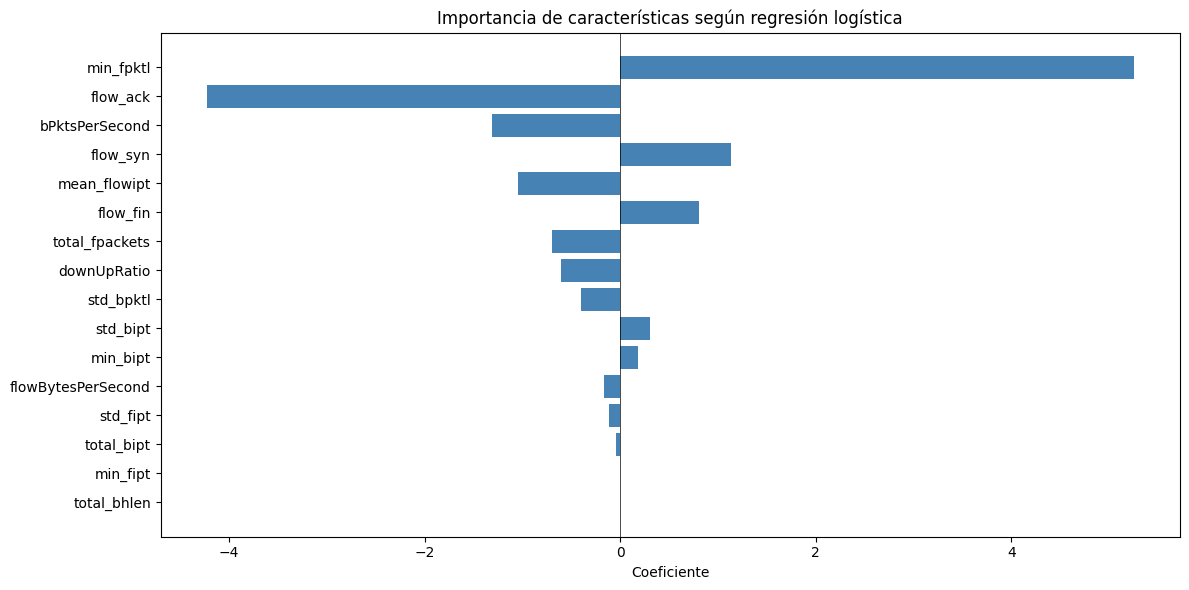

In [63]:
# Obtener los coeficientes del mejor modelo (para clasificación binaria)
best_model = rlrs.best_estimator_
coef = best_model.coef_.flatten()

# Asociar cada coeficiente con su variable
importancia_df = pd.DataFrame({
    'feature': df_X_train_stand.columns,
    'coef': coef,
    'abs_coef': np.abs(coef)
}).sort_values('abs_coef', ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
plt.barh(importancia_df['feature'], importancia_df['coef'], color='steelblue')
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Coeficiente")
plt.title("Importancia de características según regresión logística")
plt.gca().invert_yaxis()  # Coloca las más importantes arriba
plt.tight_layout()
plt.show()

#### Curvas de aprendizaje para diagnóstico de generalización

Las curvas de aprendizaje muestran cómo varía el rendimiento del modelo a medida que aumenta el tamaño del conjunto de entrenamiento. Esta visualización ayuda a identificar si el modelo sufre de **overfitting** (alto rendimiento en entrenamiento pero bajo en validación) o **underfitting** (bajo rendimiento en ambos).

A continuación se grafica la curva de aprendizaje para el mejor modelo obtenido con `LogisticRegression`:


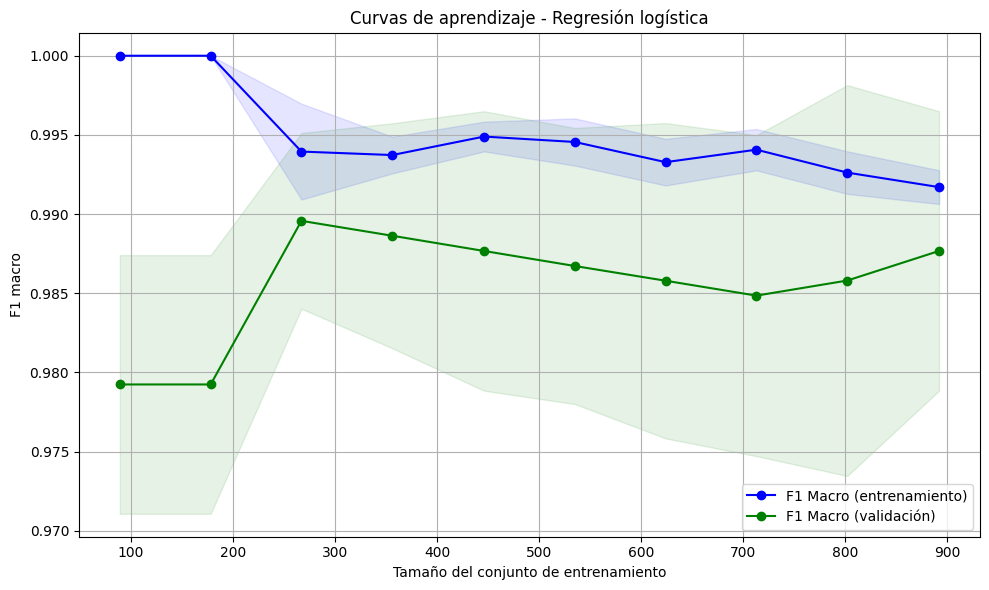

In [64]:
from sklearn.model_selection import learning_curve

# Configurar el modelo con los mejores parámetros encontrados
modelo_final = LogisticRegression(**rlrs.best_params_, random_state=42, max_iter=1000)

# Calcular las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo_final,
    X=df_X_train_stand,
    y=y_train,
    cv=5,
    scoring='f1_macro',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Promedios y desviaciones
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="F1 Macro (entrenamiento)")
plt.plot(train_sizes, test_scores_mean, 'o-', color="green", label="F1 Macro (validación)")
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="green")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("F1 macro")
plt.title("Curvas de aprendizaje - Regresión logística")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()


#### Curva de entrenamiento (F1 macro - azul)
- Comienza muy alta (casi 0.99) con pocas muestras.
- Disminuye gradualmente hasta estabilizarse alrededor de 0.96 cuando se utilizan conjuntos de entrenamiento más grandes.
- Este descenso es normal: con pocos datos, el modelo puede sobreajustar fácilmente; a medida que el conjunto crece, el modelo generaliza más y la puntuación baja ligeramente.

#### Curva de validación (F1 macro - verde)
- Se mantiene bastante estable entre 0.945 y 0.955 a lo largo de los distintos tamaños de muestra.
- Esta estabilidad indica que el modelo no mejora significativamente su rendimiento con más datos, al menos en este rango.

#### Diagnóstico
- **La brecha entre las curvas es pequeña (~0.01),** lo que indica **baja varianza**. Es decir, el modelo no está sobreajustando.
- Como ambas curvas se estabilizan sin una brecha grande y sin tendencia ascendente en la curva de validación, se interpreta que el modelo **ya ha alcanzado su capacidad máxima de generalización** con los datos disponibles.
- No hay indicios de subajuste: la curva de validación no es baja ni plana en niveles muy inferiores.

#### Conclusión
- El modelo generaliza bien con los datos actuales.
- No parece necesario añadir más datos.
- El desempeño es alto y estable, lo que sugiere un buen ajuste.


### 2.- RL con GridSearchCV y RFE
#### Seleccion de caracteristicas con RFE

#### Grid Search and Recursive Feature Elimination

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Elapsed time: 5.49 min.
              precision    recall  f1-score   support

     class 0       1.00      0.99      1.00       150
     class 1       1.00      1.00      1.00       222

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



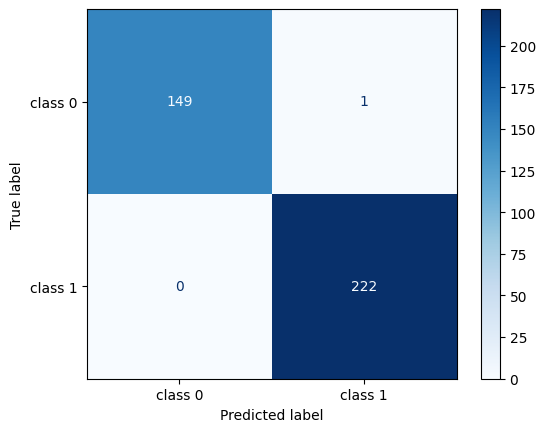

In [65]:
start=perf_counter()
# Definir el estimador base para la regresión logística con selección de características RFE
estimator = LogisticRegression(class_weight='balanced', solver='saga',max_iter=5000)

# Inicializar el selector RFECV
selector = RFECV(estimator, step=0.1, cv=5, scoring='f1_macro', n_jobs=-1)

# Definir el espacio de búsqueda de parámetros para Randomized Search
parameters = {
    'estimator__C': np.logspace(-3, 3, 15),  # Hiperparámetro de regularización para la regresión logística
    'estimator__penalty': ["l1", "l2"],  # Tipo de penalización para la regresión logística
}

# Inicializar Randomized Search con Cross Validation
rlgs = GridSearchCV(selector, parameters, cv=5, n_jobs=-1, verbose=3,scoring='f1_macro')

# Ajustar Randomized Search a los datos de entrenamiento
rlgs.fit(df_X_train_stand,y_train)

# Obtener el mejor modelo
best_model = rlgs.best_estimator_


tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

y_predrlrsaa = best_model.predict(df_X_test_stand)
#performance results
print(classification_report(y_test, y_predrlrsaa, target_names=target_names))

cm = confusion_matrix(y_test, y_predrlrsaa)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()


#### Extraccion de caracteristicas

In [66]:
# Seleccionar las características en los conjuntos de entrenamiento y prueba utilizando el mejor modelo
X_train_selected = best_model.transform(df_X_train_stand)
X_train_selected=pd.DataFrame(X_train_selected)
X_train_selected.head()


0         1         2         3         4
0  1.730306 -1.214498 -0.241461 -0.172914 -0.024687
1 -0.277517  0.734355 -0.302382 -0.172914 -0.063727
2 -0.277517  0.716530 -0.302382 -0.172914 -0.063860
3 -0.208866 -1.309565  1.985431 -0.172914 -0.051534
4 -0.279690 -1.214498 -0.321954 -0.172914  0.035358

In [67]:
# Recuperar los nombres de las características originales
feature_names = df_X_train_stand.columns

# Recuperar los índices de las características seleccionadas
selected_feature_indices = [i for i, selected in enumerate(best_model.support_) if selected]

# Recuperar los nombres de las características seleccionadas
selected_feature_names = feature_names[selected_feature_indices]


In [68]:
X_train_selected=X_train_selected.set_axis(selected_feature_names, axis=1)

#### VIF RFE

Revisamos la importancia de nuestras features seleccionadas por el metodo RFE

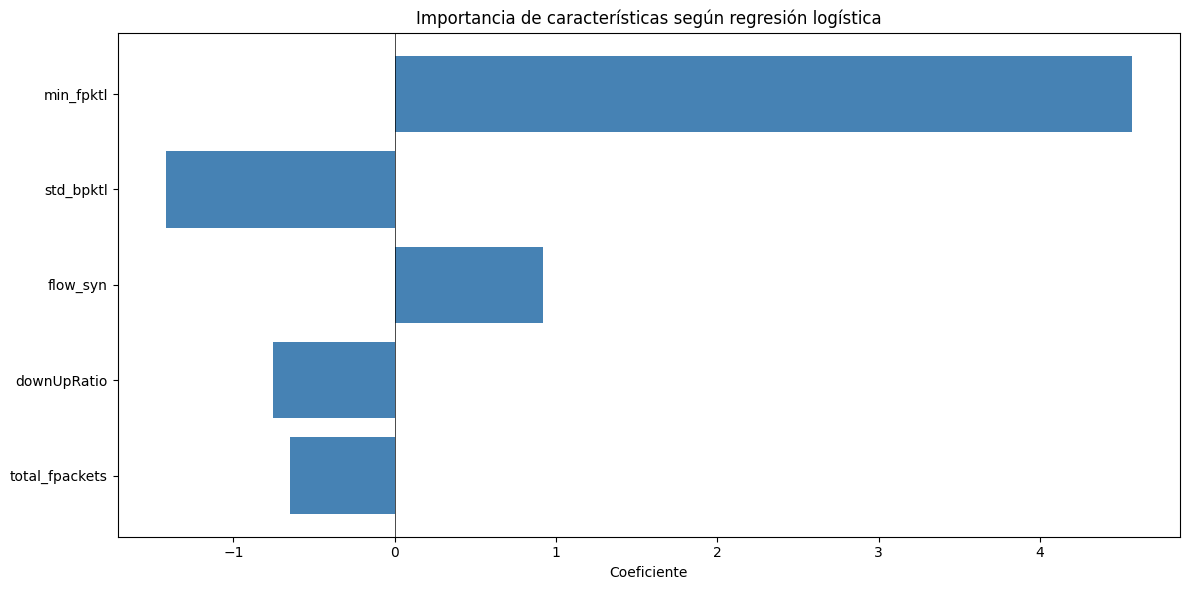

In [69]:
# Acceder al estimador entrenado dentro del RFECV
logreg_model = best_model.estimator_

# Obtener los coeficientes
coef = logreg_model.coef_.flatten()

# Obtener los nombres de las variables seleccionadas
selected_features = df_X_train_stand.columns[best_model.support_]

# Asociar cada coeficiente con su variable
importancia_df = pd.DataFrame({
    'feature': selected_features,
    'coef': coef,
    'abs_coef': np.abs(coef)
}).sort_values('abs_coef', ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
plt.barh(importancia_df['feature'], importancia_df['coef'], color='steelblue')
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Coeficiente")
plt.title("Importancia de características según regresión logística")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Procedemos a eliminar multicolinealidad (VIF) de nuestras features seleccionadas por el metodo RFE de manera automatica en base a las features con mayor VIF y menor importancia

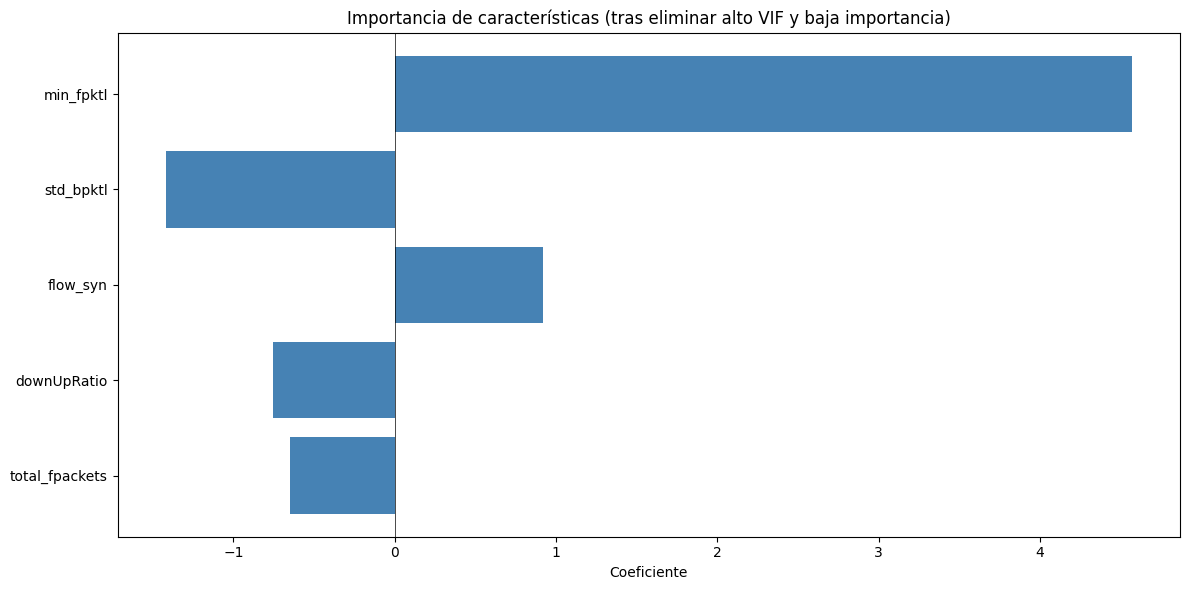

In [70]:
def filtrar_vif_bajo_importancia(X_train_selected, importancia_series, umbral=10.0):
    X = X_train_selected.copy()
    coef_serie = importancia_series.copy()
    eliminadas = []

    while True:
        vif_actual = pd.Series(
            [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
            index=X.columns
        )

        variables_con_vif_alto = vif_actual[vif_actual > umbral]
        if variables_con_vif_alto.empty:
            break

        # Buscar la menos importante (menor abs coef)
        candidatas = pd.DataFrame({
            'vif': variables_con_vif_alto,
            'abs_coef': coef_serie[variables_con_vif_alto.index].abs()
        })
        col_a_eliminar = candidatas.sort_values('abs_coef').index[0]

        print(f"Eliminando '{col_a_eliminar}' con VIF = {variables_con_vif_alto[col_a_eliminar]:.2f} y coef = {coef_serie[col_a_eliminar]:.4f}")

        X = X.drop(columns=[col_a_eliminar])
        coef_serie = coef_serie.drop(index=col_a_eliminar)
        eliminadas.append(col_a_eliminar)

    # Construir DataFrame final de VIF
    vif_datarfe = pd.DataFrame()
    vif_datarfe["feature"] = X.columns
    vif_datarfe["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return X, vif_datarfe, eliminadas


# Paso 1: Crear la serie de coeficientes (post RFECV)
importancia_series = pd.Series(coef, index=X_train_selected.columns)

# Paso 2: Ejecutar el filtrado VIF+importancia
X_train_vif_filtrado, vif_datarfe_final, eliminadas = filtrar_vif_bajo_importancia(X_train_selected, importancia_series)

# Paso 3: Filtrar también la serie de importancia
importancia_filtrada = importancia_series.drop(index=eliminadas)

# Paso 4: Crear DataFrame para graficar
importancia_df = pd.DataFrame({
    'feature': importancia_filtrada.index,
    'coef': importancia_filtrada.values,
    'abs_coef': np.abs(importancia_filtrada.values)
}).sort_values('abs_coef', ascending=False)

# Paso 5: Graficar coeficientes
plt.figure(figsize=(12, 6))
plt.barh(importancia_df['feature'], importancia_df['coef'], color='steelblue')
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Coeficiente")
plt.title("Importancia de características (tras eliminar alto VIF y baja importancia)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [71]:
# VIF dataframe
vif_datarfe = pd.DataFrame()
vif_datarfe["feature"] = X_train_vif_filtrado.columns

# calcular VIF de cada característica
vif_datarfe["VIF"] = [variance_inflation_factor(X_train_vif_filtrado.values, i)
    for i in range(len(X_train_vif_filtrado.columns))]

print(vif_datarfe)

          feature       VIF
0  total_fpackets  1.160984
1       min_fpktl  1.288246
2       std_bpktl  1.807789
3        flow_syn  1.675937
4     downUpRatio  1.006785


Dado que se redujeron las features volvemos a realizar el preprocesamiento de los datos para descartar datos duplicados.

In [72]:
X_train_vif_filtrado.columns

Index(['total_fpackets', 'min_fpktl', 'std_bpktl', 'flow_syn', 'downUpRatio'], dtype='object')

In [73]:
df_train_f.head()

total_fpackets  min_fpktl  std_bpktl  total_bipt  min_fipt  min_bipt  \
1318               1         62   0.000000    0.000000  0.000000  0.000000   
899                6        389   2.338090    0.774809  0.151350  0.151391   
439                6        391   1.032796    0.780380  0.154069  0.154128   
560                6        390   1.032796    0.779564  0.152995  0.152895   
433                6        389   1.032796    0.780265  0.155340  0.155280   

      std_fipt  std_bipt  total_bhlen  bPktsPerSecond  flowBytesPerSecond  \
1318  0.000000  0.000000           40       93.256493        12682.882810   
899   0.002922  0.003014         2924        7.738230         8709.377930   
439   0.001978  0.002044         2936        7.683796         8678.847656   
560   0.002682  0.002907         2932        7.685716         8668.207031   
433   0.000743  0.000711         2926        7.685361         8654.998047   

      mean_flowipt  flow_fin  flow_syn  flow_ack  downUpRatio  label  Ataque  
1318      0.010723         0         0         0     1.193548      0       0  
899       0.070747         0         0         0     0.862897      1       1  
439       0.071288         0         0         0     0.863349      1       1  
560       0.071221         0         0         0     0.863674      1       1  
433       0.071177         0         0         0     0.862972      1       1

In [74]:
# Convertir las columnas a lista y añadir 'label'
columnas_utiles = list(X_train_vif_filtrado.columns) + ['label','Ataque']

# Crear el nuevo DataFrame con esas columnas
dfrfe = df_train_f[columnas_utiles].copy()

dfrfe=dfrfe.drop(['label','Ataque'],axis=1)
print(dfrfe.shape)
print("NaN, :", df_train_f['label'].isna().sum())


dfrfe.reset_index(drop=True, inplace=True)
df_train_f.reset_index(drop=True, inplace=True)
print(dfrfe.shape)
dfrfe['label1']=df_train_f['label'].astype('int')
dfrfe['Ataque']=df_train_f['Ataque'].astype('int')
print(dfrfe.shape)


print("Duplicados",dfrfe.drop(['label1','Ataque'],axis=1,inplace=False).duplicated().sum())

# Eliminar duplicados en todas las columnas excepto 'label' y 'Ataque'
dfrfe_cleaned = dfrfe.drop(['label1', 'Ataque'], axis=1).duplicated(keep='first')

# Filtrar el DataFrame original solo por las filas no duplicadas
dfrfe_cleaned = dfrfe[~dfrfe_cleaned]
dfrfe=dfrfe_cleaned.copy()


print(dfrfe.drop(['label1','Ataque'],axis=1,inplace=False).duplicated().sum())

print("Dimensiones subconjunto RFE: ", dfrfe.shape)
print("NaN, :", dfrfe['label1'].isna().sum())

#Splitting
X_train_rfe,X_test_rfe,y_trainrfe,y_testrfe = train_test_split(dfrfe.drop(columns=['label1']), dfrfe['label1'], test_size=0.25, random_state=42)
print(X_train_rfe.shape)
X_test_rfe
RFE_train=X_train_rfe['Ataque']
RFE_test=X_test_rfe['Ataque']
print("Antes    X_train_rfe: ", X_train_rfe.shape, "X_test_rfe: ", X_test_rfe.shape)
X_train_rfe=X_train_rfe.drop(['Ataque'],axis=1)
X_test_rfe=X_test_rfe.drop(['Ataque'],axis=1)
print("Despues  X_train_rfe: ", X_train_rfe.shape, "X_test_rfe: ", X_test_rfe.shape)
print("RFE_train: ", RFE_train.shape, "RFE_test: ", RFE_test.shape)

#Estandarizacion
numeric_cols = X_train_rfe.select_dtypes(include=['float64', 'int']).columns.to_list()
preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_cols)], remainder='passthrough')

labels=list(X_train_rfe.columns.values.tolist())
# fit on the trainning dataset
preprocessor.fit_transform(X_train_rfe)
X_train_rfe = preprocessor.transform(X_train_rfe)
X_test_rfe  = preprocessor.transform(X_test_rfe)
#The result returned by ColumnTransformer is a numpy array, so the column names are lost.
X_train_rfe=pd.DataFrame(X_train_rfe,columns=labels)
X_test_rfe=pd.DataFrame(X_test_rfe,columns=labels)



(1488, 5)
NaN, : 0
(1488, 5)
(1488, 7)
Duplicados 694
0
Dimensiones subconjunto RFE:  (794, 7)
NaN, : 0
(595, 6)
Antes    X_train_rfe:  (595, 6) X_test_rfe:  (199, 6)
Despues  X_train_rfe:  (595, 5) X_test_rfe:  (199, 5)
RFE_train:  (595,) RFE_test:  (199,)


In [75]:
print("Dimensiones trainrfe: ",X_train_rfe.shape, "y test: ", X_test_rfe.shape)
print(y_trainrfe.shape)
print(y_testrfe.shape)
X_test_rfe.head()


Dimensiones trainrfe:  (595, 5) y test:  (199, 5)
(595,)
(199,)


total_fpackets  min_fpktl  std_bpktl  flow_syn  downUpRatio
0       -0.347032   0.676888  -0.354443 -0.155783    -0.087410
1       -0.347032   0.671013  -0.369457 -0.155783    -0.083368
2       -0.347032   0.676888  -0.369457 -0.155783    -0.086492
3       -0.347032   0.676888  -0.344184 -0.155783    -0.089477
4       -0.340861  -1.244235   0.143871 -0.155783    -0.069630

#### Analisis de densidad con RFE

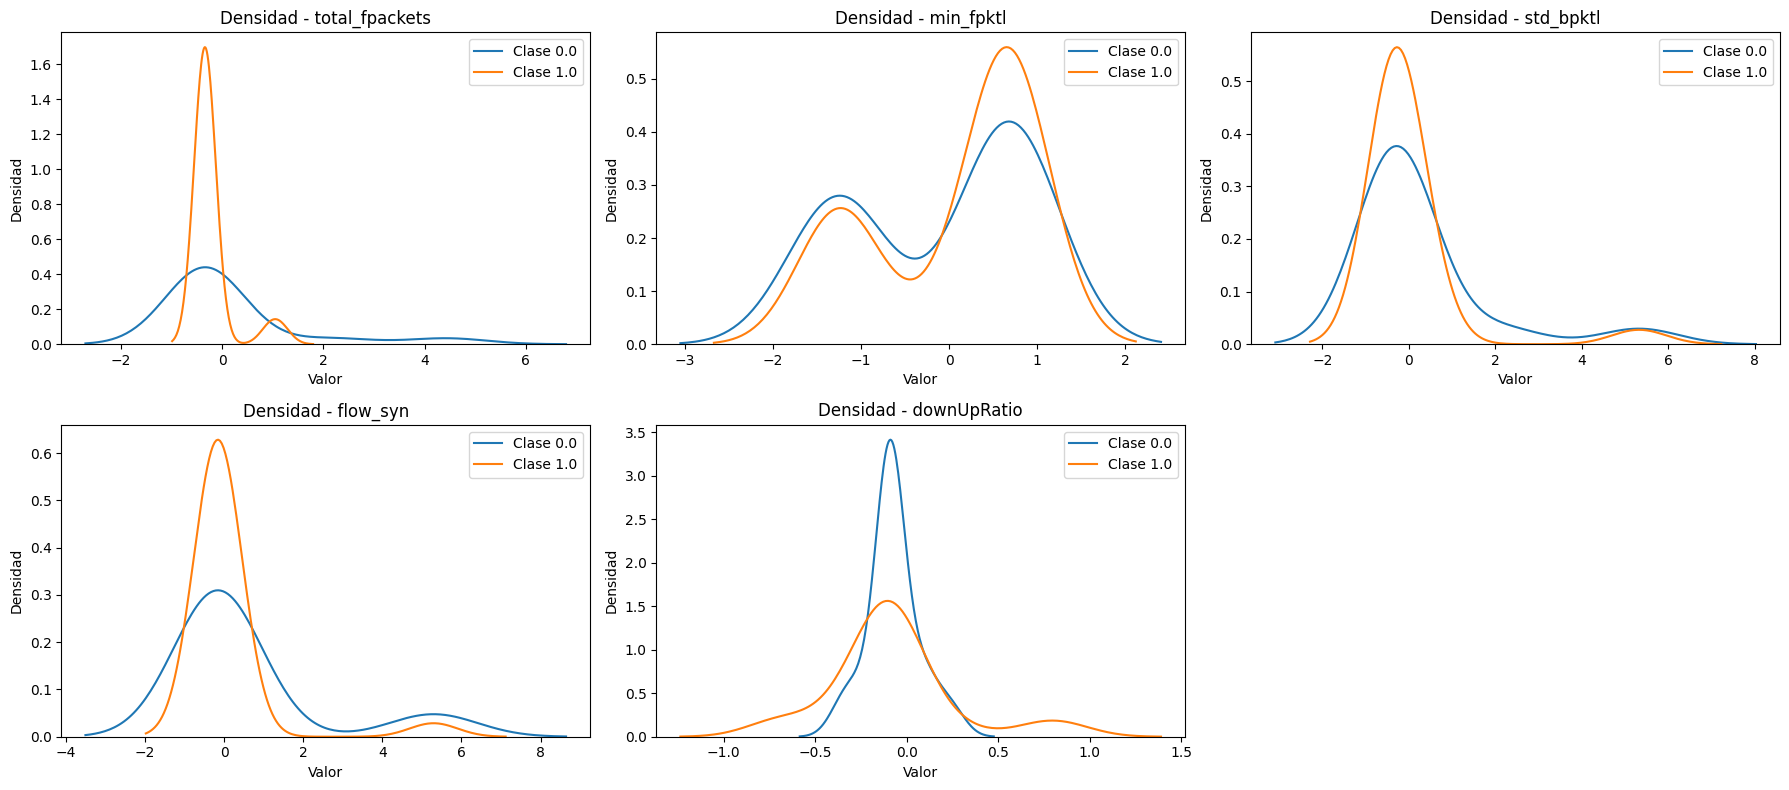

In [76]:
# Alinear índices
y_testrfe_series = pd.Series(y_testrfe, index=X_test_rfe.index)

# Obtener todas las features disponibles
features_to_plot = X_test_rfe.columns
num_features = len(features_to_plot)

# Calcular dinámicamente el layout de subplots (máx. 3 columnas)
cols = 3
rows = math.ceil(num_features / cols)

# Crear figura
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()  # Asegura indexación lineal

for i, feature in enumerate(features_to_plot):
    ax = axs[i]
    data_ok = False
    for label in np.unique(y_testrfe_series):
        subset = X_test_rfe.loc[y_testrfe_series == label, feature]
        if subset.nunique() > 1 and subset.shape[0] > 1:
            sns.kdeplot(subset, label=f"Clase {label}", ax=ax)
            data_ok = True
        elif subset.shape[0] > 0:
            sns.histplot(subset, label=f"Clase {label}", ax=ax, kde=False, stat='density', element='step')
            data_ok = True
    if data_ok:
        ax.set_title(f"Densidad - {feature}")
        ax.set_xlabel("Valor")
        ax.set_ylabel("Densidad")
        ax.legend()
    else:
        ax.set_visible(False)

# Ocultar subplots sobrantes
for j in range(num_features, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

#### Entrenando modelo RL con GridSearchCV y RFE

In [77]:
start=perf_counter()

# Entrenar el modelo de regresión logística con las características seleccionadas y los hiperparámetros óptimos
model = LogisticRegression(C=rlgs.best_params_['estimator__C'], penalty=rlgs.best_params_['estimator__penalty'],
                           class_weight='balanced', solver='saga', max_iter=1500)
model.fit(X_train_rfe, y_trainrfe)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

# Predecir y evaluar el modelo
y_predrlgs = model.predict(X_test_rfe)
accuracy = roc_auc_score(y_testrfe, y_predrlgs)
print("Best Parameters:", rlgs.best_params_)
print("Score:", rlgs.best_score_)

Elapsed time: 0.00 min.
Best Parameters: {'estimator__C': np.float64(1.0), 'estimator__penalty': 'l2'}
Score: 0.9886446413159982


              precision    recall  f1-score   support

     class 0       0.97      0.99      0.98        72
     class 1       0.99      0.98      0.99       127

    accuracy                           0.98       199
   macro avg       0.98      0.99      0.98       199
weighted avg       0.99      0.98      0.98       199



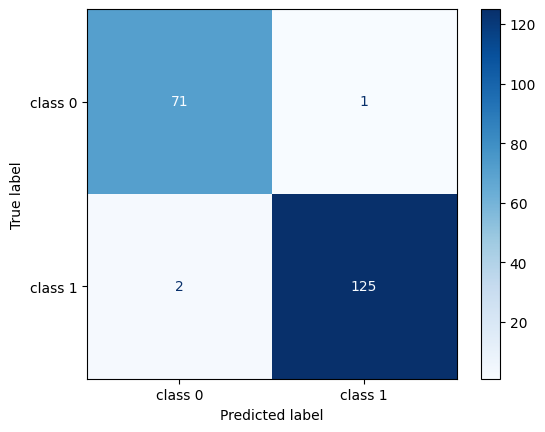

In [78]:
#performance results
print(classification_report(y_testrfe, y_predrlgs, target_names=target_names))

cm = confusion_matrix(y_testrfe, y_predrlgs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

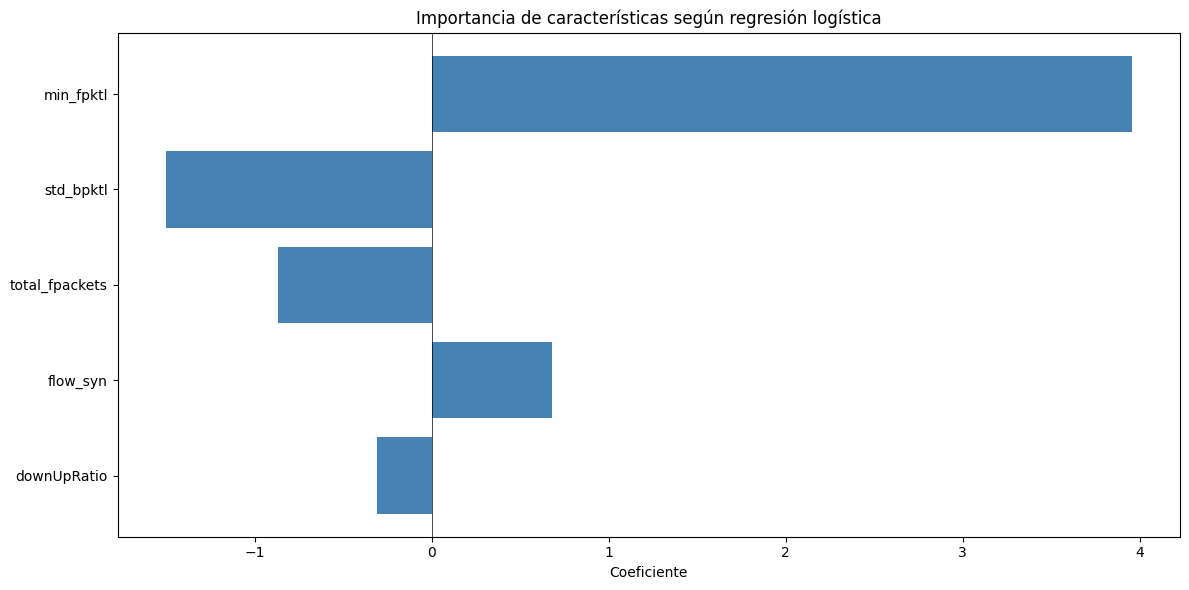

In [79]:
coef = model.coef_.flatten()

# Asociar cada coeficiente con su variable
importancia_df = pd.DataFrame({
    'feature': X_train_rfe.columns,
    'coef': coef,
    'abs_coef': np.abs(coef)
}).sort_values('abs_coef', ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
plt.barh(importancia_df['feature'], importancia_df['coef'], color='steelblue')
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Coeficiente")
plt.title("Importancia de características según regresión logística")
plt.gca().invert_yaxis()  # Coloca las más importantes arriba
plt.tight_layout()
plt.show()

In [80]:
df_resultados = pd.DataFrame({
    'Clase': RFE_test,
    'Real': y_testrfe,
    'Predicción': y_predrlgs
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Segundo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")


Totales por clase: 
 1    127
0     72
Name: Segundo, dtype: int64
Aciertos de Predicción:
 1    125
0     71
Name: Segundo, dtype: int64
Errores de Predicción:
 0    1
Name: Segundo, dtype: int64
Total Correctas: 196, Total Errores: 3


In [81]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testrfe, y_predrlgs))

El coeficiente de correlacion de Matthews es de  0.9675104627237485


### 3.- RL con Optuna sin RFE

In [82]:
start=perf_counter()
# Define la función objetivo
def objective(trial):
    # Define el espacio de búsqueda de hiperparámetros
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_loguniform("C", 1e-2, 1000)

    # Crea el modelo con los hiperparámetros sugeridos
    rlo = LogisticRegression(penalty=penalty, C=C, solver='saga',random_state=42)

    # Entrena el modelo
    rlo.fit(df_X_train_stand,y_train)

    # Predice en el conjunto de prueba
    y_predrlo = rlo.predict(df_X_test_stand)

    # Calcula la métrica de rendimiento (recall)
    scoreopsrfe = matthews_corrcoef(y_test, y_predrlo)

    return scoreopsrfe


In [83]:
# Crea el estudio de optimización
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study = optuna.create_study(direction='maximize',sampler=TPESampler())
study.optimize(objective, n_trials=300)

# Obtiene los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

# Entrena el modelo con los mejores hiperparámetros encontrados
best_modelrlo = LogisticRegression(**best_params, solver='saga',random_state=42)
best_modelrlo.fit(df_X_train_stand, y_train)

# Predice en el conjunto de prueba

y_predbrlo = best_modelrlo.predict(df_X_test_stand)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

Mejores hiperparámetros: {'penalty': 'l1', 'C': 11.389897089411999}
Elapsed time: 0.15 min.


              precision    recall  f1-score   support

     class 0       1.00      0.99      1.00       150
     class 1       1.00      1.00      1.00       222

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



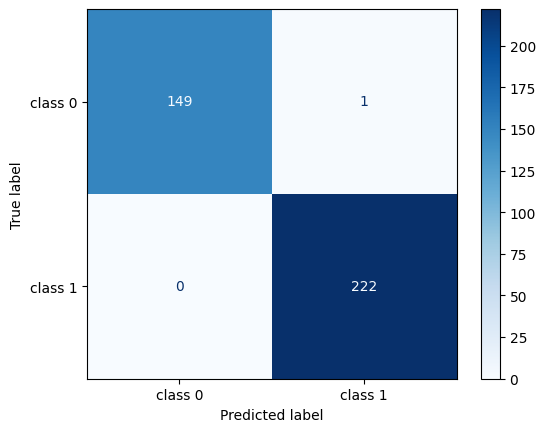

In [84]:
#performance results
print(classification_report(y_test, y_predbrlo, target_names=target_names))

cm = confusion_matrix(y_test, y_predbrlo)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

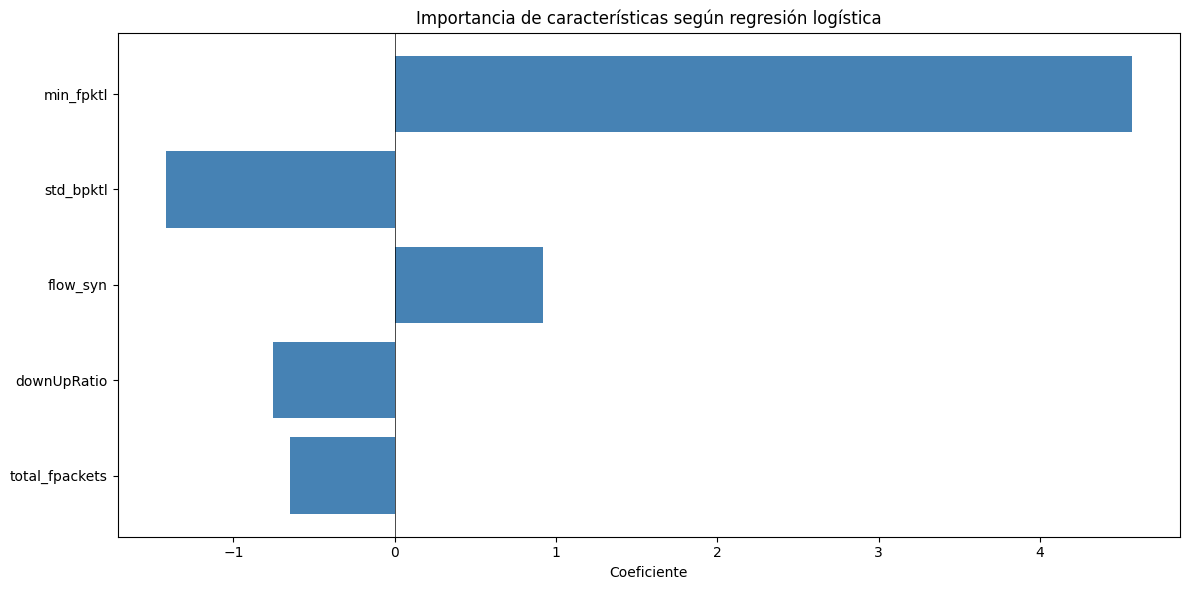

In [85]:
# Obtener coeficientes del estimador dentro de RFECV
coef = best_model.estimator_.coef_.flatten()

# Asociar cada coeficiente con su variable seleccionada
selected_features = df_X_train_stand.columns[best_model.support_]


# Asociar cada coeficiente con su variable
importancia_df = pd.DataFrame({
    'feature': selected_features,
    'coef': coef,
    'abs_coef': np.abs(coef)
}).sort_values('abs_coef', ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
plt.barh(importancia_df['feature'], importancia_df['coef'], color='steelblue')
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Coeficiente")
plt.title("Importancia de características según regresión logística")
plt.gca().invert_yaxis()  # Coloca las más importantes arriba
plt.tight_layout()
plt.show()

In [86]:
df_resultados = pd.DataFrame({
    'Clase': A_test,
    'Real': y_test,
    'Predicción': y_predbrlo
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Tercero'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 1    222
0    150
Name: Tercero, dtype: int64
Aciertos de Predicción:
 1    222
0    149
Name: Tercero, dtype: int64
Errores de Predicción:
 0    1
Name: Tercero, dtype: int64
Total Correctas: 371, Total Errores: 1


In [87]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_test, y_predbrlo))

El coeficiente de correlacion de Matthews es de  0.9944239155243684


### 4.- RL con Optuna y RFE

In [88]:
start=perf_counter()
# Define la función objetivo
def objective(trial):
    # Define el espacio de búsqueda de hiperparámetros
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_loguniform("C", 1e-3, 100)

    # Crea el modelo con los hiperparámetros sugeridos
    rlo = LogisticRegression(penalty=penalty, C=C, solver='saga',random_state=42)

    # Entrena el modelo
    rlo.fit(X_train_rfe,y_trainrfe)

    # Predice en el conjunto de prueba
    y_predrlorfe = rlo.predict(X_test_rfe)

    # Calcula la métrica de rendimiento (recall)
    scorerfe = matthews_corrcoef(y_testrfe, y_predrlorfe)

    return scorerfe


Mejores hiperparámetros: {'penalty': 'l2', 'C': 0.009962513222055111}
Elapsed time: 0.08 min.
              precision    recall  f1-score   support

     class 0       0.97      1.00      0.99        72
     class 1       1.00      0.98      0.99       127

    accuracy                           0.99       199
   macro avg       0.99      0.99      0.99       199
weighted avg       0.99      0.99      0.99       199



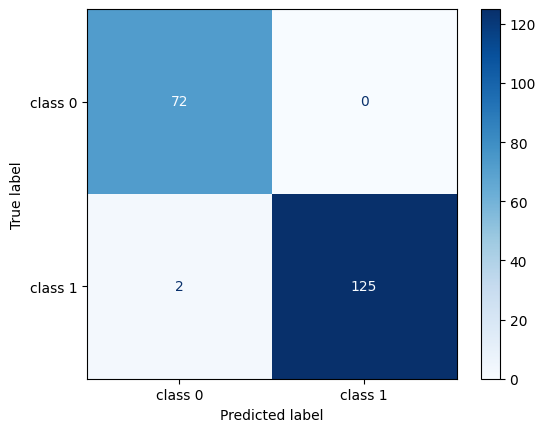

In [89]:
# Crea el estudio de optimización
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
studyrl = optuna.create_study(direction='maximize',sampler=TPESampler(seed=42))
studyrl.optimize(objective, n_trials=500)

# Obtiene los mejores hiperparámetros
best_paramsr = studyrl.best_params
print("Mejores hiperparámetros:", best_paramsr)

# Entrena el modelo con los mejores hiperparámetros encontrados
best_modelrlo = LogisticRegression(**best_paramsr, solver='saga',)
best_modelrlo.fit(X_train_rfe, y_trainrfe)

# Predice en el conjunto de prueba

y_predbrlorfe = best_modelrlo.predict(X_test_rfe)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

#performance results
print(classification_report(y_testrfe, y_predbrlorfe, target_names=target_names))

cm = confusion_matrix(y_testrfe, y_predbrlorfe)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

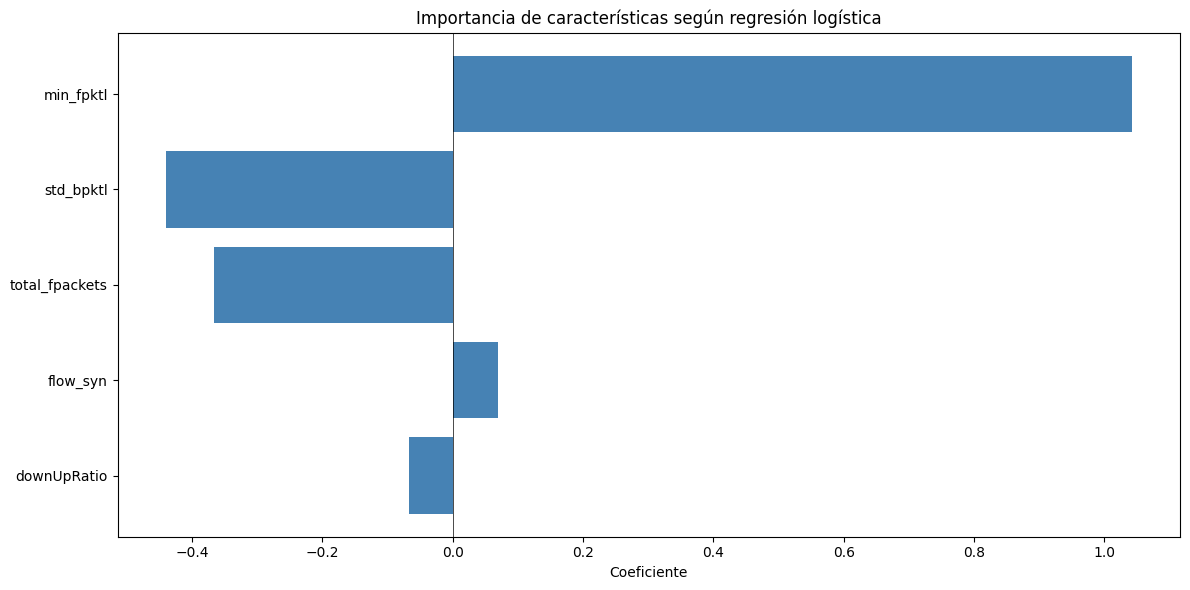

In [90]:
coef = best_modelrlo.coef_.flatten()

# Asociar cada coeficiente con su variable
importancia_df = pd.DataFrame({
    'feature': X_train_rfe.columns,
    'coef': coef,
    'abs_coef': np.abs(coef)
}).sort_values('abs_coef', ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
plt.barh(importancia_df['feature'], importancia_df['coef'], color='steelblue')
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Coeficiente")
plt.title("Importancia de características según regresión logística")
plt.gca().invert_yaxis()  # Coloca las más importantes arriba
plt.tight_layout()
plt.show()

In [91]:
df_resultados = pd.DataFrame({
    'Clase': RFE_test,
    'Real': y_testrfe,
    'Predicción': y_predbrlorfe
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Cuarto'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 1    127
0     72
Name: Cuarto, dtype: int64
Aciertos de Predicción:
 1    125
0     72
Name: Cuarto, dtype: int64
Errores de Predicción:
 0   NaN
Name: Cuarto, dtype: float64
Total Correctas: 197, Total Errores: 2


In [92]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testrfe, y_predbrlorfe))

El coeficiente de correlacion de Matthews es de  0.9785962210992727


## 5 a 7 Decision Tree

### 5.- DT Base

In [93]:
start=perf_counter()

# Defining an object for DTC and fitting for whole dataset
dt = DecisionTreeClassifier(random_state=42)
dt.fit(df_X_train_stand, y_train)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

Elapsed time: 0.00 min.


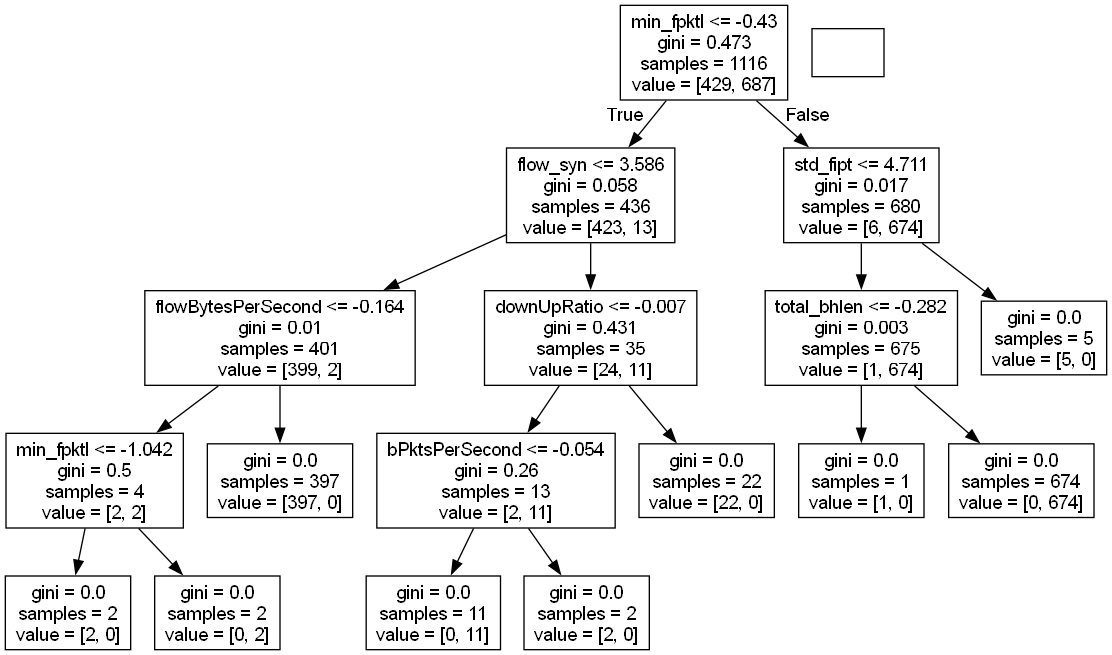

In [94]:
# Conjunto de variables predictoras
X = df_train_f.copy()
X.drop(['label', 'Ataque'],axis=1,inplace=True)

features = X.columns
dot_data = export_graphviz(dt, out_file=None, feature_names=features)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [95]:
# Testing model
y_preddt = dt.predict(df_X_test_stand)
y_probdt = dt.predict_proba(df_X_test_stand)
print('Accuracy of Decision Tree-Test: ', accuracy_score(y_preddt, y_test))

Accuracy of Decision Tree-Test:  0.9973118279569892


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       150
           1       1.00      1.00      1.00       222

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



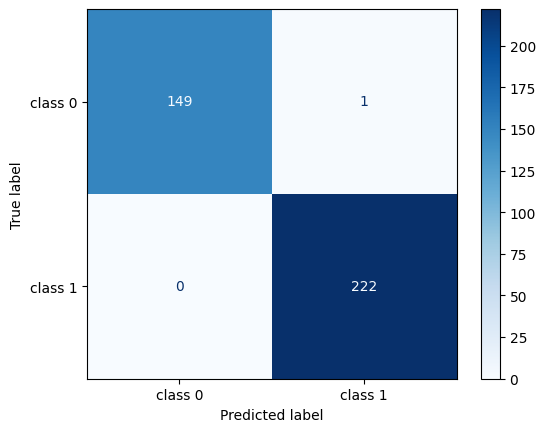

In [96]:
#Classification for test before hyperparameter tuning
print(classification_report(y_test,y_preddt))
ConfusionMatrixDisplay.from_predictions(y_test, y_preddt, display_labels=target_names, cmap=plt.cm.Blues)

In [97]:
df_resultados = pd.DataFrame({
    'Clase': A_test,
    'Real': y_test,
    'Predicción': y_preddt
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Quinto'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 1    222
0    150
Name: Quinto, dtype: int64
Aciertos de Predicción:
 1    222
0    149
Name: Quinto, dtype: int64
Errores de Predicción:
 0    1
Name: Quinto, dtype: int64
Total Correctas: 371, Total Errores: 1


In [98]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_test, y_preddt))

El coeficiente de correlacion de Matthews es de  0.9944239155243684


### 6.- DT con Feature Importances
####  Seleccion de Features

Calculamos la `feature_iportances_` obtenida con el modelo anterior

In [99]:
df_X_test_stand.columns[:]

Index(['total_fpackets', 'min_fpktl', 'std_bpktl', 'total_bipt', 'min_fipt',
       'min_bipt', 'std_fipt', 'std_bipt', 'total_bhlen', 'bPktsPerSecond',
       'flowBytesPerSecond', 'mean_flowipt', 'flow_fin', 'flow_syn',
       'flow_ack', 'downUpRatio'],
      dtype='object')

In [100]:
feature_importances = dt.feature_importances_
feature_importances = pd.DataFrame([feature_importances], columns=df_X_test_stand.columns[:])


Creamos un duplicado de nuestros conjuntos de entrenamiento y testing

In [101]:
feature_importances


total_fpackets  min_fpktl  std_bpktl  total_bipt  min_fipt  min_bipt  \
0             0.0   0.933509        0.0         0.0       0.0       0.0   

   std_fipt  std_bipt  total_bhlen  bPktsPerSecond  flowBytesPerSecond  \
0  0.018738       0.0     0.003781        0.006408            0.003749   

   mean_flowipt  flow_fin  flow_syn  flow_ack  downUpRatio  
0           0.0       0.0  0.011661       0.0     0.022154

Ordenamos por importancia

In [102]:
feature_importances_transposed = feature_importances.transpose()

# Renombrar la columna
feature_importances_transposed.columns = ['importance']

# Ordenar las características de mayor a menor importancia
sorted_features = feature_importances_transposed.sort_values(by='importance', ascending=False)

sorted_features=sorted_features.transpose()
sorted_features

min_fpktl  downUpRatio  std_fipt  flow_syn  bPktsPerSecond  \
importance   0.933509     0.022154  0.018738  0.011661        0.006408   

            total_bhlen  flowBytesPerSecond  std_bpktl  std_bipt  min_bipt  \
importance     0.003781            0.003749        0.0       0.0       0.0   

            min_fipt  total_bipt  total_fpackets  mean_flowipt  flow_fin  \
importance       0.0         0.0             0.0           0.0       0.0   

            flow_ack  
importance       0.0

Aplicamos el siguiente ciclo for para eliminar las columnas con una importancia de 0

In [103]:
Xfitrain = pd.DataFrame()
Xfitest  = pd.DataFrame()
fidt     = pd.DataFrame()
dffi     = pd.DataFrame()

ncol=feature_importances.shape[1]

for i in range(0, ncol):
    if(feature_importances.at[0,feature_importances.columns[i]]>0.01):
        Xfitrain[feature_importances.columns[i]]= df_X_train_stand[feature_importances.columns[i]]
        Xfitest[feature_importances.columns[i]]= df_X_test_stand[feature_importances.columns[i]]
        dffi[feature_importances.columns[i]]= df_train_f[feature_importances.columns[i]]
        fidt[feature_importances.columns[i]] = feature_importances[feature_importances.columns[i]]

print(feature_importances.shape)
fidt

(1, 16)


min_fpktl  std_fipt  flow_syn  downUpRatio
0   0.933509  0.018738  0.011661     0.022154

#### VIF Feature Importance

A las features clasificadas con el metodo `feature_iportances_` le calculamos la multicolinealidad por medio de `VIF`

In [104]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = Xfitrain.columns

# calcular VIF de cada característica
vif_data["VIF"] = [variance_inflation_factor(Xfitrain.values, i)
    for i in range(len(Xfitrain.columns))]

print(vif_data)

       feature       VIF
0    min_fpktl  1.098646
1     std_fipt  1.047357
2     flow_syn  1.045370
3  downUpRatio  1.005401


Observamos niveles altos de multicolinealidad, procedemos a eliminar de manera automatica las features con niveles altos de VIF y bajos niveles de importancia

In [105]:
def filtrar_vif_bajo_importancia_DT(X_train_selected, importancia_series, umbral=10.0):
    X = X_train_selected.copy()
    imp_serie = importancia_series.copy()
    eliminadas = []

    while True:
        vif_actual = pd.Series(
            [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
            index=X.columns
        )

        variables_con_vif_alto = vif_actual[vif_actual > umbral]
        if variables_con_vif_alto.empty:
            break

        # Buscar la de menor importancia
        candidatas = pd.DataFrame({
            'vif': variables_con_vif_alto,
            'importance': imp_serie[variables_con_vif_alto.index]
        })
        col_a_eliminar = candidatas.sort_values('importance').index[0]

        print(f"Eliminando '{col_a_eliminar}' con VIF = {variables_con_vif_alto[col_a_eliminar]:.2f} e importancia = {imp_serie[col_a_eliminar]:.4f}")

        X = X.drop(columns=[col_a_eliminar])
        imp_serie = imp_serie.drop(index=col_a_eliminar)
        eliminadas.append(col_a_eliminar)

    # VIF final
    vif_data_final = pd.DataFrame({
        "feature": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })

    return X, vif_data_final, eliminadas

In [106]:
# Asegurarse de que solo usamos columnas que sí existen en Xfitrain
columnas_validas = [col for col in feature_importances.columns if col in Xfitrain.columns]

# Aplicar solo las columnas válidas
feature_importances_filtradas = feature_importances[columnas_validas]

In [107]:
importancia_series = feature_importances_filtradas.transpose().iloc[:, 0]
X_train_filtrado, vif_datos_final, eliminadas = filtrar_vif_bajo_importancia_DT(Xfitrain[importancia_series.index], importancia_series)


In [108]:
X_train_filtrado.columns

Index(['min_fpktl', 'std_fipt', 'flow_syn', 'downUpRatio'], dtype='object')

In [109]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_filtrado.columns

# calcular VIF de cada característica
vif_data["VIF"] = [variance_inflation_factor(X_train_filtrado.values, i)
    for i in range(len(X_train_filtrado.columns))]

print(vif_data)

       feature       VIF
0    min_fpktl  1.098646
1     std_fipt  1.047357
2     flow_syn  1.045370
3  downUpRatio  1.005401


Reduciendo asi los valores a niveles aceptables de multicolinealidad <5

Dado que se redujeron las features volvemos a realizar el preprocesamiento de los datos para descartar datos duplicados.

#### Creacion de conjunto de datos con feature importance

In [110]:
columnas_utiles = list(X_train_filtrado.columns) + ['label']

# Crear el nuevo DataFrame con esas columnas
dffi = df_train_f[columnas_utiles].copy()


print(dffi.shape)


dffi.reset_index(drop=True, inplace=True)
df_train_f.reset_index(drop=True, inplace=True)
dffi['label']=df_train_f['label'].astype('int')
print("NaN, :", df_train_f['label'].isna().sum())
print("NaNd, :", dffi['label'].isna().sum())

print(dffi.shape)
dffi['Ataque']=df_train_f['Ataque']
print("Con Ataque ", dffi.shape)


print("Duplicados",dffi.drop(['label','Ataque'],axis=1,inplace=False).duplicated().sum())

# Eliminar duplicados en todas las columnas excepto 'label' y 'Ataque'
dffi_cleaned = dffi.drop(['label', 'Ataque'], axis=1).duplicated(keep='first')

# Filtrar el DataFrame original solo por las filas no duplicadas
dffi_cleaned = dffi[~dffi_cleaned]
dffi=dffi_cleaned.copy()

print("Duplicados D",dffi.drop(['label','Ataque'],axis=1,inplace=False).duplicated().sum())


print("Dimensiones suboconjunto Fi: ", dffi.shape)
print("NaN, :", dffi['label'].isna().sum())

#Splitting
X_train_fi,X_test_fi,y_trainfi,y_testfi = train_test_split(dffi.drop(columns=['label']), dffi['label'], test_size=0.25, random_state=42)

print("Antes X_train_fi: ", X_train_fi.shape, "X_test_fi: ", X_test_fi.shape)
FI_train=X_train_fi['Ataque']
X_train_fi=X_train_fi.drop(['Ataque'],axis=1)
FI_test=X_test_fi['Ataque']
X_test_fi=X_test_fi.drop(['Ataque'],axis=1)
print("Despues X_train_fi: ", X_train_fi.shape, "X_test_fi: ", X_test_fi.shape)
print("Con FI_train: ", FI_train.shape, "FI_test: ", FI_test.shape)

#Estandarizacion
numeric_cols = X_train_fi.select_dtypes(include=['float64', 'int']).columns.to_list()
preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_cols)], remainder='passthrough')

labels=list(X_train_fi.columns.values.tolist())
# fit on the trainning dataset
preprocessor.fit_transform(X_train_fi)
X_train_fi = preprocessor.transform(X_train_fi)
X_test_fi  = preprocessor.transform(X_test_fi)
#The result returned by ColumnTransformer is a numpy array, so the column names are lost.
X_train_fi=pd.DataFrame(X_train_fi,columns=labels)
X_test_fi=pd.DataFrame(X_test_fi,columns=labels)


(1488, 5)
NaN, : 0
NaNd, : 0
(1488, 5)
Con Ataque  (1488, 6)
Duplicados 185
Duplicados D 0
Dimensiones suboconjunto Fi:  (1303, 6)
NaN, : 0
Antes X_train_fi:  (977, 5) X_test_fi:  (326, 5)
Despues X_train_fi:  (977, 4) X_test_fi:  (326, 4)
Con FI_train:  (977,) FI_test:  (326,)


In [111]:
print("Subconjunto Recursive Feature Elimination (RFE): ",dfrfe.shape)
print("Subconjunto Feature Importance (FI): ",dffi.shape)

Subconjunto Recursive Feature Elimination (RFE):  (794, 7)
Subconjunto Feature Importance (FI):  (1303, 6)


In [112]:
print("Nuevas dimensiones conjunto train: ", X_train_fi.shape, "y test: ", X_test_fi.shape)

Nuevas dimensiones conjunto train:  (977, 4) y test:  (326, 4)


In [113]:
y_trainfi.head()

326     1
1304    0
1405    0
600     1
306     1
Name: label, dtype: int64

#### Analisis de densidad FI

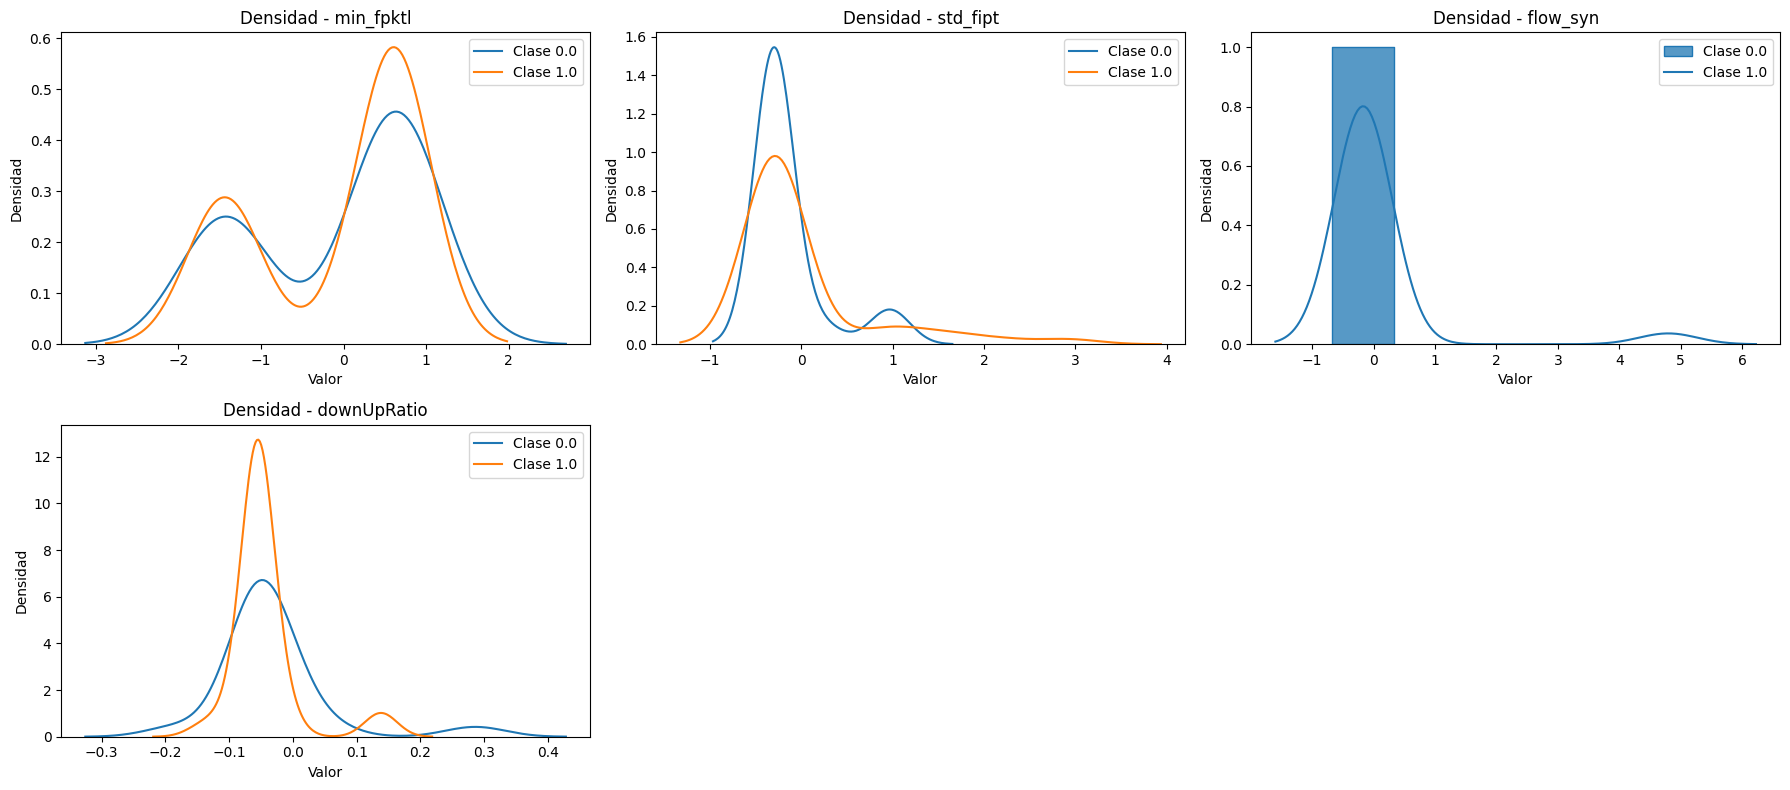

In [114]:
# Alinear índices
y_testfi_series = pd.Series(y_testfi, index=X_test_fi.index)

# Tomar todas las features disponibles
features_to_plot = X_test_fi.columns
num_features = len(features_to_plot)

# Calcular automáticamente filas y columnas (máximo 3 columnas por fila)
cols = 3
rows = math.ceil(num_features / cols)

# Preparar figura
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()

# Graficar
for i, feature in enumerate(features_to_plot):
    ax = axs[i]
    data_ok = False
    for label in np.unique(y_testfi_series):
        subset = X_test_fi.loc[y_testfi_series == label, feature]
        if subset.nunique() > 1 and subset.shape[0] > 1:
            sns.kdeplot(subset, label=f"Clase {label}", ax=ax)
            data_ok = True
        elif subset.shape[0] > 0:
            sns.histplot(subset, label=f"Clase {label}", ax=ax, kde=False, stat='density', element='step')
            data_ok = True
    if data_ok:
        ax.set_title(f"Densidad - {feature}")
        ax.set_xlabel("Valor")
        ax.set_ylabel("Densidad")
        ax.legend()
    else:
        ax.set_visible(False)

# Ocultar subplots vacíos si sobran
for j in range(num_features, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

#### Entrenado modelo con FI

Con esto, volvemos a entrenar el modelo DecisionTree

In [115]:
start=perf_counter()


dtfi = DecisionTreeClassifier(random_state=42)
dtfi.fit(X_train_fi, y_trainfi)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

Elapsed time: 0.00 min.


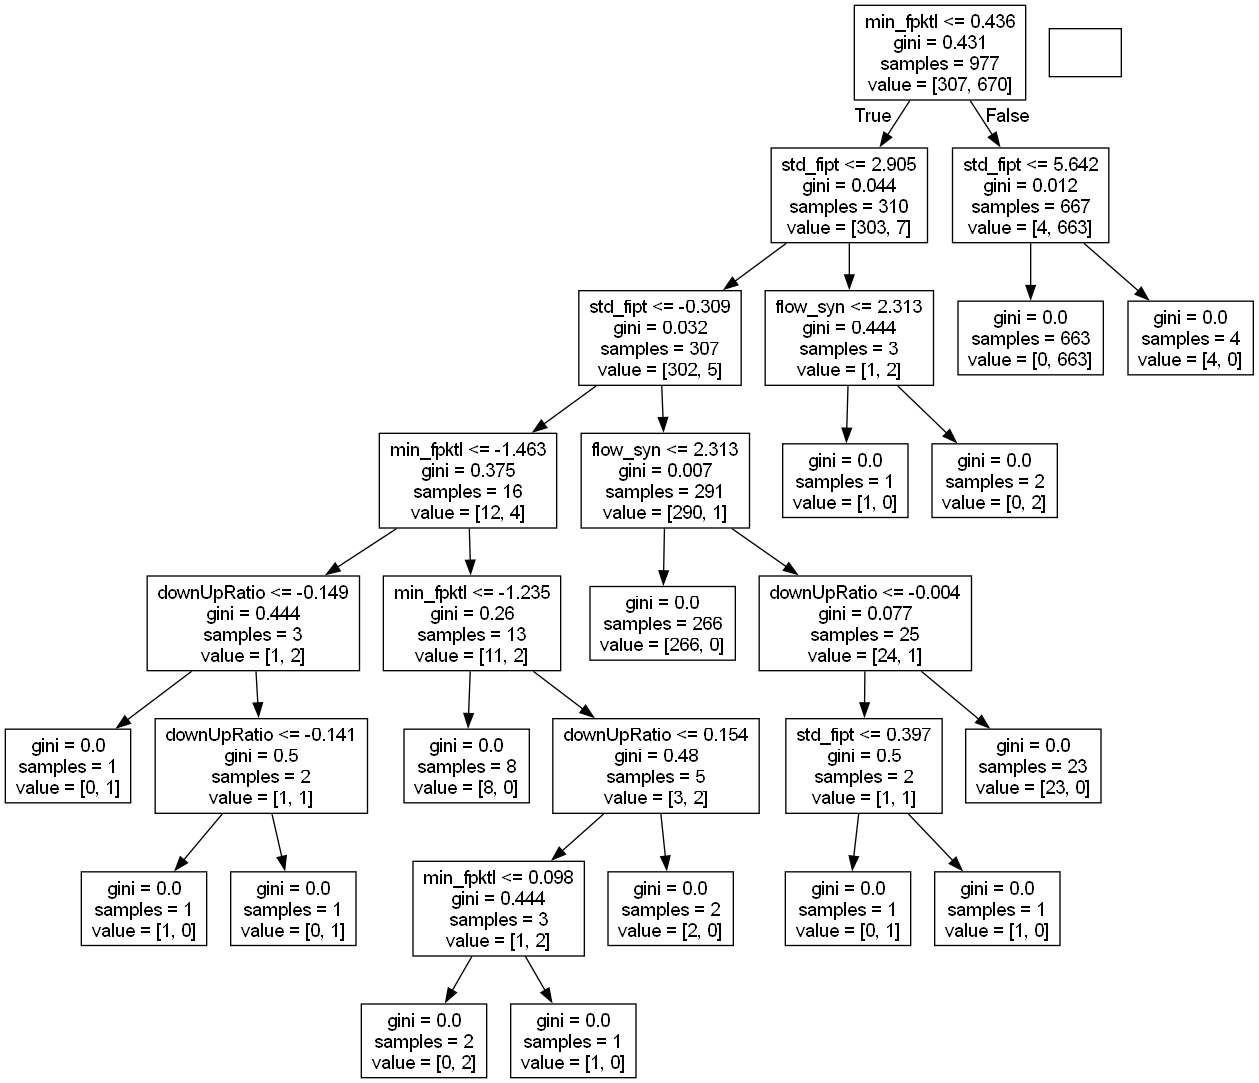

In [116]:
features = X_train_fi.columns
dot_data = export_graphviz(dtfi, out_file=None, feature_names=features)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [117]:
# Testing model
y_preddtfi = dtfi.predict(X_test_fi)
y_probdtfi = dtfi.predict_proba(X_test_fi)
print('Accuracy of Decision Tree-Test: ', accuracy_score(y_preddtfi, y_testfi))

Accuracy of Decision Tree-Test:  1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      1.00      1.00       225

    accuracy                           1.00       326
   macro avg       1.00      1.00      1.00       326
weighted avg       1.00      1.00      1.00       326



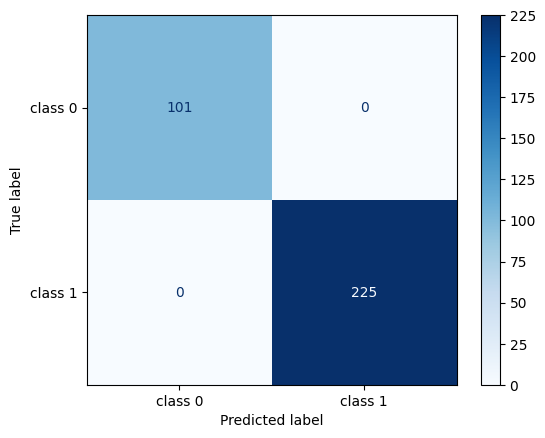

In [118]:
#Classification for test before hyperparameter tuning
print(classification_report(y_testfi,y_preddtfi))
ConfusionMatrixDisplay.from_predictions(y_testfi, y_preddtfi, display_labels=target_names, cmap=plt.cm.Blues)

In [119]:
df_resultados = pd.DataFrame({
    'Clase': FI_test,
    'Real': y_testfi,
    'Predicción': y_preddtfi
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Sexto'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 1    225
0    101
Name: Sexto, dtype: int64
Aciertos de Predicción:
 1    225
0    101
Name: Sexto, dtype: int64
Errores de Predicción:
 0    NaN
Name: Sexto, dtype: object
Total Correctas: 326, Total Errores: 0


In [120]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testfi, y_preddtfi))

El coeficiente de correlacion de Matthews es de  1.0


Con la seleccion de features aumentamos la Accuracy del modelo de **0.9635** a **0.9673**, procedemos a implementar tecnicas de optimizacion de hiperparametros buscando hacer el modelo mas eficiente

### 7.- DT con GridSearchCV y FI

Los hiperparametros que se pueden ajustar en los Arboles de Decision son los siguientes
- min_samples_split – Minimum number of samples a node must possess before splitting.
- min_samples_leaf – Minimum number of samples a leaf node must possess.
- min_weight_fraction_leaf – Minimum fraction of the sum total of weights required to be at a leaf node.
- max_leaf_nodes – Maximum number of leaf nodes a decision tree can have.
- max_features – Maximum number of features that are taken into the account for splitting each node.


In [121]:
# Hyperparameter Tuning of DTC
start=perf_counter()

dtop = DecisionTreeClassifier(class_weight='balanced',random_state=42)

params = {'criterion': ['gini', 'entropy', 'log_loss'],
          'max_depth' : ['None',2,3,4,5],
          'min_samples_split': [2,3,4,5],
          'min_samples_leaf': [1,2,3,4,5],
          'max_leaf_nodes': list(range(2,10))}

gsearchdtop = GridSearchCV(dtop, param_grid=params, n_jobs=-1, cv=5)

gsearchdtop.fit(X_train_fi, y_trainfi)

print("Best Parameters:", gsearchdtop.best_params_)

mdtop = DecisionTreeClassifier(criterion=gsearchdtop.best_params_['criterion'], max_depth=gsearchdtop.best_params_['max_depth'], min_samples_split=gsearchdtop.best_params_['min_samples_split'], min_samples_leaf=gsearchdtop.best_params_['min_samples_leaf'],max_leaf_nodes=gsearchdtop.best_params_['max_leaf_nodes'],
                           class_weight='balanced',random_state=42)
mdtop.fit(X_train_fi, y_trainfi)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

# Predecir y evaluar el modelo
y_preddtop = mdtop.predict(X_test_fi)
accuracy = accuracy_score(y_testfi, y_preddtop)
print("Accuracy:", accuracy)

Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}
Elapsed time: 0.12 min.
Accuracy: 0.9815950920245399


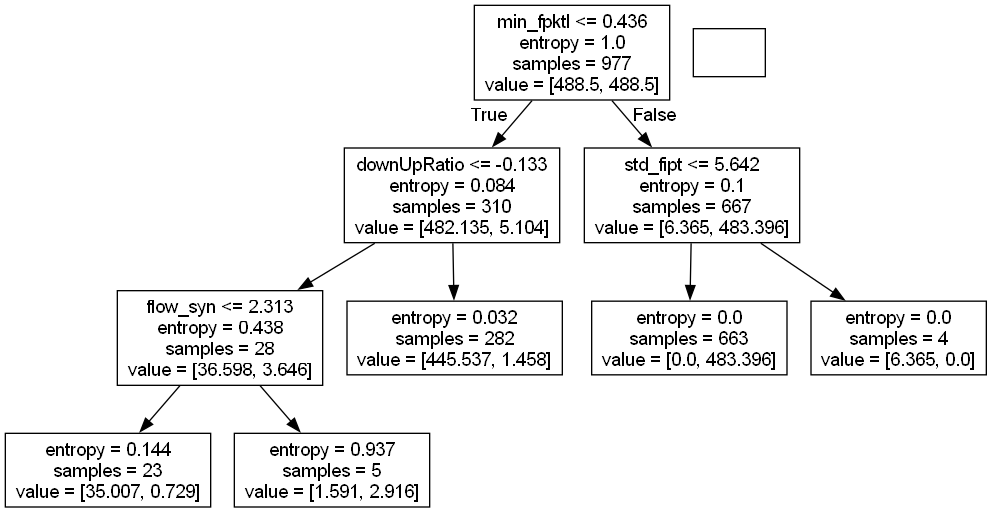

In [122]:
features = X_train_fi.columns
dot_data = export_graphviz(mdtop, out_file=None, feature_names=features)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       101
           1       1.00      0.97      0.99       225

    accuracy                           0.98       326
   macro avg       0.97      0.99      0.98       326
weighted avg       0.98      0.98      0.98       326



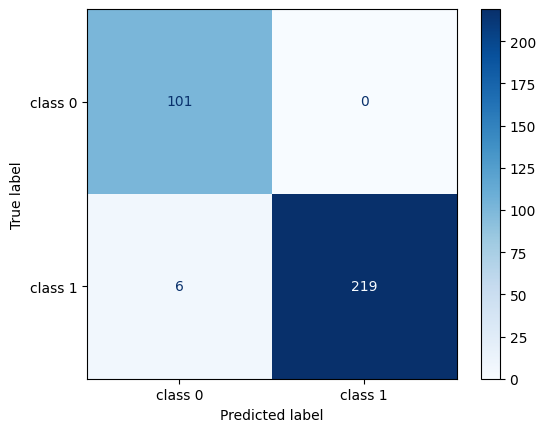

In [123]:
#Classification for test before hyperparameter tuning
print(classification_report(y_testfi,y_preddtop))
ConfusionMatrixDisplay.from_predictions(y_testfi, y_preddtop, display_labels=target_names, cmap=plt.cm.Blues)

In [124]:
df_resultados = pd.DataFrame({
    'Clase': FI_test,
    'Real': y_testfi,
    'Predicción': y_preddtop
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Septimo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 1    225
0    101
Name: Septimo, dtype: int64
Aciertos de Predicción:
 1    219
0    101
Name: Septimo, dtype: int64
Errores de Predicción:
 0   NaN
Name: Septimo, dtype: float64
Total Correctas: 320, Total Errores: 6


In [125]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testfi, y_preddtop))

El coeficiente de correlacion de Matthews es de  0.9585165069423671


## 8 - 9 XGBoost

### 8.- XGBoost con GridSearch y RFE

Fitting 5 folds for each of 1680 candidates, totalling 8400 fits
Elapsed time: 1.20 min.
Best Parameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.01), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(3), max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=np.int64(166), n_jobs=None,
              num_parallel_tree=None, ...)
Score: 0.984873949579832
Classification Report:
               precision    recall  f1-scor

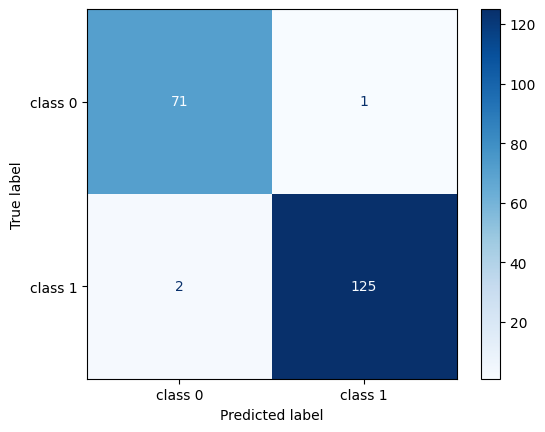

In [126]:
start=perf_counter()
# Definir el estimador base para la regresión logística con selección de características RFE
selectxg = XGBClassifier()

# Inicializar el selector RFE

# Definir el espacio de búsqueda de parámetros para Grid Search
parameters = {
    'objective':["binary:logistic","binary:logitraw","binary:hinge"],
    'n_estimators': np.logspace(2, 3, 10).astype(int),
    'max_depth': np.arange(2,10),
    'learning_rate': np.linspace(0.01, 1, 7)
   }

# Inicializar Grid Search con Cross Validation
grid_xgbrfe = GridSearchCV(selectxg, parameters, cv=5, n_jobs=-1, verbose=3)

# Ajustar Grid Search a los datos de entrenamiento
grid_xgbrfe.fit(X_train_rfe, y_trainrfe)

# Obtener el mejor modelo
best_xgbmodelrfe = grid_xgbrfe.best_estimator_


tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)


# Predecir y evaluar el modelo
y_predxgbrfe = grid_xgbrfe.predict(X_test_rfe)
print("Best Parameters:", grid_xgbrfe.best_estimator_)
print("Score:", grid_xgbrfe.best_score_)
print("Classification Report:\n", classification_report(y_testrfe, y_predxgbrfe))
ConfusionMatrixDisplay.from_predictions(y_testrfe, y_predxgbrfe, display_labels=target_names, cmap=plt.cm.Blues)

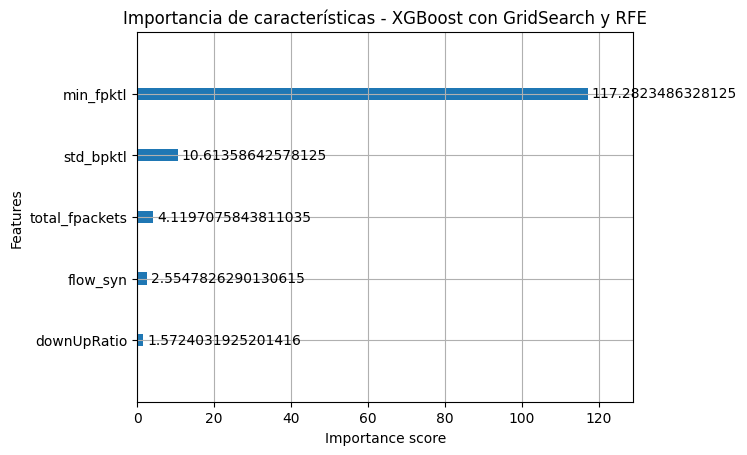

In [127]:
plot_importance(grid_xgbrfe.best_estimator_, importance_type='gain', max_num_features=15)
plt.title("Importancia de características - XGBoost con GridSearch y RFE")
plt.show()

In [128]:
df_resultados = pd.DataFrame({
    'Clase': RFE_test,
    'Real': y_testrfe,
    'Predicción': y_predxgbrfe
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Octavo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 1    127
0     72
Name: Octavo, dtype: int64
Aciertos de Predicción:
 1    125
0     71
Name: Octavo, dtype: int64
Errores de Predicción:
 0    1
Name: Octavo, dtype: int64
Total Correctas: 196, Total Errores: 3


In [129]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testrfe, y_predxgbrfe))

El coeficiente de correlacion de Matthews es de  0.9675104627237485


### 9.- XGBoost con GridSearch y FI

Fitting 5 folds for each of 1680 candidates, totalling 8400 fits
Elapsed time: 1.21 min.
Best Parameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.34), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(2), max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=np.int64(1000), n_jobs=None,
              num_parallel_tree=None, ...)
Score: 0.9938670852956568
Classification Report:
               precision    recall  f1-sc

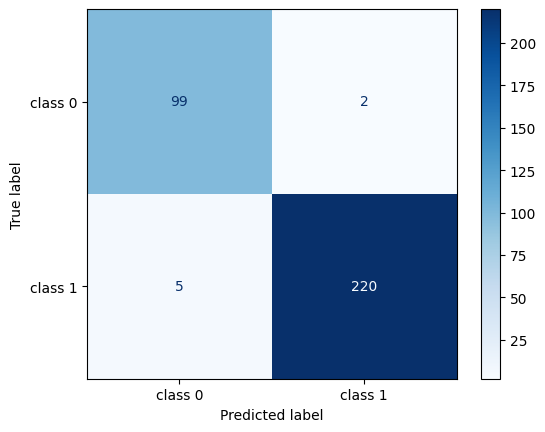

In [130]:
start=perf_counter()
# Definir el estimador base para la regresión logística con selección de características RFE
selectxg = XGBClassifier()

# Inicializar el selector RFE

# Definir el espacio de búsqueda de parámetros para Randomized Search
parameters = {
    'objective':['binary:logistic','binary:logitraw','binary:hinge'],
    'n_estimators': np.logspace(2, 3, 10).astype(int),
    'max_depth': np.arange(2,10),
    'learning_rate': np.linspace(0.01, 1, 7)
   }

# Inicializar Randomized Search con Cross Validation
grid_xgbfi = GridSearchCV(selectxg, parameters, cv=5, n_jobs=-1, verbose=3)

# Ajustar Randomized Search a los datos de entrenamiento
grid_xgbfi.fit(X_train_fi, y_trainfi)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)


# Obtener el mejor modelo
best_xgbmodelfi = grid_xgbfi.best_estimator_


# Predecir y evaluar el modelo
y_predxgbfi = grid_xgbfi.predict(X_test_fi)
accuracy = accuracy_score(y_testfi, y_predxgbfi)
print("Best Parameters:", best_xgbmodelfi)
print("Score:", grid_xgbfi.best_score_)
print("Classification Report:\n", classification_report(y_testfi, y_predxgbfi))
ConfusionMatrixDisplay.from_predictions(y_testfi, y_predxgbfi, display_labels=target_names, cmap=plt.cm.Blues)

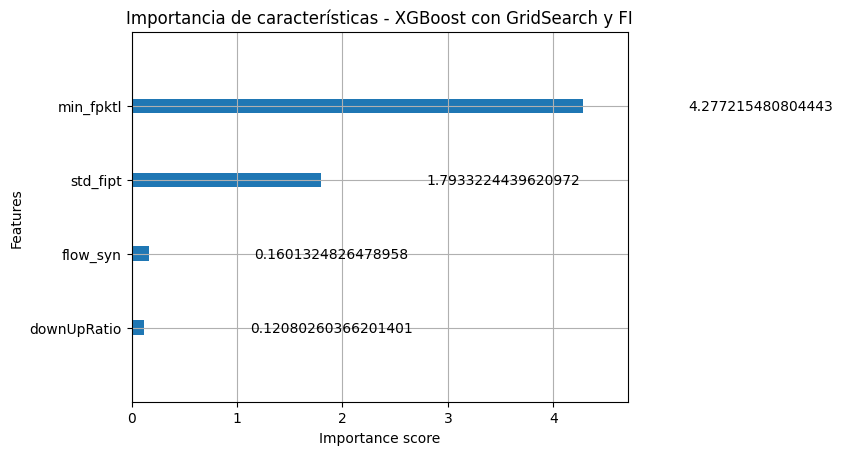

In [131]:
plot_importance(grid_xgbfi.best_estimator_, importance_type='gain', max_num_features=15)
plt.title("Importancia de características - XGBoost con GridSearch y FI")
plt.show()

In [132]:
df_resultados = pd.DataFrame({
    'Clase': FI_test,
    'Real': y_testfi,
    'Predicción': y_predxgbfi
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Noveno'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 1    225
0    101
Name: Noveno, dtype: int64
Aciertos de Predicción:
 1    220
0     99
Name: Noveno, dtype: int64
Errores de Predicción:
 0    2
Name: Noveno, dtype: int64
Total Correctas: 319, Total Errores: 7


In [133]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testfi, y_predxgbfi))

El coeficiente de correlacion de Matthews es de  0.9504150968177817


## 10.- Random Forest

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Elapsed time: 0.47 min.
Mejor modelo accuracy score: 0.9847
Mejores parámetros:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': np.int64(20)}
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       101
           1       1.00      0.98      0.99       225

    accuracy                           0.98       326
   macro avg       0.98      0.99      0.98       326
weighted avg       0.98      0.98      0.98       326



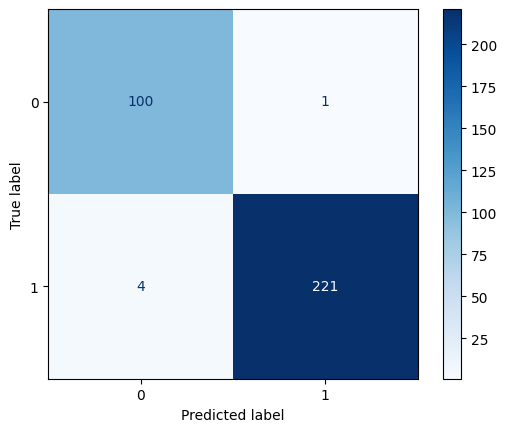

In [134]:

start=perf_counter()

# Define el modelo base a optimizar
clfrf = RandomForestClassifier(random_state=42)

# Define el espacio de búsqueda de parámetros
param_gridrf = {
    'n_estimators': np.linspace(20, 500, 7).astype(int),    # Número de árboles en el bosque
    'max_features': ['auto', 'sqrt', 'log2'],               # Número de características a considerar en cada división
    'max_depth' : [4,6,8,10],                               # Máxima profundidad de cada árbol
    'criterion' :['gini', 'entropy']                        # Medidas de calidad de la división
}

# Crear objeto GridSearchCV
grid_searchrf = GridSearchCV(estimator=clfrf, param_grid=param_gridrf, cv=5, verbose=3, n_jobs=-1)

# Entrenarlo
grid_searchrf.fit(X_train_fi, y_trainfi)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

# Mejor modelo encontrado
best_clfrf = grid_searchrf.best_estimator_

# Predicciones con el mejor modelo
y_predrf = best_clfrf.predict(X_test_fi)

# Evaluar el mejor modelo
print('Mejor modelo accuracy score: {0:0.4f}'. format(accuracy_score(y_testfi, y_predrf)))
print("Mejores parámetros: ", grid_searchrf.best_params_)

print("Classification Report:\n", classification_report(y_testfi, y_predrf))

# Print the Confusion Matrix and slice it into four pieces

ConfusionMatrixDisplay.from_predictions(y_testfi, y_predrf, cmap=plt.cm.Blues);

In [135]:
df_resultados = pd.DataFrame({
    'Clase': FI_test,
    'Real': y_testfi,
    'Predicción': y_predrf
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Decimo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 1    225
0    101
Name: Decimo, dtype: int64
Aciertos de Predicción:
 1    221
0    100
Name: Decimo, dtype: int64
Errores de Predicción:
 0    1
Name: Decimo, dtype: int64
Total Correctas: 321, Total Errores: 5


In [136]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testfi, y_predrf))

El coeficiente de correlacion de Matthews es de  0.9646473118642951


## 11 - 12 Support Vector Machine

### 11.- SVC con RandomizedSearchCV y RFE

In [137]:
start=perf_counter()

svm=LinearSVC(class_weight='balanced', max_iter=10000, dual=False)
# Definir los parámetros para la búsqueda de malla
param_grid = {
    'C': np.logspace(-3, 3, 30)
}
# Realizar la búsqueda de malla con validación cruzada
grid_searchsvmrfe = RandomizedSearchCV(estimator=svm, param_distributions=param_grid,
    n_iter=100,
    scoring='f1_macro',
    n_jobs=-1,
    cv=5,
    verbose=3,
    random_state=42)
grid_searchsvmrfe.fit(X_train_rfe, y_trainrfe)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=LinearSVC(class_weight='balanced', dual=False,
                                       max_iter=10000),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-03, 1.61026203e-03, 2.59294380e-03, 4.17531894e-03,
       6.72335754e-03, 1.08263673e-02, 1.74332882e-02, 2.80721620e-02,
       4.52035366e-02, 7.27895384e-02, 1.17210230e-01, 1.88739182e-01,
       3.03919538e-01, 4.89390092e-01, 7.88046282e-01, 1.26896100e+00,
       2.04335972e+00, 3.29034456e+00, 5.29831691e+00, 8.53167852e+00,
       1.37382380e+01, 2.21221629e+01, 3.56224789e+01, 5.73615251e+01,
       9.23670857e+01, 1.48735211e+02, 2.39502662e+02, 3.85662042e+02,
       6.21016942e+02, 1.00000000e+03])},
                   random_state=42, scoring='f1_macro', verbose=3)

Best Parameters: {'C': np.float64(0.11721022975334805)}
Elapsed time: 0.00 min.
Accuracy: 0.9849246231155779
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.99      0.98      0.99       127

    accuracy                           0.98       199
   macro avg       0.98      0.99      0.98       199
weighted avg       0.99      0.98      0.98       199



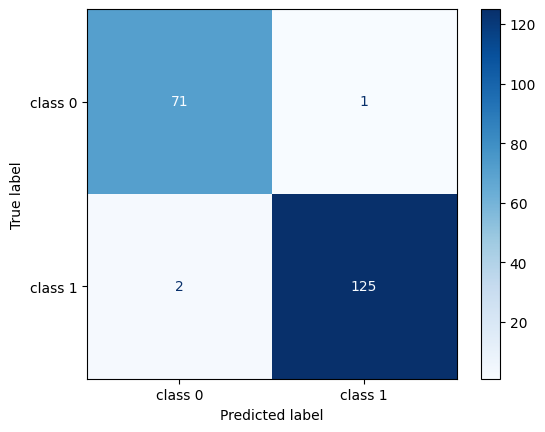

In [138]:
# Imprimir los mejores parámetros encontrados
print("Best Parameters:", grid_searchsvmrfe.best_params_)
# Usar el mejor modelo encontrado para hacer predicciones
best_modelsvmrfe = grid_searchsvmrfe.best_estimator_

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

y_predsvmrfe = best_modelsvmrfe.predict(X_test_rfe)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_testrfe, y_predsvmrfe))
print("Classification Report:\n", classification_report(y_testrfe, y_predsvmrfe))
ConfusionMatrixDisplay.from_predictions(y_testrfe, y_predsvmrfe, display_labels=target_names, cmap=plt.cm.Blues)

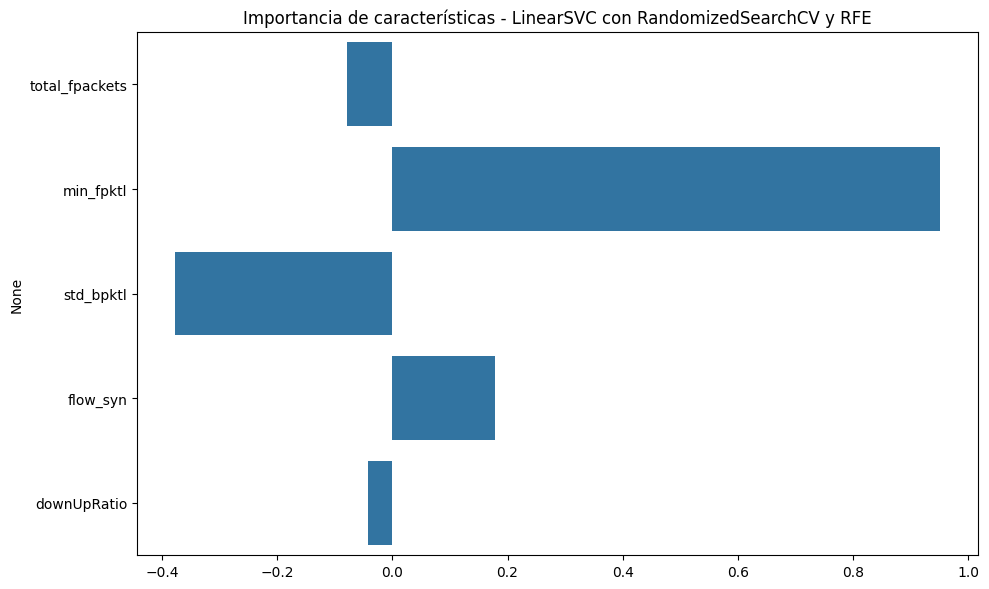

In [139]:
coef = best_modelsvmrfe.coef_.flatten()
plt.figure(figsize=(10, 6))
sns.barplot(x=coef, y=X_test_rfe.columns)
plt.title("Importancia de características - LinearSVC con RandomizedSearchCV y RFE")
plt.tight_layout()
plt.show()

In [140]:
df_resultados = pd.DataFrame({
    'Clase': RFE_test,
    'Real': y_testrfe,
    'Predicción': y_predsvmrfe
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Onceavo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 1    127
0     72
Name: Onceavo, dtype: int64
Aciertos de Predicción:
 1    125
0     71
Name: Onceavo, dtype: int64
Errores de Predicción:
 0    1
Name: Onceavo, dtype: int64
Total Correctas: 196, Total Errores: 3


In [141]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testrfe, y_predsvmrfe))

El coeficiente de correlacion de Matthews es de  0.9675104627237485


### 12.- SVC con RandomizedSearchCV y FI

Fitting 6 folds for each of 50 candidates, totalling 300 fits
Best Parameters: {'C': np.float64(1e-05)}
Elapsed time: 0.00 min.
Accuracy: 0.9877300613496932
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       101
           1       1.00      0.98      0.99       225

    accuracy                           0.99       326
   macro avg       0.98      0.99      0.99       326
weighted avg       0.99      0.99      0.99       326



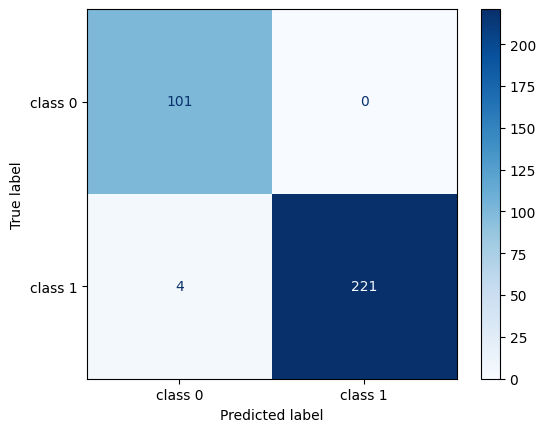

In [142]:
start=perf_counter()

svmda=LinearSVC(class_weight='balanced', max_iter=50000, dual=False)
# Definir los parámetros para la búsqueda de malla
param_grid = {
    'C': np.logspace(-5, 5, 50)
}
# Realizar la búsqueda de malla con validación cruzada
grid_searchsvmdt = RandomizedSearchCV(estimator=svmda, param_distributions=param_grid,
    n_iter=1000,
    scoring='f1_macro',
    n_jobs=-1,
    cv=6,
    verbose=3,
    random_state=42)
grid_searchsvmdt.fit(X_train_fi, y_trainfi)
# Imprimir los mejores parámetros encontrados
print("Best Parameters:", grid_searchsvmdt.best_params_)
# Usar el mejor modelo encontrado para hacer predicciones
best_modelsvmdt = grid_searchsvmdt.best_estimator_

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

y_predsvmfi = best_modelsvmdt.predict(X_test_fi)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_testfi, y_predsvmfi))
print("Classification Report:\n", classification_report(y_testfi, y_predsvmfi))
ConfusionMatrixDisplay.from_predictions(y_testfi, y_predsvmfi, display_labels=target_names, cmap=plt.cm.Blues)


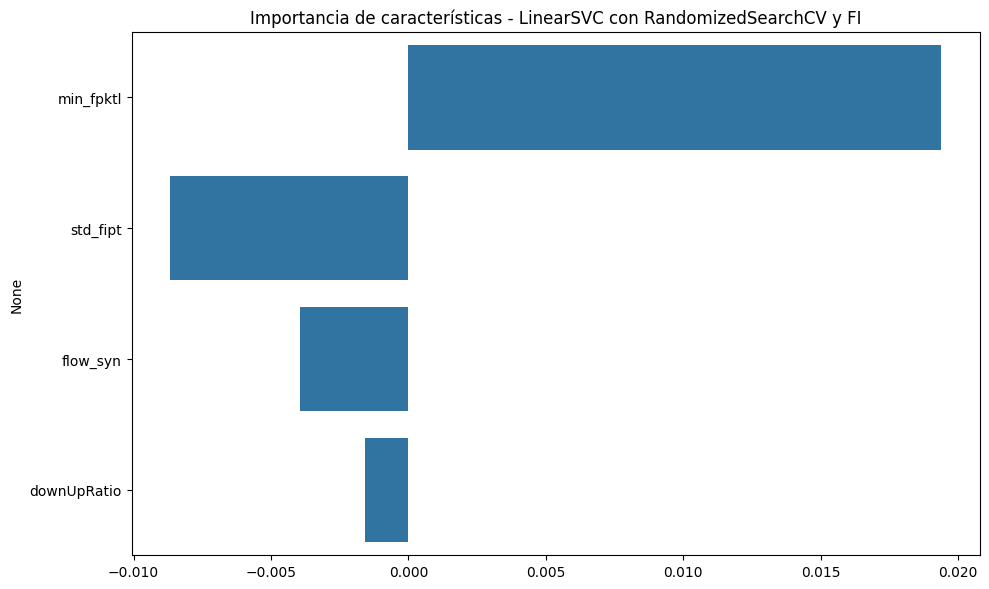

In [143]:
coef = best_modelsvmdt.coef_.flatten()
plt.figure(figsize=(10, 6))
sns.barplot(x=coef, y=X_test_fi.columns)
plt.title("Importancia de características - LinearSVC con RandomizedSearchCV y FI")
plt.tight_layout()
plt.show()

In [144]:
df_resultados = pd.DataFrame({
    'Clase': FI_test,
    'Real': y_testfi,
    'Predicción': y_predsvmfi
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Doceavo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 1    225
0    101
Name: Doceavo, dtype: int64
Aciertos de Predicción:
 1    221
0    101
Name: Doceavo, dtype: int64
Errores de Predicción:
 0   NaN
Name: Doceavo, dtype: float64
Total Correctas: 322, Total Errores: 4


In [145]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testfi, y_predsvmfi))

El coeficiente de correlacion de Matthews es de  0.9720104077653865


## 13 - 14 Naive Bayes

### 13.- NV con RFE

Accuracy: 0.9899497487437185
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.98      0.99       127

    accuracy                           0.99       199
   macro avg       0.99      0.99      0.99       199
weighted avg       0.99      0.99      0.99       199

El coeficiente de correlacion de Matthews es de  0.9785962210992727


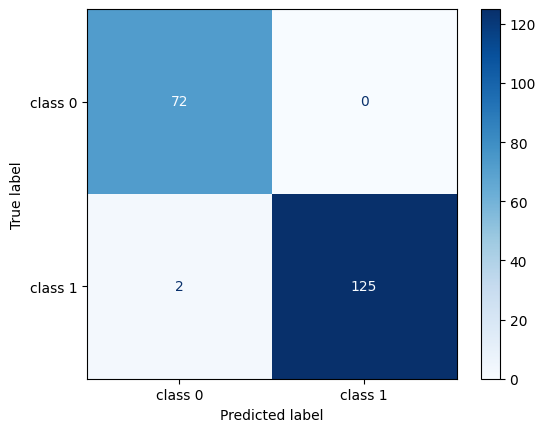

In [146]:
#Creamos el clasificado con GaussianNB, para features con valores continuos
clfnvrfe=GaussianNB()


clfnvrfe.fit(X_train_rfe, y_trainrfe)

y_prednvrfe=clfnvrfe.predict(X_test_rfe)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_testrfe, y_prednvrfe))
print("Classification Report:\n", classification_report(y_testrfe, y_prednvrfe))
ConfusionMatrixDisplay.from_predictions(y_testrfe, y_prednvrfe, display_labels=target_names, cmap=plt.cm.Blues)

print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testrfe, y_prednvrfe))


In [147]:
df_resultados = pd.DataFrame({
    'Clase': RFE_test,
    'Real': y_testrfe,
    'Predicción': y_prednvrfe
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Treceavo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 1    127
0     72
Name: Treceavo, dtype: int64
Aciertos de Predicción:
 1    125
0     72
Name: Treceavo, dtype: int64
Errores de Predicción:
 0   NaN
Name: Treceavo, dtype: float64
Total Correctas: 197, Total Errores: 2


### 14.- NV con FI

Accuracy: 0.9877300613496932
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       101
           1       1.00      0.98      0.99       225

    accuracy                           0.99       326
   macro avg       0.98      0.99      0.99       326
weighted avg       0.99      0.99      0.99       326

El coeficiente de correlacion de Matthews es de  0.9720104077653865


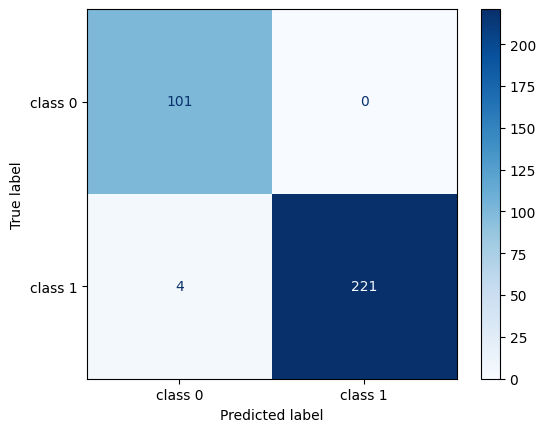

In [148]:
#Creamos el clasificado con GaussianNB, para features con valores continuos
clfnv = GaussianNB()
clfnv.fit(X_train_fi, y_trainfi)

y_prednvfi=clfnv.predict(X_test_fi)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_testfi, y_prednvfi))
print("Classification Report:\n", classification_report(y_testfi, y_prednvfi))
ConfusionMatrixDisplay.from_predictions(y_testfi, y_prednvfi, display_labels=target_names, cmap=plt.cm.Blues)

print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testfi, y_prednvfi))

In [149]:
df_resultados = pd.DataFrame({
    'Clase': FI_test,
    'Real': y_testfi,
    'Predicción': y_prednvfi
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Catorceavo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 1    225
0    101
Name: Catorceavo, dtype: int64
Aciertos de Predicción:
 1    221
0    101
Name: Catorceavo, dtype: int64
Errores de Predicción:
 0   NaN
Name: Catorceavo, dtype: float64
Total Correctas: 322, Total Errores: 4


## 15 - 16 Redes Neuronales

### 15.- ANN con Optuna y RFE

In [150]:
start=perf_counter()

# Extraemos el número de features
num_features = X_train_rfe.shape[1]

#Creo el modelo
best_modelfrnrfe= None

def build_model(trial):
    # Inicializa la lista de capas
    num_layers = trial.suggest_int('num_layers', 1, 8)
    units_per_layer = [trial.suggest_int(f'units_layer_{i}', 256, 1024,256) for i in range(num_layers)]
    #dropout_rate = [trial.suggest_uniform(f'dropout_rate_{i}', 0.0, 0.2) for i in range(num_layers)]
    activators= [trial.suggest_categorical(f'activator_{i}', ['relu', 'leaky_relu', 'tanh']) for i in range(num_layers)]
    kernelinit= [trial.suggest_categorical(f'kernelinit_{i}',['HeNormal','HeUniform','GlorotNormal','GlorotUniform']) for i in range(num_layers)]
    print("Capas ", num_layers, "units per layer: ", units_per_layer)
    # Determina el número de épocas y el tamaño del lote (batch size)
    num_epochs = trial.suggest_int('num_epochs', 10, 50,10)
    batch_size = trial.suggest_categorical('batch_size', [1, 4, 16, 32])

    # Construye el modelo
    model = Sequential()
    model.add(Dense(units_per_layer[0], activation=activators[0], kernel_initializer=kernelinit[0], input_shape=(num_features,)))
    #model.add(Dropout(dropout_rate[0]))

    # Añade las capas ocultas
    for i in range(1,num_layers):
        model.add(Dense(units_per_layer[i], activation=activators[i], kernel_initializer=kernelinit[i]))

        #model.add(Dropout(dropout_rate[i]))


    # Capa de salida
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

    # Compila el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model, num_epochs, batch_size

def objective(trial):
    # Construye y compila el modelo
    modelrn, num_epochs, batch_size = build_model(trial)

    #Cargo el best_model
    global best_modelfrnrfe

    #Callback
    callback= EarlyStopping(monitor='loss', patience=10, mode='min', restore_best_weights=True)
    # Entrena el modelo
    modelrn.fit(X_train_rfe, y_trainrfe, epochs=num_epochs, batch_size=batch_size, verbose=0, callbacks=[callback])

    # Evalúa el modelo
    score = modelrn.evaluate(X_test_rfe, y_testrfe, verbose=0)

    # Si no hay un trial registrado o si el modelo actual es mejor, almacénalo en 'best_model'
    if trial.number == 0 or score[1] > trial.study.best_value:
        best_modelfrnrfe = modelrn  # Almacena el modelo si es el mejor hasta ahora

    return score[1]

# Crea un estudio de Optuna
studyrn = optuna.create_study(direction='maximize')
studyrn.optimize(objective, n_trials=100, show_progress_bar=True)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

  0%|          | 0/100 [00:00<?, ?it/s]

Capas  5 units per layer:  [512, 512, 256, 256, 768]
Capas  5 units per layer:  [768, 512, 1024, 256, 1024]
Capas  4 units per layer:  [1024, 256, 1024, 256]
Capas  7 units per layer:  [768, 1024, 512, 256, 768, 768, 768]
Capas  7 units per layer:  [1024, 768, 1024, 512, 768, 512, 512]
Capas  5 units per layer:  [512, 1024, 1024, 512, 1024]
Capas  3 units per layer:  [256, 512, 256]
Capas  8 units per layer:  [768, 1024, 768, 1024, 256, 1024, 1024, 512]
Capas  6 units per layer:  [256, 1024, 768, 256, 256, 768]
Capas  7 units per layer:  [256, 256, 1024, 1024, 256, 1024, 256]
Capas  2 units per layer:  [512, 768]
Capas  8 units per layer:  [768, 512, 256, 1024, 512, 256, 1024, 512]
Capas  1 units per layer:  [512]
Capas  8 units per layer:  [768, 768, 512, 768, 512, 1024, 1024, 512]
Capas  4 units per layer:  [512, 512, 768, 768]
Capas  6 units per layer:  [1024, 768, 512, 768, 512, 1024]
Capas  3 units per layer:  [768, 256, 768]
Capas  6 units per layer:  [512, 1024, 256, 512, 768, 5

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.98      0.99       127

    accuracy                           0.99       199
   macro avg       0.99      0.99      0.99       199
weighted avg       0.99      0.99      0.99       199



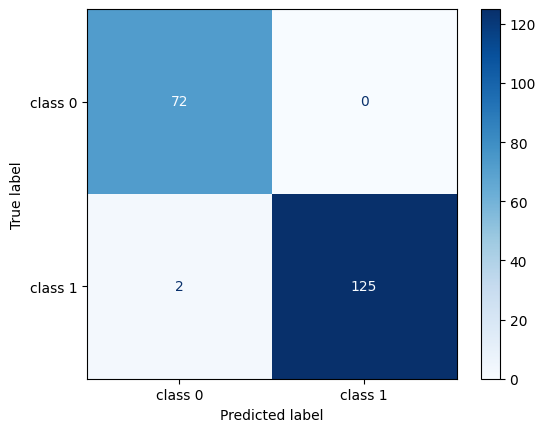

In [151]:
y_pred_probarfe = best_modelfrnrfe.predict(X_test_rfe)

# Convierte las probabilidades en clases binarias (0 o 1)
y_predfrnrfe = (y_pred_probarfe > 0.5).astype(int)

# Calcula la matriz de confusión
print("Classification Report:\n", classification_report(y_testrfe, y_predfrnrfe))
ConfusionMatrixDisplay.from_predictions(y_testrfe, y_predfrnrfe, display_labels=target_names, cmap=plt.cm.Blues)

In [152]:

explainerrfe = shap.Explainer(best_modelfrnrfe.predict, X_test_rfe)
shap_valuesrfe = explainerrfe(X_test_rfe)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   4%|▎         | 7/199 [00:00<?, ?it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▍         | 9/199 [00:10<00:25,  7.55it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▌         | 10/199 [00:10<00:35,  5.27it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▌         | 11/199 [00:10<00:41,  4.54it/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▌         | 12/199 [00:11<00:47,  3.92it/s]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 13/199 [00:11<00:49,  3.77it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 14/199 [00:11<00:50,  3.70it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 15/199 [00:12<00:49,  3.69it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 16/199 [00:12<00:49,  3.66it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▊         | 17/199 [00:12<00:50,  3.64it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▉         | 18/199 [00:12<00:49,  3.63it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|▉         | 19/199 [00:13<00:49,  3.61it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|█         | 20/199 [00:13<00:49,  3.63it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  11%|█         | 21/199 [00:13<00:49,  3.62it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  11%|█         | 22/199 [00:14<00:50,  3.54it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▏        | 23/199 [00:14<00:49,  3.55it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▏        | 24/199 [00:14<00:48,  3.57it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 25/199 [00:14<00:47,  3.64it/s]

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 26/199 [00:15<00:47,  3.64it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▎        | 27/199 [00:15<00:47,  3.65it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▍        | 28/199 [00:15<00:46,  3.64it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▍        | 29/199 [00:16<00:46,  3.63it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▌        | 30/199 [00:16<00:46,  3.63it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▌        | 31/199 [00:16<00:46,  3.63it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▌        | 32/199 [00:16<00:45,  3.65it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 33/199 [00:17<00:45,  3.66it/s]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 34/199 [00:17<00:47,  3.47it/s]

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 35/199 [00:17<00:46,  3.55it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 36/199 [00:18<00:48,  3.38it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  19%|█▊        | 37/199 [00:18<00:46,  3.45it/s]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  19%|█▉        | 38/199 [00:18<00:47,  3.37it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|█▉        | 39/199 [00:18<00:46,  3.43it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|██        | 40/199 [00:19<00:45,  3.52it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██        | 41/199 [00:19<00:46,  3.42it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██        | 42/199 [00:19<00:45,  3.48it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 43/199 [00:20<00:43,  3.56it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 44/199 [00:20<00:43,  3.60it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  23%|██▎       | 45/199 [00:20<00:42,  3.64it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  23%|██▎       | 46/199 [00:20<00:42,  3.63it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  24%|██▎       | 47/199 [00:21<00:42,  3.61it/s]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  24%|██▍       | 48/199 [00:21<00:43,  3.49it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  25%|██▍       | 49/199 [00:21<00:42,  3.50it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  25%|██▌       | 50/199 [00:21<00:42,  3.54it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  26%|██▌       | 51/199 [00:22<00:41,  3.56it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  26%|██▌       | 52/199 [00:22<00:40,  3.60it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  27%|██▋       | 53/199 [00:22<00:40,  3.57it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  27%|██▋       | 54/199 [00:23<00:40,  3.59it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  28%|██▊       | 55/199 [00:23<00:39,  3.60it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  28%|██▊       | 56/199 [00:23<00:39,  3.63it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  29%|██▊       | 57/199 [00:23<00:39,  3.64it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  29%|██▉       | 58/199 [00:24<00:38,  3.65it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|██▉       | 59/199 [00:24<00:40,  3.50it/s]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|███       | 60/199 [00:24<00:39,  3.50it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  31%|███       | 61/199 [00:25<00:38,  3.56it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  31%|███       | 62/199 [00:25<00:38,  3.58it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  32%|███▏      | 63/199 [00:25<00:37,  3.60it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  32%|███▏      | 64/199 [00:25<00:37,  3.62it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  33%|███▎      | 65/199 [00:26<00:36,  3.64it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  33%|███▎      | 66/199 [00:26<00:36,  3.64it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  34%|███▎      | 67/199 [00:26<00:36,  3.65it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  34%|███▍      | 68/199 [00:26<00:35,  3.67it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  35%|███▍      | 69/199 [00:27<00:35,  3.66it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  35%|███▌      | 70/199 [00:27<00:35,  3.65it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  36%|███▌      | 71/199 [00:27<00:35,  3.64it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  36%|███▌      | 72/199 [00:28<00:34,  3.65it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  37%|███▋      | 73/199 [00:28<00:34,  3.65it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  37%|███▋      | 74/199 [00:28<00:34,  3.67it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  38%|███▊      | 75/199 [00:28<00:34,  3.65it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  38%|███▊      | 76/199 [00:29<00:33,  3.62it/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  39%|███▊      | 77/199 [00:29<00:36,  3.34it/s]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  39%|███▉      | 78/199 [00:29<00:35,  3.39it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|███▉      | 79/199 [00:30<00:34,  3.44it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  40%|████      | 80/199 [00:30<00:33,  3.51it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  41%|████      | 81/199 [00:30<00:33,  3.57it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  41%|████      | 82/199 [00:30<00:32,  3.59it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  42%|████▏     | 83/199 [00:31<00:32,  3.61it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  42%|████▏     | 84/199 [00:31<00:31,  3.66it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  43%|████▎     | 85/199 [00:31<00:31,  3.65it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 86/199 [00:31<00:30,  3.65it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  44%|████▎     | 87/199 [00:32<00:30,  3.64it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  44%|████▍     | 88/199 [00:32<00:30,  3.64it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  45%|████▍     | 89/199 [00:32<00:30,  3.63it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  45%|████▌     | 90/199 [00:33<00:29,  3.65it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  46%|████▌     | 91/199 [00:33<00:29,  3.64it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  46%|████▌     | 92/199 [00:33<00:29,  3.66it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  47%|████▋     | 93/199 [00:33<00:28,  3.66it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  47%|████▋     | 94/199 [00:34<00:28,  3.68it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  48%|████▊     | 95/199 [00:34<00:29,  3.53it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  48%|████▊     | 96/199 [00:34<00:28,  3.56it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  49%|████▊     | 97/199 [00:35<00:28,  3.60it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  49%|████▉     | 98/199 [00:35<00:27,  3.61it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  50%|████▉     | 99/199 [00:35<00:27,  3.62it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  50%|█████     | 100/199 [00:35<00:27,  3.64it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  51%|█████     | 101/199 [00:36<00:27,  3.62it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  51%|█████▏    | 102/199 [00:36<00:26,  3.61it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  52%|█████▏    | 103/199 [00:36<00:26,  3.63it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 104/199 [00:36<00:26,  3.57it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  53%|█████▎    | 105/199 [00:37<00:31,  2.96it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  53%|█████▎    | 106/199 [00:37<00:34,  2.66it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  54%|█████▍    | 107/199 [00:38<00:35,  2.62it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▍    | 108/199 [00:38<00:34,  2.65it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▍    | 109/199 [00:38<00:32,  2.76it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  55%|█████▌    | 110/199 [00:39<00:31,  2.84it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  56%|█████▌    | 111/199 [00:39<00:29,  2.94it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  56%|█████▋    | 112/199 [00:39<00:28,  3.06it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 113/199 [00:40<00:27,  3.14it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  57%|█████▋    | 114/199 [00:40<00:26,  3.16it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  58%|█████▊    | 115/199 [00:40<00:26,  3.18it/s]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  58%|█████▊    | 116/199 [00:41<00:25,  3.21it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  59%|█████▉    | 117/199 [00:41<00:24,  3.30it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  59%|█████▉    | 118/199 [00:41<00:24,  3.31it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|█████▉    | 119/199 [00:42<00:24,  3.33it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  60%|██████    | 120/199 [00:42<00:23,  3.34it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  61%|██████    | 121/199 [00:42<00:22,  3.39it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████▏   | 122/199 [00:42<00:22,  3.41it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  62%|██████▏   | 123/199 [00:43<00:22,  3.39it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  62%|██████▏   | 124/199 [00:43<00:22,  3.39it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  63%|██████▎   | 125/199 [00:43<00:21,  3.46it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 126/199 [00:44<00:21,  3.34it/s]

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  64%|██████▍   | 127/199 [00:44<00:20,  3.45it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  64%|██████▍   | 128/199 [00:44<00:20,  3.51it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  65%|██████▍   | 129/199 [00:44<00:20,  3.42it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  65%|██████▌   | 130/199 [00:45<00:20,  3.38it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  66%|██████▌   | 131/199 [00:45<00:20,  3.36it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▋   | 132/199 [00:45<00:20,  3.28it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 133/199 [00:46<00:20,  3.25it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 134/199 [00:46<00:19,  3.27it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  68%|██████▊   | 135/199 [00:46<00:19,  3.31it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  68%|██████▊   | 136/199 [00:47<00:18,  3.37it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  69%|██████▉   | 137/199 [00:47<00:18,  3.44it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  69%|██████▉   | 138/199 [00:47<00:17,  3.50it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  70%|██████▉   | 139/199 [00:47<00:16,  3.55it/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  70%|███████   | 140/199 [00:48<00:17,  3.42it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  71%|███████   | 141/199 [00:48<00:16,  3.49it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  71%|███████▏  | 142/199 [00:48<00:16,  3.54it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  72%|███████▏  | 143/199 [00:49<00:15,  3.53it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  72%|███████▏  | 144/199 [00:49<00:15,  3.57it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  73%|███████▎  | 145/199 [00:49<00:15,  3.60it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  73%|███████▎  | 146/199 [00:49<00:14,  3.58it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  74%|███████▍  | 147/199 [00:50<00:14,  3.60it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  74%|███████▍  | 148/199 [00:50<00:14,  3.58it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  75%|███████▍  | 149/199 [00:50<00:13,  3.60it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  75%|███████▌  | 150/199 [00:50<00:13,  3.59it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  76%|███████▌  | 151/199 [00:51<00:13,  3.58it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  76%|███████▋  | 152/199 [00:51<00:13,  3.58it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  77%|███████▋  | 153/199 [00:51<00:12,  3.61it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  77%|███████▋  | 154/199 [00:52<00:12,  3.59it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  78%|███████▊  | 155/199 [00:52<00:12,  3.59it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  78%|███████▊  | 156/199 [00:52<00:11,  3.61it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  79%|███████▉  | 157/199 [00:52<00:11,  3.60it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  79%|███████▉  | 158/199 [00:53<00:11,  3.62it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  80%|███████▉  | 159/199 [00:53<00:11,  3.62it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  80%|████████  | 160/199 [00:53<00:10,  3.63it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  81%|████████  | 161/199 [00:54<00:10,  3.64it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  81%|████████▏ | 162/199 [00:54<00:10,  3.62it/s]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  82%|████████▏ | 163/199 [00:54<00:10,  3.43it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  82%|████████▏ | 164/199 [00:54<00:10,  3.47it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  83%|████████▎ | 165/199 [00:55<00:09,  3.50it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  83%|████████▎ | 166/199 [00:55<00:09,  3.52it/s]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  84%|████████▍ | 167/199 [00:55<00:09,  3.53it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  84%|████████▍ | 168/199 [00:56<00:08,  3.58it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  85%|████████▍ | 169/199 [00:56<00:08,  3.58it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  85%|████████▌ | 170/199 [00:56<00:08,  3.50it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  86%|████████▌ | 171/199 [00:56<00:07,  3.53it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▋ | 172/199 [00:57<00:07,  3.55it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  87%|████████▋ | 173/199 [00:57<00:07,  3.58it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  87%|████████▋ | 174/199 [00:57<00:07,  3.56it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  88%|████████▊ | 175/199 [00:57<00:06,  3.60it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  88%|████████▊ | 176/199 [00:58<00:06,  3.50it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  89%|████████▉ | 177/199 [00:58<00:06,  3.54it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  89%|████████▉ | 178/199 [00:58<00:05,  3.56it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  90%|████████▉ | 179/199 [00:59<00:05,  3.60it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  90%|█████████ | 180/199 [00:59<00:05,  3.61it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  91%|█████████ | 181/199 [00:59<00:04,  3.61it/s]

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  91%|█████████▏| 182/199 [00:59<00:04,  3.64it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  92%|█████████▏| 183/199 [01:00<00:04,  3.65it/s]

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  92%|█████████▏| 184/199 [01:00<00:04,  3.67it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  93%|█████████▎| 185/199 [01:00<00:03,  3.64it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  93%|█████████▎| 186/199 [01:01<00:03,  3.63it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  94%|█████████▍| 187/199 [01:01<00:03,  3.65it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  94%|█████████▍| 188/199 [01:01<00:02,  3.67it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  95%|█████████▍| 189/199 [01:01<00:02,  3.67it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  95%|█████████▌| 190/199 [01:02<00:02,  3.64it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  96%|█████████▌| 191/199 [01:02<00:02,  3.64it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  96%|█████████▋| 192/199 [01:02<00:02,  3.49it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  97%|█████████▋| 193/199 [01:02<00:01,  3.54it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  97%|█████████▋| 194/199 [01:03<00:01,  3.59it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  98%|█████████▊| 195/199 [01:03<00:01,  3.60it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  98%|█████████▊| 196/199 [01:03<00:00,  3.63it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  99%|█████████▉| 197/199 [01:04<00:00,  3.65it/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  99%|█████████▉| 198/199 [01:04<00:00,  3.51it/s]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer: 100%|██████████| 199/199 [01:04<00:00,  3.52it/s]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer: 200it [01:04,  2.97it/s]                         


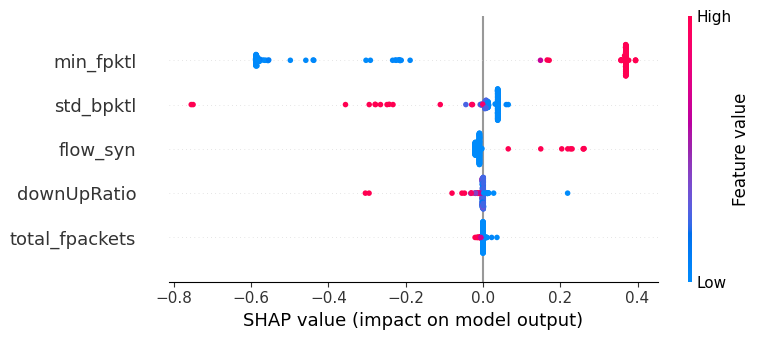

In [153]:


# Visualización resumen
shap.summary_plot(shap_valuesrfe, X_test_rfe)

In [154]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testrfe, y_predfrnrfe))

El coeficiente de correlacion de Matthews es de  0.9785962210992727


In [155]:
y_predfrnrfe_flat=y_predfrnrfe.flatten()
df_resultados = pd.DataFrame({
    'Clase': RFE_test,
    'Real': y_testrfe,
    'Predicción': y_predfrnrfe_flat
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Quinceavo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 1    127
0     72
Name: Quinceavo, dtype: int64
Aciertos de Predicción:
 1    125
0     72
Name: Quinceavo, dtype: int64
Errores de Predicción:
 0   NaN
Name: Quinceavo, dtype: float64
Total Correctas: 197, Total Errores: 2


### 16.- ANN con Optuna y FI

In [156]:
start=perf_counter()

# Extraemos el número de features
num_features = X_train_fi.shape[1]

#Creo el modelo
best_modelrnfi= None

def build_model(trial):
    # Inicializa la lista de capas
    num_layers = trial.suggest_int('num_layers', 1, 8)
    units_per_layer = [trial.suggest_int(f'units_layer_{i}', 256, 1024,256) for i in range(num_layers)]
    #dropout_rate = [trial.suggest_uniform(f'dropout_rate_{i}', 0.0, 0.2) for i in range(num_layers)]
    activators= [trial.suggest_categorical(f'activator_{i}', ['relu', 'leaky_relu', 'tanh']) for i in range(num_layers)]
    kernelinit= [trial.suggest_categorical(f'kernelinit_{i}',['HeNormal','HeUniform','GlorotNormal','GlorotUniform']) for i in range(num_layers)]
    print("Capas ", num_layers, "units per layer: ", units_per_layer)
    # Determina el número de épocas y el tamaño del lote (batch size)
    num_epochs = trial.suggest_int('num_epochs', 10, 50,10)
    batch_size = trial.suggest_categorical('batch_size', [1, 4, 16, 32])

    # Construye el modelo
    model = Sequential()
    model.add(Dense(units_per_layer[0], activation=activators[0], kernel_initializer=kernelinit[0], input_shape=(num_features,)))
    #model.add(Dropout(dropout_rate[0]))

    # Añade las capas ocultas
    for i in range(1,num_layers):
        model.add(Dense(units_per_layer[i], activation=activators[i], kernel_initializer=kernelinit[i]))

        #model.add(Dropout(dropout_rate[i]))


    # Capa de salida
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

    # Compila el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model, num_epochs, batch_size

def objective(trial):
    # Construye y compila el modelo
    modelrnfi, num_epochs, batch_size = build_model(trial)

    #Cargo el best_model
    global best_modelrnfi

    #Callback
    callback= EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
    # Entrena el modelo
    modelrnfi.fit(X_train_fi, y_trainfi, epochs=num_epochs, batch_size=batch_size, verbose=0, callbacks=[callback])

    # Evalúa el modelo
    score = modelrnfi.evaluate(X_test_fi, y_testfi, verbose=0)

    # Si no hay un trial registrado o si el modelo actual es mejor, almacénalo en 'best_model'
    if trial.number == 0 or score[1] > trial.study.best_value:
        best_modelrnfi = modelrnfi  # Almacena el modelo si es el mejor hasta ahora

    return score[1]

# Crea un estudio de Optuna
studyrn = optuna.create_study(direction='maximize')
studyrn.optimize(objective, n_trials=100, show_progress_bar=True)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

  0%|          | 0/100 [00:00<?, ?it/s]

Capas  7 units per layer:  [1024, 512, 256, 1024, 1024, 512, 768]
Capas  5 units per layer:  [256, 768, 512, 512, 256]
Capas  6 units per layer:  [768, 256, 512, 768, 512, 512]
Capas  4 units per layer:  [768, 1024, 768, 512]
Capas  8 units per layer:  [768, 256, 768, 512, 768, 768, 512, 1024]
Capas  3 units per layer:  [512, 1024, 1024]
Capas  1 units per layer:  [1024]
Capas  1 units per layer:  [1024]
Capas  4 units per layer:  [256, 512, 768, 768]
Capas  6 units per layer:  [256, 256, 256, 256, 512, 768]
Capas  1 units per layer:  [1024]
Capas  8 units per layer:  [1024, 512, 256, 1024, 1024, 256, 1024, 256]
Capas  2 units per layer:  [1024, 768]
Capas  7 units per layer:  [512, 512, 256, 1024, 1024, 1024, 768]
Capas  3 units per layer:  [768, 768, 512]
Capas  6 units per layer:  [1024, 512, 1024, 1024, 768, 256]
Capas  5 units per layer:  [1024, 768, 256, 768, 1024]
Capas  7 units per layer:  [512, 1024, 512, 256, 768, 512, 256]
Capas  2 units per layer:  [768, 256]
Capas  3 units

In [157]:
X_test_fi.shape

(326, 4)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      1.00      1.00       225

    accuracy                           1.00       326
   macro avg       1.00      1.00      1.00       326
weighted avg       1.00      1.00      1.00       326



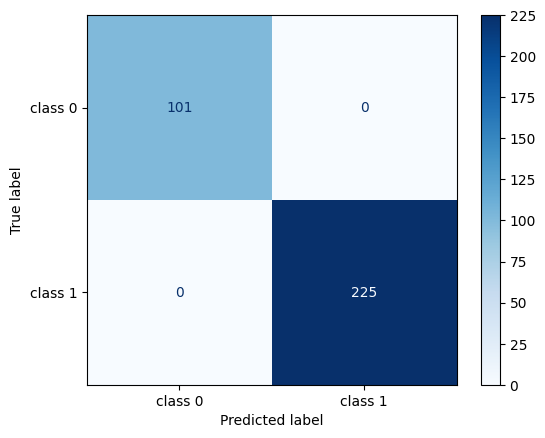

In [158]:
y_pred_probafi = best_modelrnfi.predict(X_test_fi)

# Convierte las probabilidades en clases binarias (0 o 1)
y_predfrnfi = (y_pred_probafi > 0.5).astype(int)

# Calcula la matriz de confusión
print("Classification Report:\n", classification_report(y_testfi, y_predfrnfi))
ConfusionMatrixDisplay.from_predictions(y_testfi, y_predfrnfi, display_labels=target_names, cmap=plt.cm.Blues)

In [159]:
explainerfi= shap.Explainer(best_modelrnfi.predict, X_test_fi)
shap_valuesfi = explainerfi(X_test_fi)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

ExactExplainer explainer:  17%|█▋        | 57/326 [00:00<?, ?it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 59/326 [00:10<00:23, 11.18it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  19%|█▊        | 61/326 [00:10<00:37,  7.11it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  19%|█▉        | 62/326 [00:10<00:39,  6.63it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  19%|█▉        | 63/326 [00:11<00:42,  6.26it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|█▉        | 64/326 [00:11<00:43,  6.07it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|█▉        | 65/326 [00:11<00:44,  5.93it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|██        | 66/326 [00:11<00:44,  5.83it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██        | 67/326 [00:11<00:44,  5.83it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██        | 68/326 [00:11<00:44,  5.75it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██        | 69/326 [00:12<00:44,  5.72it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██▏       | 70/326 [00:12<00:44,  5.73it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 71/326 [00:12<00:45,  5.64it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 72/326 [00:12<00:45,  5.64it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 73/326 [00:12<00:44,  5.64it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  23%|██▎       | 74/326 [00:12<00:44,  5.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  23%|██▎       | 75/326 [00:13<00:44,  5.58it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  23%|██▎       | 76/326 [00:13<00:44,  5.56it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  24%|██▎       | 77/326 [00:13<00:44,  5.66it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  24%|██▍       | 78/326 [00:13<00:43,  5.64it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  24%|██▍       | 79/326 [00:13<00:44,  5.61it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  25%|██▍       | 80/326 [00:14<00:43,  5.64it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  25%|██▍       | 81/326 [00:14<00:46,  5.29it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  25%|██▌       | 82/326 [00:14<00:45,  5.37it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  25%|██▌       | 83/326 [00:14<00:44,  5.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  26%|██▌       | 84/326 [00:14<00:45,  5.37it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  26%|██▌       | 85/326 [00:14<00:44,  5.46it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  26%|██▋       | 86/326 [00:15<00:43,  5.50it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  27%|██▋       | 87/326 [00:15<00:43,  5.54it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  27%|██▋       | 88/326 [00:15<00:42,  5.57it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  27%|██▋       | 89/326 [00:15<00:42,  5.57it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  28%|██▊       | 90/326 [00:15<00:42,  5.59it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  28%|██▊       | 91/326 [00:16<00:41,  5.61it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  28%|██▊       | 92/326 [00:16<00:41,  5.63it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  29%|██▊       | 93/326 [00:16<00:41,  5.64it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  29%|██▉       | 94/326 [00:16<00:41,  5.61it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  29%|██▉       | 95/326 [00:16<00:41,  5.59it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  29%|██▉       | 96/326 [00:16<00:40,  5.63it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|██▉       | 97/326 [00:17<00:40,  5.64it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|███       | 98/326 [00:17<00:40,  5.65it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|███       | 99/326 [00:17<00:40,  5.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  31%|███       | 100/326 [00:17<00:40,  5.53it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  31%|███       | 101/326 [00:17<00:40,  5.53it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  31%|███▏      | 102/326 [00:18<00:40,  5.58it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  32%|███▏      | 103/326 [00:18<00:41,  5.38it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  32%|███▏      | 104/326 [00:18<00:43,  5.15it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  32%|███▏      | 105/326 [00:18<00:42,  5.26it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  33%|███▎      | 106/326 [00:18<00:40,  5.39it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  33%|███▎      | 107/326 [00:18<00:40,  5.47it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  33%|███▎      | 108/326 [00:19<00:39,  5.54it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  33%|███▎      | 109/326 [00:19<00:39,  5.52it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  34%|███▎      | 110/326 [00:19<00:38,  5.54it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  34%|███▍      | 111/326 [00:19<00:38,  5.62it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  34%|███▍      | 112/326 [00:19<00:37,  5.64it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  35%|███▍      | 113/326 [00:20<00:38,  5.58it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  35%|███▍      | 114/326 [00:20<00:37,  5.60it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  35%|███▌      | 115/326 [00:20<00:37,  5.62it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  36%|███▌      | 116/326 [00:20<00:37,  5.63it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  36%|███▌      | 117/326 [00:20<00:37,  5.63it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  36%|███▌      | 118/326 [00:20<00:36,  5.64it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  37%|███▋      | 119/326 [00:21<00:36,  5.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  37%|███▋      | 120/326 [00:21<00:37,  5.56it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  37%|███▋      | 121/326 [00:21<00:36,  5.60it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  37%|███▋      | 122/326 [00:21<00:36,  5.60it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  38%|███▊      | 123/326 [00:21<00:35,  5.64it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  38%|███▊      | 124/326 [00:21<00:35,  5.61it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  38%|███▊      | 125/326 [00:22<00:37,  5.35it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  39%|███▊      | 126/326 [00:22<00:36,  5.46it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  39%|███▉      | 127/326 [00:22<00:36,  5.50it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  39%|███▉      | 128/326 [00:22<00:35,  5.55it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  40%|███▉      | 129/326 [00:22<00:35,  5.57it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  40%|███▉      | 130/326 [00:23<00:35,  5.55it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  40%|████      | 131/326 [00:23<00:35,  5.54it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  40%|████      | 132/326 [00:23<00:34,  5.57it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  41%|████      | 133/326 [00:23<00:34,  5.54it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  41%|████      | 134/326 [00:23<00:34,  5.56it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  41%|████▏     | 135/326 [00:23<00:33,  5.65it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  42%|████▏     | 136/326 [00:24<00:33,  5.62it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  42%|████▏     | 137/326 [00:24<00:33,  5.64it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  42%|████▏     | 138/326 [00:24<00:33,  5.62it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  43%|████▎     | 139/326 [00:24<00:33,  5.56it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  43%|████▎     | 140/326 [00:24<00:33,  5.57it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  43%|████▎     | 141/326 [00:25<00:33,  5.59it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  44%|████▎     | 142/326 [00:25<00:33,  5.57it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  44%|████▍     | 143/326 [00:25<00:33,  5.54it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  44%|████▍     | 144/326 [00:25<00:32,  5.56it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  44%|████▍     | 145/326 [00:25<00:34,  5.30it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  45%|████▍     | 146/326 [00:25<00:33,  5.42it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  45%|████▌     | 147/326 [00:26<00:32,  5.44it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  45%|████▌     | 148/326 [00:26<00:32,  5.52it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  46%|████▌     | 149/326 [00:26<00:31,  5.54it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  46%|████▌     | 150/326 [00:26<00:31,  5.54it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  46%|████▋     | 151/326 [00:26<00:31,  5.57it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  47%|████▋     | 152/326 [00:27<00:31,  5.57it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  47%|████▋     | 153/326 [00:27<00:31,  5.54it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  47%|████▋     | 154/326 [00:27<00:30,  5.57it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  48%|████▊     | 155/326 [00:27<00:30,  5.54it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  48%|████▊     | 156/326 [00:27<00:30,  5.54it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  48%|████▊     | 157/326 [00:27<00:30,  5.59it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  48%|████▊     | 158/326 [00:28<00:29,  5.61it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  49%|████▉     | 159/326 [00:28<00:29,  5.64it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  49%|████▉     | 160/326 [00:28<00:29,  5.66it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  49%|████▉     | 161/326 [00:28<00:29,  5.62it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  50%|████▉     | 162/326 [00:28<00:29,  5.61it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  50%|█████     | 163/326 [00:29<00:29,  5.59it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  50%|█████     | 164/326 [00:29<00:28,  5.62it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  51%|█████     | 165/326 [00:29<00:28,  5.59it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  51%|█████     | 166/326 [00:29<00:30,  5.32it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  51%|█████     | 167/326 [00:29<00:29,  5.38it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  52%|█████▏    | 168/326 [00:29<00:29,  5.43it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  52%|█████▏    | 169/326 [00:30<00:28,  5.45it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  52%|█████▏    | 170/326 [00:30<00:28,  5.52it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  52%|█████▏    | 171/326 [00:30<00:27,  5.56it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  53%|█████▎    | 172/326 [00:30<00:27,  5.56it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  53%|█████▎    | 173/326 [00:30<00:27,  5.56it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  53%|█████▎    | 174/326 [00:31<00:27,  5.58it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  54%|█████▎    | 175/326 [00:31<00:26,  5.60it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  54%|█████▍    | 176/326 [00:31<00:26,  5.61it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  54%|█████▍    | 177/326 [00:31<00:26,  5.63it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  55%|█████▍    | 178/326 [00:31<00:26,  5.63it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  55%|█████▍    | 179/326 [00:31<00:26,  5.61it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  55%|█████▌    | 180/326 [00:32<00:26,  5.58it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  56%|█████▌    | 181/326 [00:32<00:25,  5.61it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  56%|█████▌    | 182/326 [00:32<00:25,  5.62it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  56%|█████▌    | 183/326 [00:32<00:25,  5.58it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  56%|█████▋    | 184/326 [00:32<00:25,  5.58it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  57%|█████▋    | 185/326 [00:32<00:25,  5.60it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  57%|█████▋    | 186/326 [00:33<00:24,  5.68it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  57%|█████▋    | 187/326 [00:33<00:24,  5.66it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  58%|█████▊    | 188/326 [00:33<00:24,  5.62it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  58%|█████▊    | 189/326 [00:33<00:24,  5.56it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  58%|█████▊    | 190/326 [00:33<00:24,  5.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  59%|█████▊    | 191/326 [00:34<00:24,  5.49it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  59%|█████▉    | 192/326 [00:34<00:24,  5.52it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  59%|█████▉    | 193/326 [00:34<00:23,  5.55it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  60%|█████▉    | 194/326 [00:34<00:23,  5.54it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  60%|█████▉    | 195/326 [00:34<00:23,  5.52it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  60%|██████    | 196/326 [00:34<00:24,  5.41it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  60%|██████    | 197/326 [00:35<00:23,  5.46it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  61%|██████    | 198/326 [00:35<00:23,  5.53it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  61%|██████    | 199/326 [00:35<00:22,  5.57it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  61%|██████▏   | 200/326 [00:35<00:22,  5.67it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  62%|██████▏   | 201/326 [00:35<00:22,  5.68it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  62%|██████▏   | 202/326 [00:36<00:21,  5.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  62%|██████▏   | 203/326 [00:36<00:22,  5.51it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  63%|██████▎   | 204/326 [00:36<00:21,  5.56it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  63%|██████▎   | 205/326 [00:36<00:22,  5.48it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  63%|██████▎   | 206/326 [00:36<00:21,  5.50it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  63%|██████▎   | 207/326 [00:36<00:21,  5.53it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  64%|██████▍   | 208/326 [00:37<00:21,  5.58it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  64%|██████▍   | 209/326 [00:37<00:20,  5.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  64%|██████▍   | 210/326 [00:37<00:21,  5.51it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  65%|██████▍   | 211/326 [00:37<00:20,  5.54it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  65%|██████▌   | 212/326 [00:37<00:20,  5.54it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  65%|██████▌   | 213/326 [00:38<00:20,  5.56it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  66%|██████▌   | 214/326 [00:38<00:20,  5.54it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  66%|██████▌   | 215/326 [00:38<00:20,  5.54it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  66%|██████▋   | 216/326 [00:38<00:19,  5.59it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  67%|██████▋   | 217/326 [00:38<00:19,  5.60it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  67%|██████▋   | 218/326 [00:38<00:19,  5.57it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  67%|██████▋   | 219/326 [00:39<00:19,  5.56it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  67%|██████▋   | 220/326 [00:39<00:19,  5.56it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  68%|██████▊   | 221/326 [00:39<00:19,  5.32it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  68%|██████▊   | 222/326 [00:39<00:19,  5.39it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  68%|██████▊   | 223/326 [00:39<00:18,  5.48it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  69%|██████▊   | 224/326 [00:40<00:18,  5.56it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  69%|██████▉   | 225/326 [00:40<00:18,  5.56it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  69%|██████▉   | 226/326 [00:40<00:17,  5.60it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  70%|██████▉   | 227/326 [00:40<00:17,  5.60it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  70%|██████▉   | 228/326 [00:40<00:17,  5.61it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  70%|███████   | 229/326 [00:40<00:17,  5.69it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  71%|███████   | 230/326 [00:41<00:16,  5.67it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  71%|███████   | 231/326 [00:41<00:16,  5.61it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  71%|███████   | 232/326 [00:41<00:16,  5.59it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  71%|███████▏  | 233/326 [00:41<00:16,  5.54it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  72%|███████▏  | 234/326 [00:41<00:16,  5.58it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  72%|███████▏  | 235/326 [00:41<00:16,  5.57it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  72%|███████▏  | 236/326 [00:42<00:16,  5.60it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  73%|███████▎  | 237/326 [00:42<00:16,  5.34it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  73%|███████▎  | 238/326 [00:42<00:16,  5.38it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  73%|███████▎  | 239/326 [00:42<00:16,  5.39it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  74%|███████▎  | 240/326 [00:42<00:15,  5.43it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  74%|███████▍  | 241/326 [00:43<00:15,  5.48it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  74%|███████▍  | 242/326 [00:43<00:15,  5.51it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  75%|███████▍  | 243/326 [00:43<00:14,  5.56it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  75%|███████▍  | 244/326 [00:43<00:14,  5.57it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  75%|███████▌  | 245/326 [00:43<00:14,  5.57it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  75%|███████▌  | 246/326 [00:43<00:14,  5.57it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  76%|███████▌  | 247/326 [00:44<00:14,  5.61it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  76%|███████▌  | 248/326 [00:44<00:13,  5.61it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  76%|███████▋  | 249/326 [00:44<00:13,  5.63it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  77%|███████▋  | 250/326 [00:44<00:13,  5.62it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  77%|███████▋  | 251/326 [00:44<00:13,  5.59it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  77%|███████▋  | 252/326 [00:45<00:13,  5.36it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  78%|███████▊  | 253/326 [00:45<00:13,  5.40it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  78%|███████▊  | 254/326 [00:45<00:13,  5.46it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  78%|███████▊  | 255/326 [00:45<00:12,  5.46it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  79%|███████▊  | 256/326 [00:45<00:12,  5.49it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  79%|███████▉  | 257/326 [00:45<00:12,  5.51it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  79%|███████▉  | 258/326 [00:46<00:12,  5.55it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  79%|███████▉  | 259/326 [00:46<00:12,  5.54it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  80%|███████▉  | 260/326 [00:46<00:11,  5.53it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  80%|████████  | 261/326 [00:46<00:11,  5.56it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  80%|████████  | 262/326 [00:46<00:11,  5.59it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  81%|████████  | 263/326 [00:47<00:11,  5.55it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  81%|████████  | 264/326 [00:47<00:11,  5.57it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  81%|████████▏ | 265/326 [00:47<00:10,  5.57it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  82%|████████▏ | 266/326 [00:47<00:11,  5.35it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  82%|████████▏ | 267/326 [00:47<00:10,  5.42it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  82%|████████▏ | 268/326 [00:47<00:10,  5.50it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  83%|████████▎ | 269/326 [00:48<00:10,  5.51it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  83%|████████▎ | 270/326 [00:48<00:10,  5.53it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  83%|████████▎ | 271/326 [00:48<00:09,  5.59it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  83%|████████▎ | 272/326 [00:48<00:09,  5.57it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  84%|████████▎ | 273/326 [00:48<00:09,  5.61it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  84%|████████▍ | 274/326 [00:49<00:09,  5.60it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  84%|████████▍ | 275/326 [00:49<00:09,  5.59it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  85%|████████▍ | 276/326 [00:49<00:08,  5.61it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  85%|████████▍ | 277/326 [00:49<00:08,  5.61it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  85%|████████▌ | 278/326 [00:49<00:08,  5.64it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  86%|████████▌ | 279/326 [00:49<00:08,  5.65it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  86%|████████▌ | 280/326 [00:50<00:08,  5.46it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  86%|████████▌ | 281/326 [00:50<00:08,  5.49it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  87%|████████▋ | 282/326 [00:50<00:07,  5.53it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  87%|████████▋ | 283/326 [00:50<00:07,  5.58it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  87%|████████▋ | 284/326 [00:50<00:07,  5.59it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  87%|████████▋ | 285/326 [00:51<00:07,  5.64it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  88%|████████▊ | 286/326 [00:51<00:07,  5.65it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  88%|████████▊ | 287/326 [00:51<00:06,  5.65it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  88%|████████▊ | 288/326 [00:51<00:06,  5.67it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  89%|████████▊ | 289/326 [00:51<00:06,  5.64it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  89%|████████▉ | 290/326 [00:51<00:06,  5.58it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  89%|████████▉ | 291/326 [00:52<00:06,  5.59it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  90%|████████▉ | 292/326 [00:52<00:06,  5.59it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  90%|████████▉ | 293/326 [00:52<00:05,  5.61it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  90%|█████████ | 294/326 [00:52<00:05,  5.34it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  90%|█████████ | 295/326 [00:52<00:05,  5.43it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  91%|█████████ | 296/326 [00:53<00:05,  5.51it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  91%|█████████ | 297/326 [00:53<00:05,  5.54it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  91%|█████████▏| 298/326 [00:53<00:05,  5.59it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  92%|█████████▏| 299/326 [00:53<00:04,  5.58it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  92%|█████████▏| 300/326 [00:53<00:04,  5.62it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  92%|█████████▏| 301/326 [00:53<00:04,  5.64it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  93%|█████████▎| 302/326 [00:54<00:04,  5.64it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  93%|█████████▎| 303/326 [00:54<00:04,  5.71it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  93%|█████████▎| 304/326 [00:54<00:03,  5.71it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  94%|█████████▎| 305/326 [00:54<00:03,  5.65it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  94%|█████████▍| 306/326 [00:54<00:03,  5.67it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  94%|█████████▍| 307/326 [00:54<00:03,  5.39it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  94%|█████████▍| 308/326 [00:55<00:03,  5.45it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  95%|█████████▍| 309/326 [00:55<00:03,  5.52it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  95%|█████████▌| 310/326 [00:55<00:02,  5.56it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  95%|█████████▌| 311/326 [00:55<00:02,  5.58it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  96%|█████████▌| 312/326 [00:55<00:02,  5.63it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  96%|█████████▌| 313/326 [00:56<00:02,  5.65it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  96%|█████████▋| 314/326 [00:56<00:02,  5.66it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  97%|█████████▋| 315/326 [00:56<00:01,  5.67it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  97%|█████████▋| 316/326 [00:56<00:01,  5.65it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  97%|█████████▋| 317/326 [00:56<00:01,  5.60it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  98%|█████████▊| 318/326 [00:56<00:01,  5.63it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  98%|█████████▊| 319/326 [00:57<00:01,  5.70it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  98%|█████████▊| 320/326 [00:57<00:01,  5.39it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  98%|█████████▊| 321/326 [00:57<00:00,  5.44it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  99%|█████████▉| 322/326 [00:57<00:00,  5.50it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  99%|█████████▉| 323/326 [00:57<00:00,  5.52it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  99%|█████████▉| 324/326 [00:58<00:00,  5.57it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer: 100%|█████████▉| 325/326 [00:58<00:00,  5.57it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer: 100%|██████████| 326/326 [00:58<00:00,  5.56it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer: 327it [00:58,  4.61it/s]                         


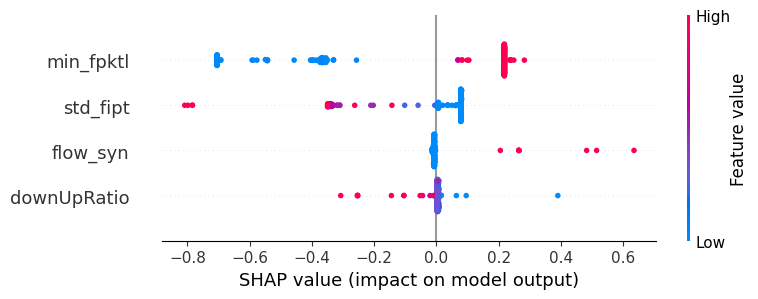

In [160]:
# Visualización resumen
shap.summary_plot(shap_valuesfi, X_test_fi)

In [161]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testfi, y_predfrnfi))

El coeficiente de correlacion de Matthews es de  1.0


In [162]:
y_predfrnfi_flat=y_predfrnfi.flatten()

df_resultados = pd.DataFrame({
    'Clase': FI_test,
    'Real': y_testfi,
    'Predicción': y_predfrnfi_flat
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Dieciseisavo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 1    225
0    101
Name: Dieciseisavo, dtype: int64
Aciertos de Predicción:
 1    225
0    101
Name: Dieciseisavo, dtype: int64
Errores de Predicción:
 0    NaN
Name: Dieciseisavo, dtype: object
Total Correctas: 326, Total Errores: 0


# Calculo de desempeño con Validacion

## RFE

In [163]:
X_test_rfe.columns



Index(['total_fpackets', 'min_fpktl', 'std_bpktl', 'flow_syn', 'downUpRatio'], dtype='object')

In [164]:

# Convertir las columnas a lista y añadir 'label'
columnas_utiles = list(X_test_rfe.columns) + ['label']

# Crear el nuevo DataFrame con esas columnas
dftrfe = df_val_f[columnas_utiles].copy()
print(dftrfe.shape)
dftrfe=dftrfe.dropna()
print(dftrfe.shape)
# Eliminar duplicados
print("Duplicados: ",dftrfe.duplicated().sum())

print("Duplicados A ",dftrfe.drop(['label'],axis=1,inplace=False).duplicated().sum())

# Eliminar duplicados en todas las columnas excepto 'label' y 'Ataque'
dftrfe_cleaned = dftrfe.drop(['label'], axis=1).duplicated(keep='first')

# Filtrar el DataFrame original solo por las filas no duplicadas
dftrfe_cleaned = dftrfe[~dftrfe_cleaned]
dftrfe=dftrfe_cleaned.copy()

print("Duplicados D ",dftrfe.drop(['label'],axis=1,inplace=False).duplicated().sum())



dftrfe = dftrfe.drop_duplicates()

print("Valores nulos: ", dftrfe.isnull().values.sum())
dftrfe=dftrfe.dropna()

#collections.Counter(df.dftrfe.values)



# Balancear clases con subsampling (reduce clase mayoritaria)
df_class0_val = dftrfe[dftrfe['label'] == 0]
df_class1_val = dftrfe[dftrfe['label'] == 1]


df_class1_down_val = resample(df_class1_val,
                             replace=False,
                             n_samples=len(df_class0_val),
                             random_state=42)

# Dataset balanceado para validación
df_val_balanced = pd.concat([df_class0_val, df_class1_down_val])

# Mezclar datos
df_val_balanced = df_val_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_val_balanced['label'].value_counts())


dftrfe_test = df_val_balanced['label']
dftrfet = df_val_balanced.drop(columns=['label'])

#dftrfe_test=dftrfe['label']
#dftrfet=dftrfe.drop(columns=['label'])


numeric_colsdftr = dftrfet.select_dtypes(include=['float64', 'int']).columns.to_list()
preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_colsdftr)], remainder='passthrough')

# fit on the trainning dataset
preprocessor.fit_transform(dftrfet)
dftrfet_stand = preprocessor.transform(dftrfet)
#The result returned by ColumnTransformer is a numpy array, so the column names are lost.


labelsdftrfe=list(dftrfet.columns.values.tolist())
df_rfe_dft_stand=pd.DataFrame(dftrfet_stand,columns=labelsdftrfe)

print("Valores nulos: ", df_rfe_dft_stand.isnull().values.sum())
print("Duplicados: ",df_rfe_dft_stand.duplicated().sum())


(2030, 6)
(2030, 6)
Duplicados:  813
Duplicados A  813
Duplicados D  0
Valores nulos:  0
label
1    104
0    104
Name: count, dtype: int64
Valores nulos:  0
Duplicados:  0


### Comparacion de distribucion datos entrenamiento y validacion RFE

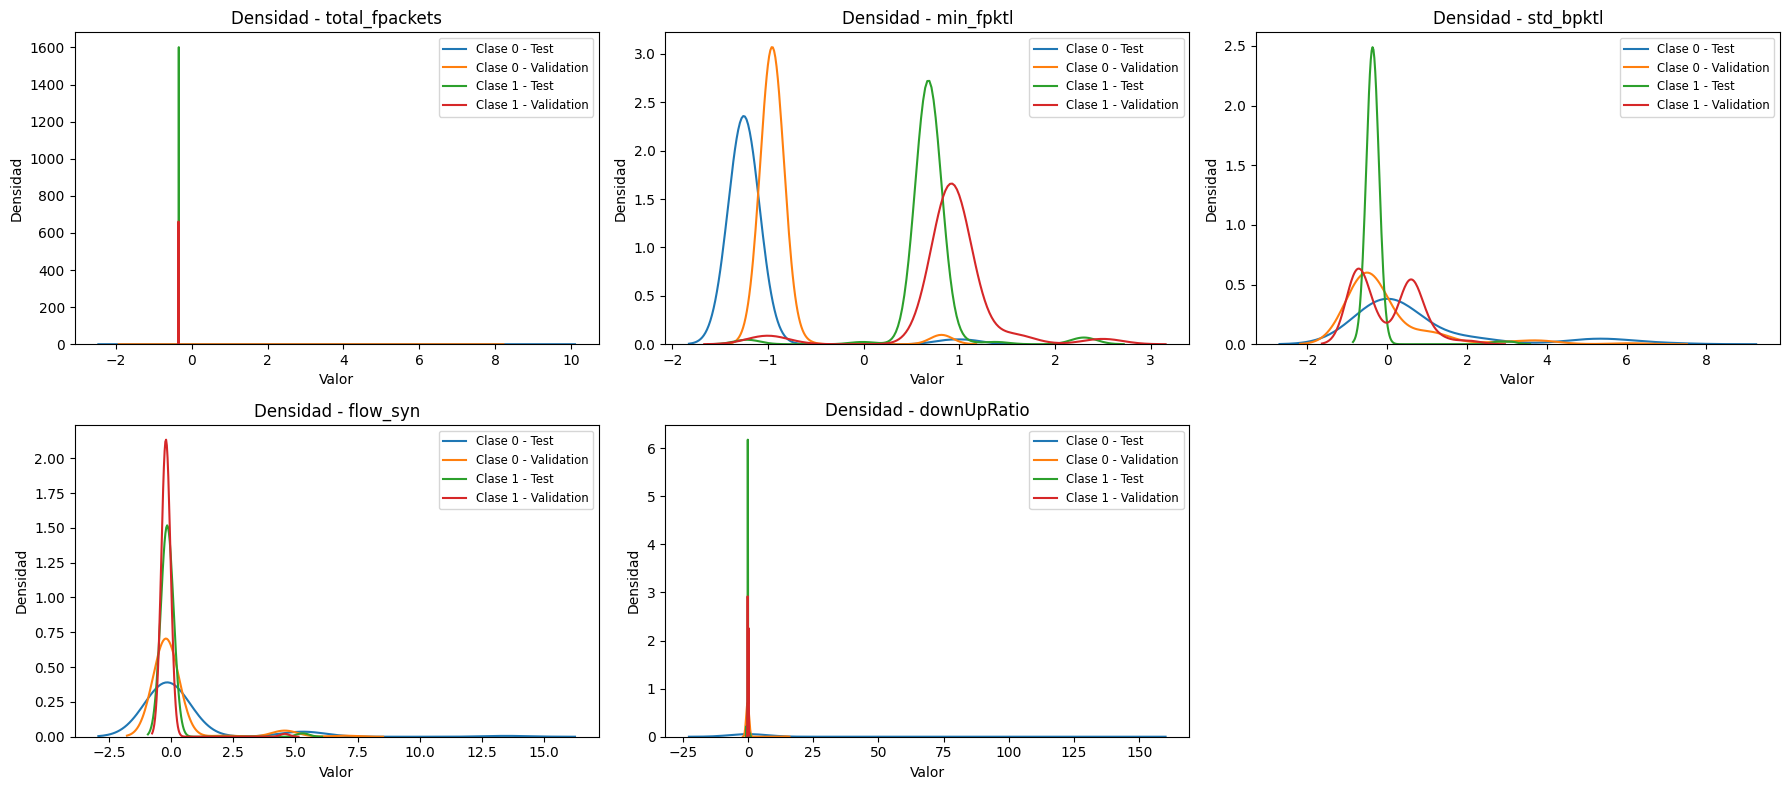

In [165]:
# Etiquetar conjunto de testing
X_test_labeled_rfe = X_test_rfe.copy()
X_test_labeled_rfe["Set"] = "Test"
X_test_labeled_rfe["Class"] = y_testrfe.values  # Asegura alineación por posición

# Etiquetar conjunto de validación
X_val_labeled_rfe = df_rfe_dft_stand.copy()
X_val_labeled_rfe["Set"] = "Validation"
X_val_labeled_rfe["Class"] = dftrfe_test.values  # Asegura alineación por posición

# Unir ambos conjuntos
X_all_rfe = pd.concat([X_test_labeled_rfe, X_val_labeled_rfe])

# Obtener lista de features a graficar
features_rfe_plot = X_test_rfe.columns
num_features_rfe = len(features_rfe_plot)

# Calcular layout dinámico para subplots
cols = 3
rows = math.ceil(num_features_rfe / cols)
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()

# Graficar cada feature
for i, feature in enumerate(features_rfe_plot):
    ax = axs[i]
    data_ok = False
    for label_class in sorted(X_all_rfe["Class"].unique()):
        for label_set in ["Test", "Validation"]:
            subset = X_all_rfe[(X_all_rfe["Class"] == label_class) & (X_all_rfe["Set"] == label_set)][feature]
            if subset.nunique() > 1 and subset.shape[0] > 1:
                sns.kdeplot(subset, label=f"Clase {label_class} - {label_set}", ax=ax)
                data_ok = True
            elif subset.shape[0] > 0:
                sns.histplot(subset, label=f"Clase {label_class} - {label_set}", ax=ax, kde=False, stat='density', element='step')
                data_ok = True
    if data_ok:
        ax.set_title(f"Densidad - {feature}")
        ax.set_xlabel("Valor")
        ax.set_ylabel("Densidad")
        ax.legend(fontsize='small')
    else:
        ax.set_visible(False)

# Ocultar ejes sobrantes
for j in range(num_features_rfe, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Desepeño de los modelos

#### 4.- RL con Optuna y RFE

              precision    recall  f1-score   support

     class 0       0.96      0.84      0.89       104
     class 1       0.85      0.96      0.90       104

    accuracy                           0.90       208
   macro avg       0.91      0.90      0.90       208
weighted avg       0.91      0.90      0.90       208



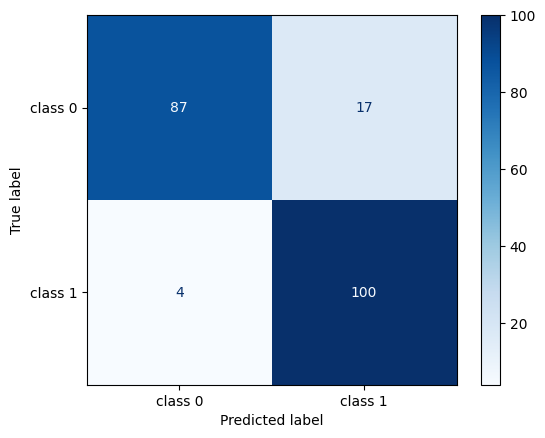

In [166]:
#Modelo 4 
#Regresion Logistica con Optuna y RFE

y_predbrlorfedt = best_modelrlo.predict(df_rfe_dft_stand)



#performance results
print(classification_report(dftrfe_test, y_predbrlorfedt, target_names=target_names))

cm = confusion_matrix(dftrfe_test, y_predbrlorfedt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

#### 8.- XGBoost con GridSearch y RFE

Best Parameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.01), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(3), max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=np.int64(166), n_jobs=None,
              num_parallel_tree=None, ...)
Score: 0.984873949579832
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.87      0.74       104
           1       0.8

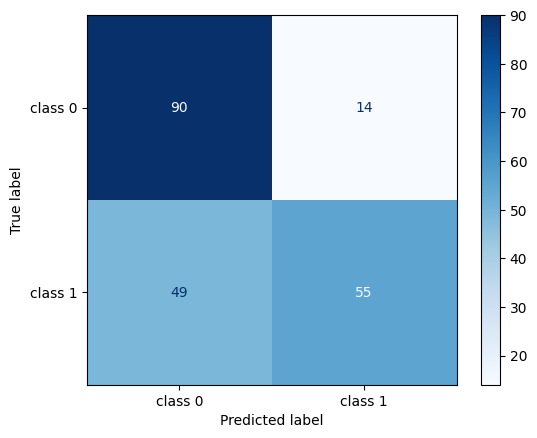

In [167]:
#Modelo 8. 
# XGBoost con GRid Search y RFE 

# Predecir y evaluar el modelo
y_predxgbrfedft = grid_xgbrfe.predict(df_rfe_dft_stand)
print("Best Parameters:", grid_xgbrfe.best_estimator_)
print("Score:", grid_xgbrfe.best_score_)
print("Classification Report:\n", classification_report(dftrfe_test, y_predxgbrfedft))
ConfusionMatrixDisplay.from_predictions(dftrfe_test, y_predxgbrfedft, display_labels=target_names, cmap=plt.cm.Blues)

#### 11.- SVC con RandomizedSearchCV y RFE

Accuracy: 0.9615384615384616
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       104
           1       0.97      0.95      0.96       104

    accuracy                           0.96       208
   macro avg       0.96      0.96      0.96       208
weighted avg       0.96      0.96      0.96       208



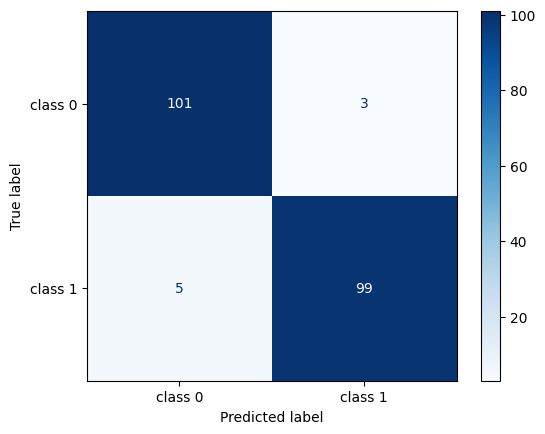

In [168]:
#Modelo 11 
# SVC con RandomSearc y RFE 

y_predsvmrfedft = best_modelsvmrfe.predict(df_rfe_dft_stand)

# Evaluar el modelo
print("Accuracy:", accuracy_score(dftrfe_test, y_predsvmrfedft))
print("Classification Report:\n", classification_report(dftrfe_test, y_predsvmrfedft))
ConfusionMatrixDisplay.from_predictions(dftrfe_test, y_predsvmrfedft, display_labels=target_names, cmap=plt.cm.Blues)

#### 13.- NV con RFE

Accuracy: 0.9471153846153846
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       104
           1       0.96      0.93      0.95       104

    accuracy                           0.95       208
   macro avg       0.95      0.95      0.95       208
weighted avg       0.95      0.95      0.95       208

El coeficiente de correlacion de Matthews es de  0.8946030465521243


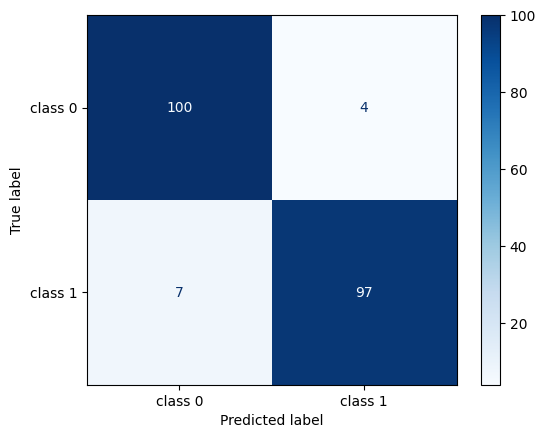

In [169]:
#Modelo 13 
# Naive Bayes y RFE 

y_prednvrfedft=clfnvrfe.predict(df_rfe_dft_stand)

# Evaluar el modelo
print("Accuracy:", accuracy_score(dftrfe_test, y_prednvrfedft))
print("Classification Report:\n", classification_report(dftrfe_test, y_prednvrfedft))
ConfusionMatrixDisplay.from_predictions(dftrfe_test, y_prednvrfedft, display_labels=target_names, cmap=plt.cm.Blues)

print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(dftrfe_test, y_prednvrfedft))

#### 15.- ANN con Optuna y RFE

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       104
           1       0.97      0.95      0.96       104

    accuracy                           0.96       208
   macro avg       0.96      0.96      0.96       208
weighted avg       0.96      0.96      0.96       208



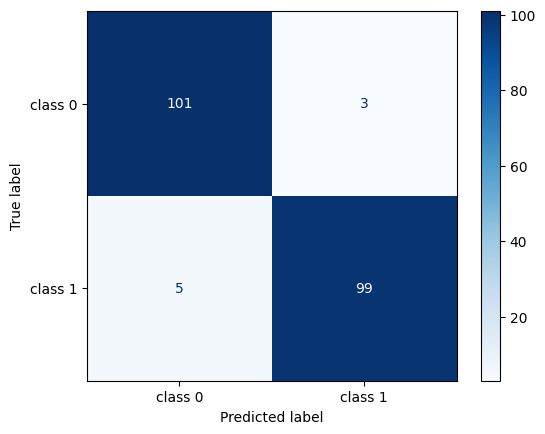

In [170]:
#Modelo 15 
# ANN con Optuna y RFE 

y_pred_probarfedft = best_modelfrnrfe.predict(df_rfe_dft_stand)

# Convierte las probabilidades en clases binarias (0 o 1)
y_predfrnrfedft = (y_pred_probarfedft > 0.5).astype(int)

# Calcula la matriz de confusión
print("Classification Report:\n", classification_report(dftrfe_test, y_predfrnrfedft))
ConfusionMatrixDisplay.from_predictions(dftrfe_test, y_predfrnrfedft, display_labels=target_names, cmap=plt.cm.Blues)

In [171]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(dftrfe_test, y_predfrnrfedft))

El coeficiente de correlacion de Matthews es de  0.9232476577353843


## FI


In [172]:
X_test_fi.columns

Index(['min_fpktl', 'std_fipt', 'flow_syn', 'downUpRatio'], dtype='object')

In [173]:
# Convertir las columnas a lista y añadir 'label'
columnas_utiles = list(X_test_fi.columns) + ['label']

# Crear el nuevo DataFrame con esas columnas
dftee = df_val_f[columnas_utiles].copy()


dftee.shape


# Eliminar duplicados
print("Duplicados A ",dftee.drop(['label'],axis=1,inplace=False).duplicated().sum())

# Eliminar duplicados en todas las columnas excepto 'label' y 'Ataque'
dft_cleaned = dftee.drop(['label'], axis=1).duplicated(keep='first')

# Filtrar el DataFrame original solo por las filas no duplicadas
dft_cleaned = dftee[~dft_cleaned]
dft=dft_cleaned.copy()

print("Duplicados D ",dft.drop(['label'],axis=1,inplace=False).duplicated().sum())




print("Valores nulos: ", dft.isnull().values.sum())
dft.dropna(inplace=True)

#collections.Counter(df.dft.values)

# Balancear clases con subsampling (reduce clase mayoritaria)
dffi_class0_val = dft[dft['label'] == 0]
dffi_class1_val = dft[dft['label'] == 1]


dffi_class1_down_val = resample(dffi_class1_val,
                             replace=False,
                             n_samples=len(dffi_class0_val),
                             random_state=42)

# Dataset balanceado para validación
dffi_val_balanced = pd.concat([dffi_class0_val, dffi_class1_down_val])

# Mezclar datos
dffi_val_balanced = dffi_val_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(dffi_val_balanced['label'].value_counts())


dft_test = dffi_val_balanced['label']
dftt = dffi_val_balanced.drop(columns=['label'])

# dft_test=dft['label']
# dftt=dft.drop(columns=['label'])


numeric_colsdft = dftt.select_dtypes(include=['float64', 'int']).columns.to_list()
preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_colsdft)], remainder='passthrough')

# fit on the trainning dataset
preprocessor.fit_transform(dftt)
dft_stand = preprocessor.transform(dftt)
#The result returned by ColumnTransformer is a numpy array, so the column names are lost.


labelsdft=list(dftt.columns.values.tolist())
df_dft_stand=pd.DataFrame(dft_stand,columns=labelsdft)

print("Valores nulos: ", dftt.isnull().values.sum())
print("Duplicados: ",dftt.duplicated().sum())



Duplicados A  110
Duplicados D  0
Valores nulos:  0
label
0    117
1    117
Name: count, dtype: int64
Valores nulos:  0
Duplicados:  0


In [174]:
dft.shape

(1920, 5)

### Comparacion de distribucion datos entrenamiento y validacion FI

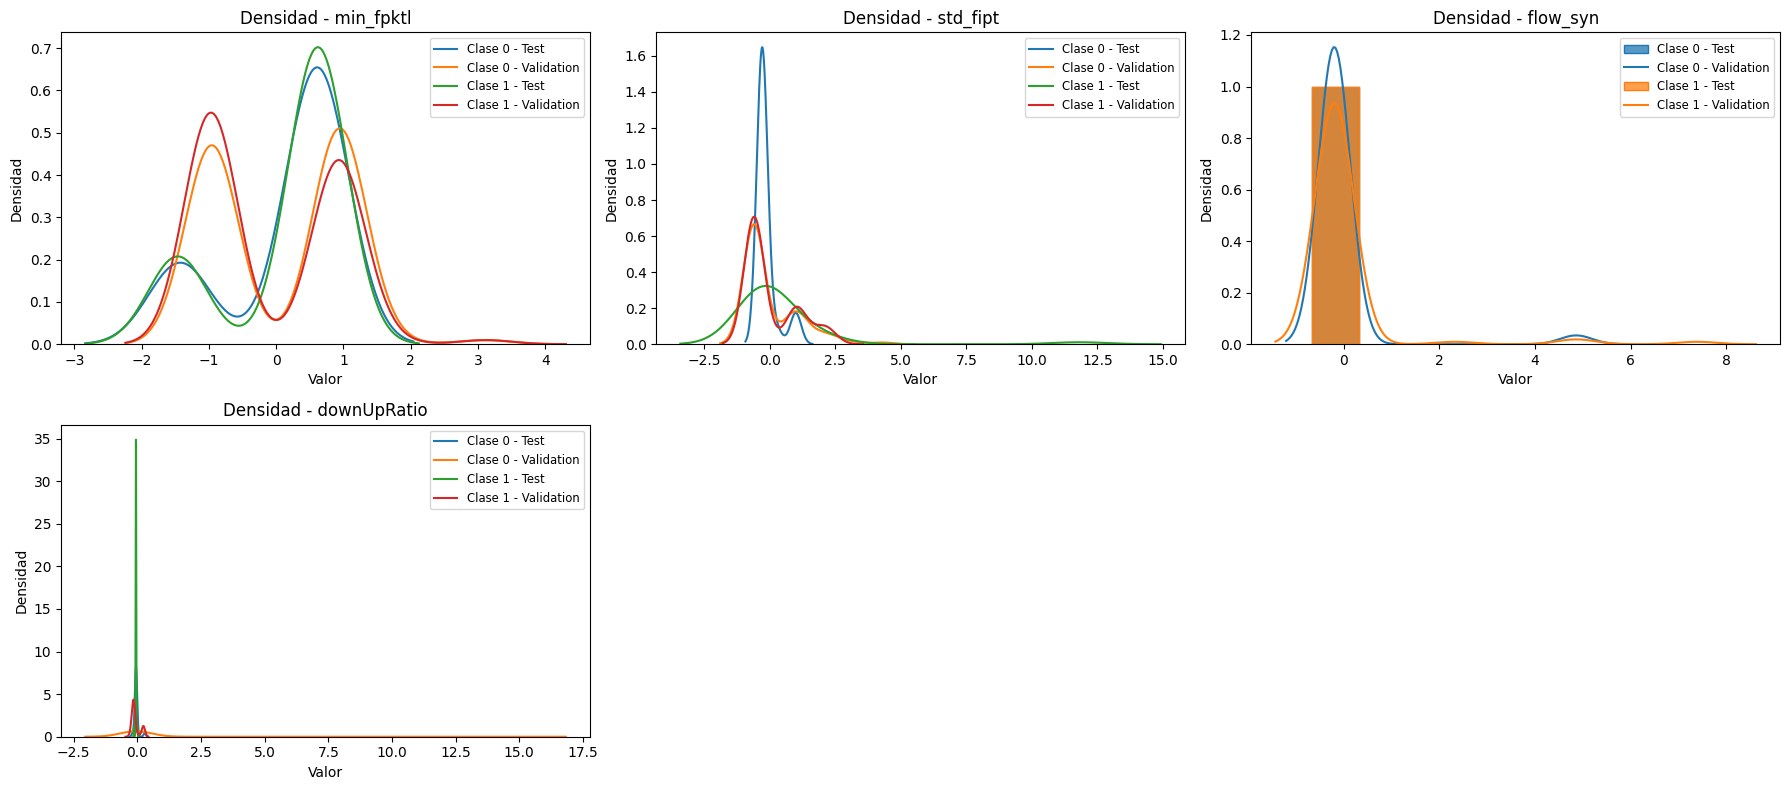

In [175]:
# Crear copia con etiquetas
X_test_labeled_fi = X_test_fi.copy()
X_test_labeled_fi["Set"] = "Test"
X_test_labeled_fi["Class"] = y_testrfe  # Asegúrate de que los índices coincidan

X_val_labeled_fi = df_dft_stand.copy()
X_val_labeled_fi["Set"] = "Validation"
X_val_labeled_fi["Class"] = dftrfe_test  # Asegúrate de que los índices coincidan

# Concatenar
X_all_fi = pd.concat([X_test_labeled_fi, X_val_labeled_fi])
features_to_plot_fi = X_test_fi.columns
num_features_fi = len(features_to_plot_fi)

# Layout dinámico
cols = 3
rows = math.ceil(num_features_fi / cols)
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()

# Plot por feature, clase y conjunto
for i, feature in enumerate(features_to_plot_fi):
    ax = axs[i]
    data_ok = False
    for label_class in [0, 1]:
        for label_set in ["Test", "Validation"]:
            subset = X_all_fi[(X_all_fi["Class"] == label_class) & (X_all_fi["Set"] == label_set)][feature]
            if subset.nunique() > 1 and subset.shape[0] > 1:
                sns.kdeplot(subset, label=f"Clase {label_class} - {label_set}", ax=ax)
                data_ok = True
            elif subset.shape[0] > 0:
                sns.histplot(subset, label=f"Clase {label_class} - {label_set}", ax=ax, kde=False, stat='density', element='step')
                data_ok = True
    if data_ok:
        ax.set_title(f"Densidad - {feature}")
        ax.set_xlabel("Valor")
        ax.set_ylabel("Densidad")
        ax.legend(fontsize='small')
    else:
        ax.set_visible(False)

# Eliminar gráficos vacíos
for j in range(num_features_fi, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Desempeño de modelos FI

#### 7.- DT con GridSearchCV y FI

In [176]:
#Modelo 7 
# DT optimizado y FI 

y_preddttfi = mdtop.predict(df_dft_stand)
y_probdttfi = mdtop.predict_proba(df_dft_stand)
print('Accuracy of Decision Tree-Test: ', accuracy_score(y_preddttfi, dft_test))

Accuracy of Decision Tree-Test:  0.9572649572649573


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       117
           1       0.96      0.96      0.96       117

    accuracy                           0.96       234
   macro avg       0.96      0.96      0.96       234
weighted avg       0.96      0.96      0.96       234



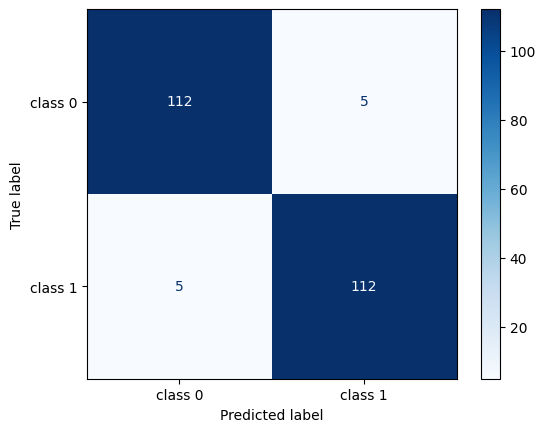

In [177]:
#Classification for test before hyperparameter tuning
print(classification_report(dft_test,y_preddttfi))
ConfusionMatrixDisplay.from_predictions(dft_test, y_preddttfi, display_labels=target_names, cmap=plt.cm.Blues)

#### 9.- XGBoost con GridSearch y FI

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.09      0.17       117
           1       0.52      1.00      0.69       117

    accuracy                           0.55       234
   macro avg       0.76      0.55      0.43       234
weighted avg       0.76      0.55      0.43       234



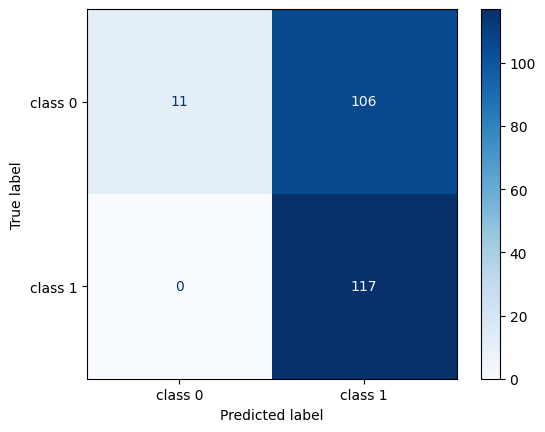

In [178]:
#Modelo 9 
# XGBoost con GridSearch y FI 

# Predecir y evaluar el modelo
y_predxgbfit = grid_xgbfi.predict(df_dft_stand)
print("Classification Report:\n", classification_report(dft_test, y_predxgbfit))
ConfusionMatrixDisplay.from_predictions(dft_test, y_predxgbfit, display_labels=target_names, cmap=plt.cm.Blues)

In [179]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(dft_test, y_predxgbfit))

El coeficiente de correlacion de Matthews es de  0.22209762326528776


#### 10.- Random Forest

Mejor modelo accuracy score: 0.8932
Mejores parámetros:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': np.int64(20)}
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.89       117
           1       0.85      0.96      0.90       117

    accuracy                           0.89       234
   macro avg       0.90      0.89      0.89       234
weighted avg       0.90      0.89      0.89       234



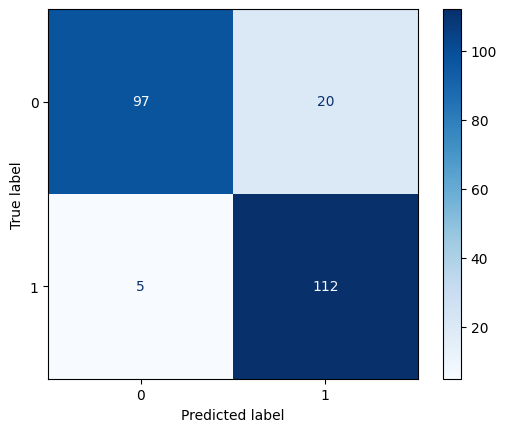

In [180]:
#Modelo 10 
# Random Forest con RandomSearch y FI 

y_predrft = best_clfrf.predict(df_dft_stand)

# Evaluar el mejor modelo
print('Mejor modelo accuracy score: {0:0.4f}'. format(accuracy_score(dft_test, y_predrft)))
print("Mejores parámetros: ", grid_searchrf.best_params_)

print("Classification Report:\n", classification_report(dft_test, y_predrft))

# Print the Confusion Matrix and slice it into four pieces

ConfusionMatrixDisplay.from_predictions(dft_test, y_predrft, cmap=plt.cm.Blues);

In [181]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(dft_test, y_predrft))

El coeficiente de correlacion de Matthews es de  0.7928677913256961


#### 12.- SVC con RandomizedSearchCV y FI

Accuracy: 0.9615384615384616
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       117
           1       0.97      0.95      0.96       117

    accuracy                           0.96       234
   macro avg       0.96      0.96      0.96       234
weighted avg       0.96      0.96      0.96       234



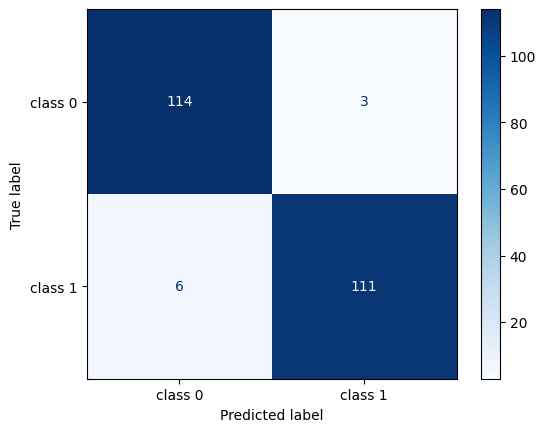

In [182]:
#Modelo 12
# SVC RandomSearch y FI 

y_predsvmtfit = best_modelsvmdt.predict(df_dft_stand)

# Evaluar el modelo
print("Accuracy:", accuracy_score(dft_test, y_predsvmtfit))
print("Classification Report:\n", classification_report(dft_test, y_predsvmtfit))
ConfusionMatrixDisplay.from_predictions(dft_test, y_predsvmtfit, display_labels=target_names, cmap=plt.cm.Blues)

#### 14.- NV con FI

Accuracy: 0.9487179487179487
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       117
           1       0.96      0.93      0.95       117

    accuracy                           0.95       234
   macro avg       0.95      0.95      0.95       234
weighted avg       0.95      0.95      0.95       234

El coeficiente de correlacion de Matthews es de  0.8979608289116157


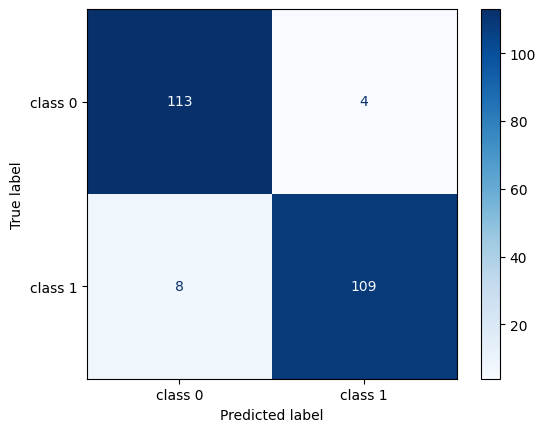

In [183]:
#Modelo 14 
# Naive Bayes y FI 

y_prednvfit=clfnv.predict(df_dft_stand)

# Evaluar el modelo
print("Accuracy:", accuracy_score(dft_test, y_prednvfit))
print("Classification Report:\n", classification_report(dft_test, y_prednvfit))
ConfusionMatrixDisplay.from_predictions(dft_test, y_prednvfit, display_labels=target_names, cmap=plt.cm.Blues)

print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(dft_test, y_prednvfit))

#### 16.- ANN con Optuna y FI

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.55      0.68       117
           1       0.67      0.93      0.78       117

    accuracy                           0.74       234
   macro avg       0.78      0.74      0.73       234
weighted avg       0.78      0.74      0.73       234



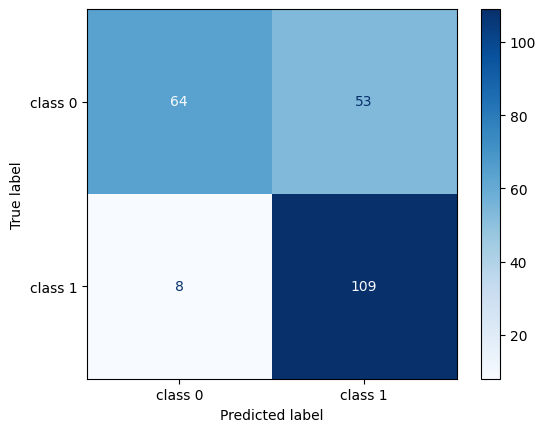

In [184]:
#Modelo 16
# ANN Optuna y FI
#  
y_pred_probadftt = best_modelrnfi.predict(df_dft_stand)

# Convierte las probabilidades en clases binarias (0 o 1)
y_predfrndftt = (y_pred_probadftt > 0.5).astype(int)

# Calcula la matriz de confusión
print("Classification Report:\n", classification_report(dft_test, y_predfrndftt))
ConfusionMatrixDisplay.from_predictions(dft_test, y_predfrndftt, display_labels=target_names, cmap=plt.cm.Blues)

# Validaciones

## Conjunto de Testing

Modelo  Accuracy  Recall (Macro)  F1 Score (Macro)  \
5               6. DT+FI  1.000000        1.000000          1.000000   
15            16. ANN+FI  1.000000        1.000000          1.000000   
4         5. DT-Baseline  0.997312        0.996667          0.997204   
0     1. RL-RandomSearch  0.997312        0.996667          0.997204   
2           3. RL-Optuna  0.997312        0.996667          0.997204   
3       4. RL-Optuna+RFE  0.989950        0.992126          0.989182   
12            13. NB+RFE  0.989950        0.992126          0.989182   
14           15. ANN+RFE  0.989950        0.992126          0.989182   
13             14. NB+FI  0.987730        0.991111          0.985807   
11            12. SVC+FI  0.987730        0.991111          0.985807   
1   2. RL-GridSearch+RFE  0.984925        0.985182          0.983726   
7             8. XGB+RFE  0.984925        0.985182          0.983726   
10           11. SVC+RFE  0.984925        0.985182          0.983726   
9              10. RF+FI  0.984663        0.986161          0.982212   
6           7. DT+FI+Opt  0.981595        0.986667          0.978820   
8              9. XGB+FI  0.978528        0.978988          0.975097   

     ROC AUC       MCC  
5   1.000000  1.000000  
15  1.000000  1.000000  
4   0.996667  0.994424  
0   0.996667  0.994424  
2   0.996667  0.994424  
3   0.992126  0.978596  
12  0.992126  0.978596  
14  0.992126  0.978596  
13  0.991111  0.972010  
11  0.991111  0.972010  
1   0.985182  0.967510  
7   0.985182  0.967510  
10  0.985182  0.967510  
9   0.986161  0.964647  
6   0.986667  0.958517  
8   0.978988  0.950415

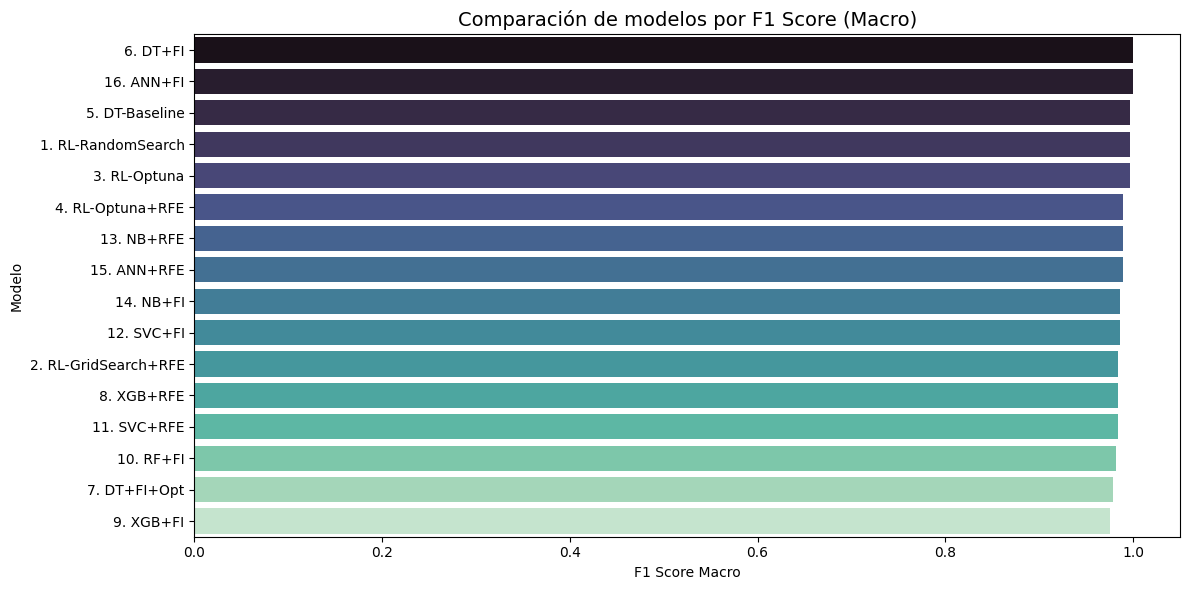

In [185]:
# Nombres de modelos y sus predicciones 
modelos = [
    ("1. RL-RandomSearch", y_test, y_predrlrs),
    ("2. RL-GridSearch+RFE", y_testrfe, y_predrlgs),
    ("3. RL-Optuna", y_test, y_predbrlo),
    ("4. RL-Optuna+RFE", y_testrfe, y_predbrlorfe),
    ("5. DT-Baseline", y_test, y_preddt),
    ("6. DT+FI", y_testfi, y_preddtfi),
    ("7. DT+FI+Opt", y_testfi, y_preddtop),
    ("8. XGB+RFE", y_testrfe, y_predxgbrfe),
    ("9. XGB+FI", y_testfi, y_predxgbfi),
    ("10. RF+FI", y_testfi, y_predrf),
    ("11. SVC+RFE", y_testrfe, y_predsvmrfe),
    ("12. SVC+FI", y_testfi, y_predsvmfi),
    ("13. NB+RFE", y_testrfe, y_prednvrfe),
    ("14. NB+FI", y_testfi, y_prednvfi),
    ("15. ANN+RFE", y_testrfe, y_predfrnrfe),
    ("16. ANN+FI", y_testfi, y_predfrnfi)
]

# Calcular métricas
resultados = []
for nombre, y_true, y_pred in modelos:
    try:
        resultados.append({
            "Modelo": nombre,
            "Accuracy": accuracy_score(y_true, y_pred),
            "Recall (Macro)": recall_score(y_true, y_pred, average='macro'),
            "F1 Score (Macro)": f1_score(y_true, y_pred, average='macro'),
            "ROC AUC": roc_auc_score(y_true, y_pred),  
            "MCC": matthews_corrcoef(y_true, y_pred)
        })
    except Exception as e:
        print(f"Error en modelo {nombre}: {e}")
        continue

# Crear DataFrame
df_resultados = pd.DataFrame(resultados).sort_values(by="F1 Score (Macro)", ascending=False)

# Mostrar tabla
display(df_resultados)

# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x="F1 Score (Macro)", y="Modelo", data=df_resultados, palette="mako")
plt.title("Comparación de modelos por F1 Score (Macro)", fontsize=14)
plt.xlabel("F1 Score Macro")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()


## Conjunto de validacion

Modelo  Accuracy  Recall (Macro)  F1 Score (Macro)   ROC AUC  \
5        11. SVC+RFE  0.961538        0.961538          0.961535  0.961538   
9        15. ANN+RFE  0.961538        0.961538          0.961535  0.961538   
6         12. SVC+FI  0.961538        0.961538          0.961532  0.961538   
1       7. DT+FI+Opt  0.957265        0.957265          0.957265  0.957265   
8          14. NB+FI  0.948718        0.948718          0.948703  0.948718   
7         13. NB+RFE  0.947115        0.947115          0.947104  0.947115   
0   4. RL-Optuna+RFE  0.899038        0.899038          0.898643  0.899038   
4          10. RF+FI  0.893162        0.893162          0.892722  0.893162   
10        16. ANN+FI  0.739316        0.739316          0.729305  0.739316   
2         8. XGB+RFE  0.697115        0.697115          0.688289  0.697115   
3          9. XGB+FI  0.547009        0.547009          0.430055  0.547009   

         MCC  
5   0.923248  
9   0.923248  
6   0.923381  
1   0.914530  
8   0.897961  
7   0.894603  
0   0.804386  
4   0.792868  
10  0.518519  
2   0.418651  
3   0.222098

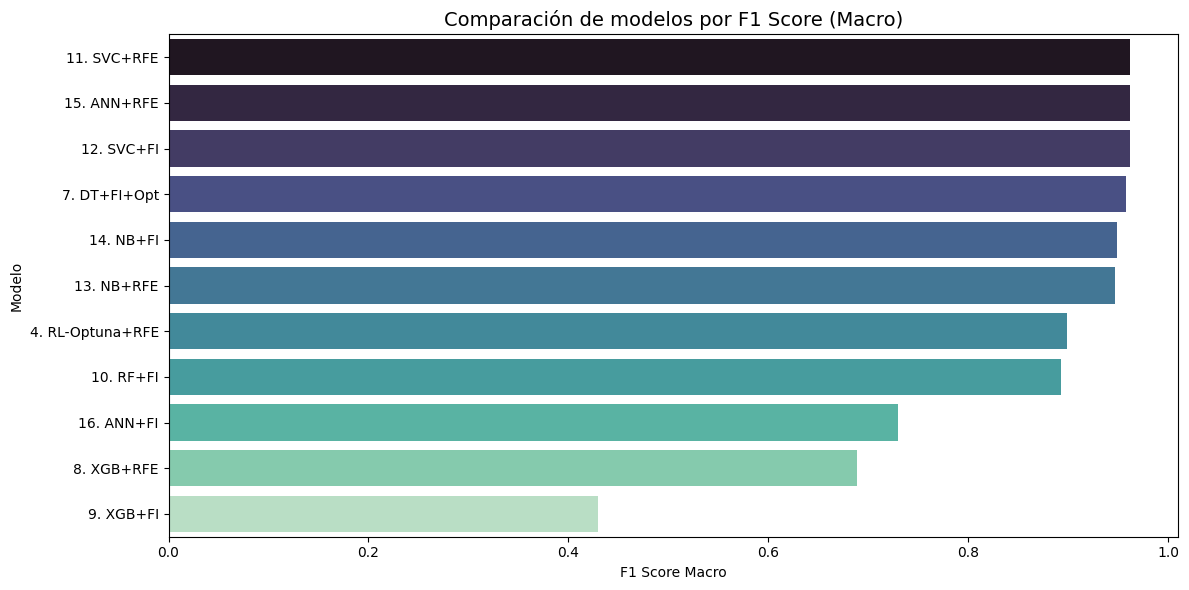

In [186]:
# Nombres de modelos y sus predicciones 
modelosv = [
    
    ("4. RL-Optuna+RFE", dftrfe_test, y_predbrlorfedt),
    ("7. DT+FI+Opt", dft_test, y_preddttfi),
    ("8. XGB+RFE", dftrfe_test, y_predxgbrfedft),
    ("9. XGB+FI", dft_test, y_predxgbfit),
    ("10. RF+FI", dft_test, y_predrft),
    ("11. SVC+RFE", dftrfe_test, y_predsvmrfedft),
    ("12. SVC+FI", dft_test, y_predsvmtfit),
    ("13. NB+RFE", dftrfe_test, y_prednvrfedft),
    ("14. NB+FI", dft_test, y_prednvfit),
    ("15. ANN+RFE", dftrfe_test, y_predfrnrfedft),
    ("16. ANN+FI", dft_test, y_predfrndftt)
]

# Calcular métricas
resultadosv = []
for nombrev, y_truev, y_predv in modelosv:
    try:
        resultadosv.append({
            "Modelo": nombrev,
            "Accuracy": accuracy_score(y_truev, y_predv),
            "Recall (Macro)": recall_score(y_truev, y_predv, average='macro'),
            "F1 Score (Macro)": f1_score(y_truev, y_predv, average='macro'),
            "ROC AUC": roc_auc_score(y_truev, y_predv),  
            "MCC": matthews_corrcoef(y_truev, y_predv)
        })
    except Exception as e:
        print(f"Error en modelo {nombrev}: {e}")
        continue

# Crear DataFrame
df_resultadosv = pd.DataFrame(resultadosv).sort_values(by="F1 Score (Macro)", ascending=False)

# Mostrar tabla
display(df_resultadosv)

# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x="F1 Score (Macro)", y="Modelo", data=df_resultadosv, palette="mako")
plt.title("Comparación de modelos por F1 Score (Macro)", fontsize=14)
plt.xlabel("F1 Score Macro")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()
